# Gorda Ridge sequence analysis
Hu et al. in prep
July 2020

In [328]:
library(tidyverse);library(reshape2);library(cowplot);library(patchwork)

In [2]:
# Load ASV tables (long and wide format provided as R objects)
## ASV table also provided as .txt table: GR-rawASV-table.txt
load("data-input/GR-ASV-table-input.RData", verbose = T)

Loading objects:
  GR_tagseq_counts
  GR_tagseq_counts_wideASVtable


## Clean ASV table with 'decontam' in phyloseq

In [3]:
library(phyloseq);library(decontam)

In [4]:
# Run decontam protocol
# Formatting: fix blank entries, widen data frame
GR_tagseq_counts$level2 <- sub("^$", "Unassigned", GR_tagseq_counts$level2) #Fill "blank" taxonomy assignments with "Unassigned"
head(GR_tagseq_counts)
tmp <- GR_tagseq_counts[, c("Feature.ID", "SAMPLE", "COUNT")]
tmp$COUNT<-as.numeric(tmp$COUNT)
tmp_tax <- GR_tagseq_counts[, c("Taxon", "level1", "level2", "level3", "level4", "level5", "level6","Feature.ID", "SAMPLE", "COUNT")]
# head(tmp_tax)
asvtab <- dcast(tmp, Feature.ID ~ SAMPLE, fill = 0)
taxmat_tmp <- as.matrix(dcast(tmp_tax, Feature.ID+Taxon+level1+level2+level3+level4+level5+level6+level6~SAMPLE))
taxmat <- taxmat_tmp[, c("Taxon", "level1", "level2", "level3", "level4", "level5", "level6")]

# Set up data to be imported into phyloseq
# Rownames = feature.id
row.names(asvtab)<-asvtab$Feature.ID
colnames(asvtab)
asvtab <- asvtab[2:35]
# head(asvtab); names(asvtab)
asvmat <- as.matrix(asvtab) #convert to matrix

# link up row names for each matrix
row.names(taxmat)<-row.names(asvmat)
# head(taxmat)
#
class(asvmat);class(taxmat)
colnames(taxmat)
ASV = otu_table(asvmat, taxa_are_rows = TRUE) #phyloseq command
TAX = tax_table(taxmat)
physeq <- phyloseq(ASV, TAX)
physeq #Phyloseq object

# Include additional sample names
samplenames <- as.data.frame(colnames(asvtab))
samplenames; head(asvtab)
colnames(samplenames)[1]<-"SAMPLE"

# Import metadata
ventnames <- read.delim("ventnames-gordaridge.txt")
names(ventnames);head(ventnames)
# View(ventnames)
colnames(ventnames)[1]<-"SAMPLE"
#
samplenames_1 <- left_join(samplenames, ventnames)
head(samplenames_1)
# View(samplenames_1)
row.names(samplenames_1)<-sample_names(physeq)

# Convert to phyloseq object
sampledata <- sample_data(samplenames_1); sampledata
# Merge with other data
physeq_names = merge_phyloseq(physeq, sampledata)
physeq_names
sample_data(physeq_names)

# Decontam:
physeq_names
# Check out library size of my data
df <- as.data.frame(sample_data(physeq_names))
df$LibrarySize <- sample_sums(physeq_names)
df <- df[order(df$LibrarySize),]
df$Index <- seq(nrow(df))
#
ggplot(data=df, aes(x=Index, y=LibrarySize, fill=Sample_or_Control, shape=LOCATION)) + 
  geom_point(color="black", size=3, aes(shape=LOCATION)) +
  scale_shape_manual(values = c(21,22,23)) +
  theme_bw()
# Shows that out of the 3 ship blanks I have, one of the sames has a pretty large library size, otherwise, control samples have very small library sizes.

sample_data(physeq_names)
# assign negative control designation
sample_data(physeq_names)$is.neg <- sample_data(physeq_names)$Sample_or_Control == "Control Sample"

# ID contaminants
## Using Prevalence information
contamdf.prev <- isContaminant(physeq_names, method="prevalence", neg="is.neg", threshold = 0.5, normalize = TRUE) # 0.5 - this threshold will ID contaminants in all samples that are more prevalent in negative controls than in positive samplese
# ?isContaminant()
table(contamdf.prev$contaminant) # 34 seqs identified as contaminants
which(contamdf.prev$contaminant)

# Make phyloseq object of presence-absence in negative controls and true samples
## change to presence absence
gr.pa <- transform_sample_counts(physeq_names, function(abund) 1*(abund>0))

# isolate PA of positive and negative samples
gr.pa.neg <- prune_samples(sample_data(gr.pa)$Sample_or_Control == "Control Sample", gr.pa)
gr.pa.pos <- prune_samples(sample_data(gr.pa)$Sample_or_Control == "True Sample", gr.pa)
                                 
                                 # Extracting contaminants:
table(contamdf.prev$contaminant) # 34 seqs identified as contaminants
which(contamdf.prev$contaminant)
head(contamdf.prev)

# Subset TRUE contaminants
contams <- subset(contamdf.prev, contaminant == "TRUE")
contams$Feature.ID <- row.names(contams)
head(contams);dim(contams)
list_of_contams <- as.character(contams$Feature.ID)
#
# Explore taxa IDed as contaminants
taxa_list <- as.data.frame(taxmat)
taxa_list$Feature.ID <- row.names(taxa_list)
head(taxa_list)
taxa_contams <- left_join(contams, taxa_list)
# write_delim(taxa_contams, path = "List-of-contaminant-ASVs.txt", delim = "\t")


# Plot total sequences and which are contaminants
# Remove contaminant and count sequence sums per sample to see which samples had the highest number of contamiant sequences removed.
# After remove contaminants, what % of sequences is removed?
head(GR_tagseq_counts[1:2,])
GR_tagseq_counts$CONTAM <- "Pass"
# head(contams[1:2,])
str(list_of_contams)
GR_tagseq_counts$CONTAM[GR_tagseq_counts$Feature.ID %in% list_of_contams] = "Fail"
head(GR_tagseq_counts[1:2,])

# Make character list of all feature.ids to KEEP:
keep1<- subset(GR_tagseq_counts, CONTAM %in% "Pass")
length(unique(keep1$Feature.ID))
keep_asvs <- as.character(unique(keep1$Feature.ID)) #see below
#
passfail <- GR_tagseq_counts %>%
  group_by(SAMPLE, CONTAM) %>%
  summarise(SUM_CONTAM = sum(COUNT)) %>%
  data.frame
head(passfail[1:2,])
#
names(ventnames);head(ventnames)
# View(ventnames)
colnames(ventnames)[1]<-"SAMPLE"
#
passfail_wID <- left_join(passfail, ventnames, by = "SAMPLE")
head(passfail_wID)

locations <- c("", "Shipblank","Shallow seawater", "Deep seawater", "Mt Edwards Plume", "Mt Edwards Vent", "Candelabra Vent", "SirVentsAlot Vent", "Venti Latte Vent")
passfail_wID$LOCATION_ORDER <- factor(passfail_wID$LocationName, levels = locations)
#
contam_plot <- ggplot(passfail_wID, aes(x=SAMPLE, y=SUM_CONTAM, fill=CONTAM))+
  geom_bar(stat = "identity", color="black")+
  scale_fill_manual(values = c("#e34a33", "#3182bd"))+
  coord_flip()+
  labs(x="", y="Total sequences")+
  theme_minimal()+
  theme(legend.position = "top", strip.text.y = element_text(angle=0, color="black"), axis.text = element_text(color="black", face="bold"))+
  scale_y_continuous(expand=c(0,0))+
  facet_grid(LOCATION_ORDER~., scales = "free", space="free")
# svg("GR-seq-contamination-breakdown.svg",w=13,h=6)
plot_grid(contam_plot, contam_plot+scale_y_log10()+labs(y="Log(total sequences)"), labels = c("a", "b"))
# dev.off()


# Get number information:
# Total sequences:
head(GR_tagseq_counts); sum(GR_tagseq_counts$COUNT) #1.57 million reads

# If we remove all the control samples:
unique(GR_tagseq_counts$SAMPLEID)
GR_tagseq_counts_noCTRL <- subset(GR_tagseq_counts, !(SAMPLEID %in% "CTRL"))
sum(GR_tagseq_counts_noCTRL$COUNT) # 1.48 million reads

# Remove contaminants:
counts_decont <- subset(GR_tagseq_counts, !(Feature.ID %in% list_of_contams))
dim(GR_tagseq_counts); dim(counts_decont) #34 lines removed
colnames(counts_decont)
100*(1-(sum(counts_decont$COUNT)/sum(GR_tagseq_counts_noCTRL$COUNT)))
# 1.24% of sequences was removed following decontam; this is counting the ship blank samples themselves

# Breakdown by samples:
head(passfail)
passfail_wide <- dcast(passfail, SAMPLE ~ CONTAM)
passfail_wide$PercLossSeq <- paste(100*(passfail_wide$Fail/(passfail_wide$Fail+passfail_wide$Pass)))
dim(passfail_wide)
write.csv(passfail_wide, file="PercSeqLost-decontam.csv")
# breakdown by sample - reports % lost per sample

# Remove contaminant sequences from phyloseq object:
# Subset TRUE contaminants
# ?prune_taxa
class(keep_asvs)
physeq_tmp <- prune_taxa(keep_asvs, physeq_names)
sample_data(physeq_tmp)

# Remove one sample with too few sequences
physeq_clean <- subset_samples(physeq_tmp, sample_names(physeq_tmp) !="GordaRidge_BSW020_sterivex_2019_REPa")
sample_data(physeq_clean)

# SAMPLE, LOCATION_SPECIFIC, LocationName
colnames(taxmat)

# Remove control samples from data frame
head(GR_tagseq_counts)
tmp <- subset(GR_tagseq_counts, !(SAMPLEID %in% "CTRL")) # Remove controls, get list of sample names that are controls
samples_keep <- as.character(unique(tmp$SAMPLE))
physeq_clean_true <- prune_samples(samples_keep, physeq_clean)
#
physeq_clean_true %>% sample_data %>% head

# Save as R Data
# save(counts_decont, file="GR-ASV-table-clean-26-02-2020.RData")

DATASET LOCATION       SAMPLEID YEAR REP Feature.ID                      
87172 Axial   ExtractControl CTRL     2019     2fa21026b4047e354f119a43c0341a65
87236 Axial   ExtractControl CTRL     2019     6bbf315adb7368844fd1dc625be81e30
87273 Axial   ExtractControl CTRL     2019     01d46e90107929f3903e4b5bff58a630
87616 Axial   ExtractControl CTRL     2019     389950e760558e927385e40108737f9f
87957 Axial   ExtractControl CTRL     2019     e613ce213c5added27988e9117e933fd
88999 Axial   ExtractControl CTRL     2019     6d4984d3004dc93a767b711fce76c22a
      Taxon                                                                                               
87172 Eukaryota;Opisthokonta                                                                              
87236 Eukaryota                                                                                           
87273 Eukaryota                                                                                           
87616 Eukaryota;Opisthokonta;Fungi;Basidiomycota;Agaricomycotina;Agaricomycetes;Sclerotium;Sclerotium_sp.;
87957 Eukaryota;Opisthokonta;Fungi;Basidiomycota;Pucciniomycotina;Cystobasidiomycetes;Rhodotorula         
88999 Eukaryota                                                                                           
      Confidence level1    level2       level3 level4        level5          
87172 0.7041164  Eukaryota Opisthokonta                                      
87236 1.0000000  Eukaryota Unassigned                                        
87273 1.0000000  Eukaryota Unassigned                                        
87616 0.9742164  Eukaryota Opisthokonta Fungi  Basidiomycota Agaricomycotina 
87957 0.9971533  Eukaryota Opisthokonta Fungi  Basidiomycota Pucciniomycotina
88999 1.0000000  Eukaryota Unassigned                                        
      level6              level7                    
87172                                               
87236                                               
87273                                               
87616 Agaricomycetes      Sclerotium;Sclerotium_sp.;
87957 Cystobasidiomycetes Rhodotorula               
88999                                               
      SAMPLE                         COUNT
87172 Axial_ExtractControl_CTRL_2019 1520 
87236 Axial_ExtractControl_CTRL_2019  260 
87273 Axial_ExtractControl_CTRL_2019   31 
87616 Axial_ExtractControl_CTRL_2019  471 
87957 Axial_ExtractControl_CTRL_2019   24 
88999 Axial_ExtractControl_CTRL_2019   96

Using COUNT as value column: use value.var to override.

Using COUNT as value column: use value.var to override.



[1] "Feature.ID"                            
 [2] "Axial_ExtractControl_CTRL_2019"        
 [3] "GordaRidge_BSW020_sterivex_2019_REPa"  
 [4] "GordaRidge_BSW056_sterivex_2019_REPb"  
 [5] "GordaRidge_BSW081_sterivex_2019"       
 [6] "GordaRidge_Plume001_sterivex_2019_REPa"
 [7] "GordaRidge_Plume001_sterivex_2019_REPb"
 [8] "GordaRidge_Plume001_T0_2019_REP12"     
 [9] "GordaRidge_Plume001_T0_2019_REP34"     
[10] "GordaRidge_Plume001_T24_2019_REP12"    
[11] "GordaRidge_Plume001_T36_2019_REP12"    
[12] "GordaRidge_Plume036_sterivex_2019_REPb"
[13] "GordaRidge_Plume096_sterivex_2019"     
[14] "GordaRidge_Shipblank_CTRL_2019_S31"    
[15] "GordaRidge_Shipblank_CTRL_2019_S32"    
[16] "GordaRidge_Shipblank_CTRL_2019_S33"    
[17] "GordaRidge_Vent009_SUPRS1_2019"        
[18] "GordaRidge_Vent010_SUPRS2_2019"        
[19] "GordaRidge_Vent011_SUPRS3_2019"        
[20] "GordaRidge_Vent013_T0_2019_REP13"      
[21] "GordaRidge_Vent013_T36_2019_REP12"     
[22] "GordaRidge_Vent013_T36_2019_REP34"     
[23] "GordaRidge_Vent039_SUPRS1_2019"        
[24] "GordaRidge_Vent040_SUPRS2_2019"        
[25] "GordaRidge_Vent041_SUPRS3_2019"        
[26] "GordaRidge_Vent043_T0_2019_REP13"      
[27] "GordaRidge_Vent043_T36_2019_REP13"     
[28] "GordaRidge_Vent086_SUPRS1_2019"        
[29] "GordaRidge_Vent087_SUPRS2_2019"        
[30] "GordaRidge_Vent088_SUPRS3_2019"        
[31] "GordaRidge_Vent090_T24_2019"           
[32] "GordaRidge_Vent105_SUPRS9_2019"        
[33] "GordaRidge_Vent106_SUPRS10_2019"       
[34] "GordaRidge_Vent107_SUPRS11_2019"       
[35] "GordaRidge_Vent110_T24_2019"

[1] "matrix"

[1] "matrix"

[1] "Taxon"  "level1" "level2" "level3" "level4" "level5" "level6"

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9175 taxa and 34 samples ]
tax_table()   Taxonomy Table:    [ 9175 taxa by 7 taxonomic ranks ]

colnames(asvtab)                      
1  Axial_ExtractControl_CTRL_2019        
2  GordaRidge_BSW020_sterivex_2019_REPa  
3  GordaRidge_BSW056_sterivex_2019_REPb  
4  GordaRidge_BSW081_sterivex_2019       
5  GordaRidge_Plume001_sterivex_2019_REPa
6  GordaRidge_Plume001_sterivex_2019_REPb
7  GordaRidge_Plume001_T0_2019_REP12     
8  GordaRidge_Plume001_T0_2019_REP34     
9  GordaRidge_Plume001_T24_2019_REP12    
10 GordaRidge_Plume001_T36_2019_REP12    
11 GordaRidge_Plume036_sterivex_2019_REPb
12 GordaRidge_Plume096_sterivex_2019     
13 GordaRidge_Shipblank_CTRL_2019_S31    
14 GordaRidge_Shipblank_CTRL_2019_S32    
15 GordaRidge_Shipblank_CTRL_2019_S33    
16 GordaRidge_Vent009_SUPRS1_2019        
17 GordaRidge_Vent010_SUPRS2_2019        
18 GordaRidge_Vent011_SUPRS3_2019        
19 GordaRidge_Vent013_T0_2019_REP13      
20 GordaRidge_Vent013_T36_2019_REP12     
21 GordaRidge_Vent013_T36_2019_REP34     
22 GordaRidge_Vent039_SUPRS1_2019        
23 GordaRidge_Vent040_SUPRS2_2019        
24 GordaRidge_Vent041_SUPRS3_2019        
25 GordaRidge_Vent043_T0_2019_REP13      
26 GordaRidge_Vent043_T36_2019_REP13     
27 GordaRidge_Vent086_SUPRS1_2019        
28 GordaRidge_Vent087_SUPRS2_2019        
29 GordaRidge_Vent088_SUPRS3_2019        
30 GordaRidge_Vent090_T24_2019           
31 GordaRidge_Vent105_SUPRS9_2019        
32 GordaRidge_Vent106_SUPRS10_2019       
33 GordaRidge_Vent107_SUPRS11_2019       
34 GordaRidge_Vent110_T24_2019

Axial_ExtractControl_CTRL_2019
0009645516609bda2246e1955ff9ec1d 0                             
0030ad8ce44f257c42daf3673bf92197 0                             
0038478be7fb4f097ce93a5e9341af2a 0                             
003b5938e31a8c1b1809e0358da894e0 0                             
003ff3e98dff52952a7036585a32c2f2 0                             
004ebe8047915b78deefc412bef467b7 0                             
                                 GordaRidge_BSW020_sterivex_2019_REPa
0009645516609bda2246e1955ff9ec1d 0                                   
0030ad8ce44f257c42daf3673bf92197 0                                   
0038478be7fb4f097ce93a5e9341af2a 0                                   
003b5938e31a8c1b1809e0358da894e0 0                                   
003ff3e98dff52952a7036585a32c2f2 0                                   
004ebe8047915b78deefc412bef467b7 0                                   
                                 GordaRidge_BSW056_sterivex_2019_REPb
0009645516609bda2246e1955ff9ec1d  0                                  
0030ad8ce44f257c42daf3673bf92197  0                                  
0038478be7fb4f097ce93a5e9341af2a 21                                  
003b5938e31a8c1b1809e0358da894e0  0                                  
003ff3e98dff52952a7036585a32c2f2  0                                  
004ebe8047915b78deefc412bef467b7  0                                  
                                 GordaRidge_BSW081_sterivex_2019
0009645516609bda2246e1955ff9ec1d 80                             
0030ad8ce44f257c42daf3673bf92197 36                             
0038478be7fb4f097ce93a5e9341af2a 89                             
003b5938e31a8c1b1809e0358da894e0 13                             
003ff3e98dff52952a7036585a32c2f2  0                             
004ebe8047915b78deefc412bef467b7  0                             
                                 GordaRidge_Plume001_sterivex_2019_REPa
0009645516609bda2246e1955ff9ec1d  0                                    
0030ad8ce44f257c42daf3673bf92197  0                                    
0038478be7fb4f097ce93a5e9341af2a 86                                    
003b5938e31a8c1b1809e0358da894e0  0                                    
003ff3e98dff52952a7036585a32c2f2  0                                    
004ebe8047915b78deefc412bef467b7  0                                    
                                 GordaRidge_Plume001_sterivex_2019_REPb
0009645516609bda2246e1955ff9ec1d  0                                    
0030ad8ce44f257c42daf3673bf92197  0                                    
0038478be7fb4f097ce93a5e9341af2a 19                                    
003b5938e31a8c1b1809e0358da894e0  0                                    
003ff3e98dff52952a7036585a32c2f2  0                                    
004ebe8047915b78deefc412bef467b7  0                                    
                                 GordaRidge_Plume001_T0_2019_REP12
0009645516609bda2246e1955ff9ec1d  0                               
0030ad8ce44f257c42daf3673bf92197  0                               
0038478be7fb4f097ce93a5e9341af2a 19                               
003b5938e31a8c1b1809e0358da894e0  0                               
003ff3e98dff52952a7036585a32c2f2  0                               
004ebe8047915b78deefc412bef467b7  0                               
                                 GordaRidge_Plume001_T0_2019_REP34
0009645516609bda2246e1955ff9ec1d  0                               
0030ad8ce44f257c42daf3673bf92197  0                               
0038478be7fb4f097ce93a5e9341af2a  6                               
003b5938e31a8c1b1809e0358da894e0  0                               
003ff3e98dff52952a7036585a32c2f2 41                               
004ebe8047915b78deefc412bef467b7  0                               
                                 GordaRidge_Plume001_T24_2019_REP12
0009645516609bda2246e1955ff9ec1d  0                                
0030ad8ce44f257c42daf3673bf92197  0                                


Warning message in file(file, "rt"):
“cannot open file 'ventnames-gordaridge.txt': No such file or directory”


ERROR: Error in file(file, "rt"): cannot open the connection


## Plot high level taxonomy of protists in situ

In [5]:
load("data-input/GR-ASV-table-clean-26-02-2020.RData", verbose=TRUE) # after decontam clenaing
head(counts_decont)
#
gr_counts <- subset(counts_decont, COUNT > 0 & DATASET %in% "GordaRidge")
# head(gr_counts)
gr_counts$level2 <- sub("^$", "Unassigned", gr_counts$level2)
# head(gr_counts[1:3,])
#
# Import metadata for sample names & Join
ventnames <- read.delim("data-input/ventnames-gordaridge.txt")
names(ventnames)
colnames(ventnames)[1]<-"SAMPLE"
gr_counts_name <- left_join(gr_counts, ventnames[c(1,3,5:6)])
gr_counts_name$LocationName[gr_counts_name$LOCATION == "Shipblank"]="Shipblank"

Loading objects:
  counts_decont


DATASET LOCATION       SAMPLEID YEAR REP Feature.ID                      
87172 Axial   ExtractControl CTRL     2019     2fa21026b4047e354f119a43c0341a65
87273 Axial   ExtractControl CTRL     2019     01d46e90107929f3903e4b5bff58a630
88999 Axial   ExtractControl CTRL     2019     6d4984d3004dc93a767b711fce76c22a
89193 Axial   ExtractControl CTRL     2019     7f345942b109d8107ed8748e752b3b67
90196 Axial   ExtractControl CTRL     2019     7ba8f74df1b3dcb5c010795eb26bac7f
90635 Axial   ExtractControl CTRL     2019     5a2177bb7499febc60184a6a15dd3a9c
      Taxon                                                                                       
87172 Eukaryota;Opisthokonta                                                                      
87273 Eukaryota                                                                                   
88999 Eukaryota                                                                                   
89193 Eukaryota;Opisthokonta;Metazoa;Rotifera;Rotifera_X;Rotifera_XX;Rotaria;Rotaria_rotatoria;   
90196 Eukaryota;Archaeplastida;Streptophyta;Embryophyceae;Embryophyceae_X;Embryophyceae_XX        
90635 Eukaryota;Alveolata;Ciliophora;Oligohymenophorea;Scuticociliatia_2;Pleuronematida;Pleuronema
      Confidence level1    level2         level3       level4           
87172 0.7041164  Eukaryota Opisthokonta                                 
87273 1.0000000  Eukaryota Unassigned                                   
88999 1.0000000  Eukaryota Unassigned                                   
89193 0.8935792  Eukaryota Opisthokonta   Metazoa      Rotifera         
90196 0.9998972  Eukaryota Archaeplastida Streptophyta Embryophyceae    
90635 0.9484855  Eukaryota Alveolata      Ciliophora   Oligohymenophorea
      level5            level6           level7                    
87172                                                              
87273                                                              
88999                                                              
89193 Rotifera_X        Rotifera_XX      Rotaria;Rotaria_rotatoria;
90196 Embryophyceae_X   Embryophyceae_XX                           
90635 Scuticociliatia_2 Pleuronematida   Pleuronema                
      SAMPLE                         COUNT CONTAM
87172 Axial_ExtractControl_CTRL_2019 1520  Pass  
87273 Axial_ExtractControl_CTRL_2019   31  Pass  
88999 Axial_ExtractControl_CTRL_2019   96  Pass  
89193 Axial_ExtractControl_CTRL_2019   81  Pass  
90196 Axial_ExtractControl_CTRL_2019   39  Pass  
90635 Axial_ExtractControl_CTRL_2019   30  Pass

[1] "SAMPLENAME"        "LOCATION"          "LOCATION_SPECIFIC"
[4] "SAMPLEID"          "Sampletype"        "LocationName"     
[7] "Sample_or_Control" "Sample_or_BSW"

Joining, by = "SAMPLE"



In [6]:
unique(gr_counts_name$level3)

[1] Metazoa             Ciliophora          Fungi              
 [4] Ochrophyta          Dinoflagellata                         
 [7] Sagenista           Haptophyta          Radiolaria         
[10] Chlorophyta         Cryptophyta         Choanoflagellida   
[13] Picozoa             Katablepharidophyta Pseudofungi        
[16] Telonemia           Hilomonadea         Stramenopiles_X    
[19] Streptophyta        Apicomplexa         Opalozoa           
[22] Cercozoa            Metamonada          Discoba            
[25] Lobosa              Alveolata_X         Apusomonadidae     
[28] Perkinsea           Breviatea           Opisthokonta_X     
[31] Centroheliozoa     
32 Levels:  Alveolata_X Apicomplexa Apusomonadidae Breviatea ... Telonemia

In [25]:
# # Revise & explore taxonomy
# # hist(gr_counts_name$COUNT)
# # hist(log(gr_counts_name$COUNT))
# #
pr2_rename_taxa_w2<-function(split){
  split$Taxa<-"Unassigned"
  split$Taxa[split$level2 == ""]="No best hit"
  split$Taxa[split$level2 == "Alveolata"]="Alveolata-Other"
  split$Taxa[split$level3 == "Ciliophora"]="Alveolata-Ciliates"
  split$Taxa[split$level3 == "Dinoflagellata"]="Alveolata-Dinoflagellates"
  split$Taxa[split$level4 == "Syndiniales"] = "Alveolata-Syndiniales"
  # split$Taxa[split$level3 == "Apicomplexa"]="Alveolata-Apicomplexa"
  split$Taxa[split$level2 == "Hacrobia"]="Hacrobia-Other"
  split$Taxa[split$level3 == "Cryptophyta"]="Hacrobia-Cryptophyta"
  split$Taxa[split$level3 == "Haptophyta"]="Hacrobia-Haptophyta"
  # split$Taxa[split$level3 == "Katablepharidophyta"]="Hacrobia-Katablepharidophyta"
  # split$Taxa[split$level3 == "Telonemia"]="Hacrobia-Telonemia"
  split$Taxa[split$level2 == "Opisthokonta"]="Opisthokonta-Other"
  split$Taxa[split$level3 == "Fungi"]="Opisthokonta-Fungi"
  split$Taxa[split$level3 == "Metazoa"]="Opisthokonta-Metazoa"
  split$Taxa[split$level2 == "Stramenopiles"]="Stramenopiles-Other"
  split$Taxa[split$level3 == "Ochrophyta"]="Stramenopiles-Ochrophyta"
  mast <- unique(filter(gr_counts_name, grepl("MAST", level4)) %>% select(level4))
  mast_list <- as.character(mast$level4)
  split$Taxa[split$level4 %in% mast_list]="Stramenopiles-MAST"
  # split$Taxa[split$level3 == "Pseudofungi"]="Stramenopiles-Pseudofungi"
  # split$Taxa[split$level3 == "Sagenista"]="Stramenopiles-Sagenista"
  #
  split$Taxa[split$level2 == "Archaeplastida"]="Archaeplastida-Other"
  split$Taxa[split$level3 == "Chlorophyta"]="Archaeplastida-Chlorophyta"
  # split$Taxa[split$level3 == "Streptophyta"]="Archaeplastida-Streptophyta"
  #
  split$Taxa[split$level2 == "Excavata"]="Excavata"
  # split$Taxa[split$level3 == "Metamonada"]="Excavata-Metamonada"
  #
  split$Taxa[split$level2 == "Amoebozoa"]="Amoebozoa"
  # split$Taxa[split$level3 == "Lobosa"]="Amoebozoa-Lobosa"
  #
  split$Taxa[split$level2 == "Rhizaria"]="Rhizaria-other"
  split$Taxa[split$level3 == "Cercozoa"]="Rhizaria-Cercozoa"
  return(split)
}

gr_counts_wtax <- pr2_rename_taxa_w2(gr_counts_name)
head(gr_counts_wtax)
unique(gr_counts_wtax$Taxa)

DATASET    LOCATION SAMPLEID YEAR REP Feature.ID                      
1 GordaRidge Vent090  T24      2019     d1556173c68ab8e2aff268e351965276
2 GordaRidge Vent090  T24      2019     ffa3237237107b5e385a22e6a3b0c5da
3 GordaRidge Vent090  T24      2019     bae2052f4e06fa7e85bd9ca8000061ea
4 GordaRidge Vent090  T24      2019     1ec57dbba9f08644c82c8993cc0be047
5 GordaRidge Vent090  T24      2019     6d79dda1be8786b3376d5968384f7e74
6 GordaRidge Vent090  T24      2019     99ba81c88f63f83daf290add3918d38b
  Taxon                                                                                                             
1 Eukaryota;Opisthokonta;Metazoa;Annelida;Annelida_X;Annelida_XX;Paralvinella;Paralvinella_sulfincola;              
2 Eukaryota;Alveolata;Ciliophora;Heterotrichea;Heterotrichea_X;Folliculinidae;Folliculinidae_X;Folliculinidae_X_sp.;
3 Eukaryota;Opisthokonta;Fungi;Basidiomycota;Pucciniomycotina;Microbotryomycetes                                    
4 Eukaryota;Alveolata;Ciliophora;Spirotrichea;Strombidiida;Tontoniidae_A;Spirotontonia;Spirotontonia_grandis;       
5 Eukaryota;Opisthokonta;Fungi                                                                                      
6 Eukaryota;Stramenopiles;Ochrophyta;Pelagophyceae;Pelagomonadales;Pelagomonadaceae                                 
  Confidence level1    level2        ⋯ level5           level6            
1 0.9998769  Eukaryota Opisthokonta  ⋯ Annelida_X       Annelida_XX       
2 0.8696720  Eukaryota Alveolata     ⋯ Heterotrichea_X  Folliculinidae    
3 0.9998153  Eukaryota Opisthokonta  ⋯ Pucciniomycotina Microbotryomycetes
4 0.8835951  Eukaryota Alveolata     ⋯ Strombidiida     Tontoniidae_A     
5 0.7477629  Eukaryota Opisthokonta  ⋯                                    
6 0.9865985  Eukaryota Stramenopiles ⋯ Pelagomonadales  Pelagomonadaceae  
  level7                                 SAMPLE                      COUNT
1 Paralvinella;Paralvinella_sulfincola;  GordaRidge_Vent090_T24_2019   65 
2 Folliculinidae_X;Folliculinidae_X_sp.; GordaRidge_Vent090_T24_2019  241 
3                                        GordaRidge_Vent090_T24_2019    7 
4 Spirotontonia;Spirotontonia_grandis;   GordaRidge_Vent090_T24_2019   24 
5                                        GordaRidge_Vent090_T24_2019 5884 
6                                        GordaRidge_Vent090_T24_2019 2053 
  CONTAM LOCATION_SPECIFIC Sampletype LocationName    Taxa                    
1 Pass   Vent090           Grazing    Candelabra Vent Opisthokonta-Metazoa    
2 Pass   Vent090           Grazing    Candelabra Vent Alveolata-Ciliates      
3 Pass   Vent090           Grazing    Candelabra Vent Opisthokonta-Fungi      
4 Pass   Vent090           Grazing    Candelabra Vent Alveolata-Ciliates      
5 Pass   Vent090           Grazing    Candelabra Vent Opisthokonta-Fungi      
6 Pass   Vent090           Grazing    Candelabra Vent Stramenopiles-Ochrophyta

[1] "Opisthokonta-Metazoa"       "Alveolata-Ciliates"        
 [3] "Opisthokonta-Fungi"         "Stramenopiles-Ochrophyta"  
 [5] "Alveolata-Dinoflagellates"  "Unassigned"                
 [7] "Opisthokonta-Other"         "Stramenopiles-MAST"        
 [9] "Hacrobia-Haptophyta"        "Rhizaria-other"            
[11] "Archaeplastida-Other"       "Archaeplastida-Chlorophyta"
[13] "Stramenopiles-Other"        "Hacrobia-Cryptophyta"      
[15] "Hacrobia-Other"             "Alveolata-Syndiniales"     
[17] "Alveolata-Other"            "Rhizaria-Cercozoa"         
[19] "Excavata"                   "Amoebozoa"

In [26]:
# Remove control - blank samples.
gr_counts_wtax_samplesonly <- subset(gr_counts_wtax, !(Sampletype == "control"))

## To average across replicates, modify SUPR sample names
gr_counts_filter <- gr_counts_wtax_samplesonly
gr_counts_filter$SAMPLEID<- sub("SUPRS9", "SUPR", gr_counts_filter$SAMPLEID)
gr_counts_filter$SAMPLEID<- sub("SUPRS11", "SUPR", gr_counts_filter$SAMPLEID)
gr_counts_filter$SAMPLEID<- sub("SUPRS10", "SUPR", gr_counts_filter$SAMPLEID)
gr_counts_filter$SAMPLEID<- sub("SUPRS2", "SUPR", gr_counts_filter$SAMPLEID)
gr_counts_filter$SAMPLEID<- sub("SUPRS3", "SUPR", gr_counts_filter$SAMPLEID)
gr_counts_filter$SAMPLEID<- sub("SUPRS1", "SUPR", gr_counts_filter$SAMPLEID)

# Average across replicates
colnames(gr_counts_filter)
gr_counts_avg_wtax <- gr_counts_filter %>%
  group_by(Feature.ID, SAMPLEID, Sampletype,  LOCATION_SPECIFIC, LocationName, Taxon, level1, level2, level3, level4, level5, level6, level7, Taxa) %>%
  summarise(COUNT_AVG = mean(COUNT)) %>%
  as.data.frame
# dim(gr_counts_filter);dim(gr_counts_avg_wtax)
head(gr_counts_avg_wtax)
# unique(gr_counts_avg_wtax$Taxa)

save(gr_counts_filter,gr_counts_wtax, gr_counts_avg_wtax, file="data-input/GordaRidge-ASVtable-avg-22-07-2020.RData")

[1] "DATASET"           "LOCATION"          "SAMPLEID"         
 [4] "YEAR"              "REP"               "Feature.ID"       
 [7] "Taxon"             "Confidence"        "level1"           
[10] "level2"            "level3"            "level4"           
[13] "level5"            "level6"            "level7"           
[16] "SAMPLE"            "COUNT"             "CONTAM"           
[19] "LOCATION_SPECIFIC" "Sampletype"        "LocationName"     
[22] "Taxa"

`summarise()` regrouping output by 'Feature.ID', 'SAMPLEID', 'Sampletype', 'LOCATION_SPECIFIC', 'LocationName', 'Taxon', 'level1', 'level2', 'level3', 'level4', 'level5', 'level6', 'level7' (override with `.groups` argument)



Feature.ID                       SAMPLEID Sampletype LOCATION_SPECIFIC
1 0009645516609bda2246e1955ff9ec1d sterivex in situ    BSW081           
2 0030ad8ce44f257c42daf3673bf92197 sterivex in situ    BSW081           
3 0030ad8ce44f257c42daf3673bf92197 SUPR     in situ    Vent040          
4 0030ad8ce44f257c42daf3673bf92197 SUPR     in situ    Vent088          
5 0030ad8ce44f257c42daf3673bf92197 T24      Grazing    Vent110          
6 0038478be7fb4f097ce93a5e9341af2a sterivex in situ    BSW056           
  LocationName      Taxon                                                      
1 Shallow seawater  Eukaryota                                                  
2 Shallow seawater  Eukaryota                                                  
3 Venti Latte Vent  Eukaryota                                                  
4 Candelabra Vent   Eukaryota                                                  
5 SirVentsAlot Vent Eukaryota                                                  
6 Deep seawater     Eukaryota;Opisthokonta;Metazoa;Cnidaria;Cnidaria_X;Hydrozoa
  level1    level2       level3  level4   level5     level6   level7
1 Eukaryota Unassigned                                              
2 Eukaryota Unassigned                                              
3 Eukaryota Unassigned                                              
4 Eukaryota Unassigned                                              
5 Eukaryota Unassigned                                              
6 Eukaryota Opisthokonta Metazoa Cnidaria Cnidaria_X Hydrozoa       
  Taxa                 COUNT_AVG
1 Unassigned           80       
2 Unassigned           36       
3 Unassigned           12       
4 Unassigned           34       
5 Unassigned           15       
6 Opisthokonta-Metazoa 21

In [36]:
# Sum to curated taxa level

## Average across all replicates samples
gr_counts_avg_TAXA <- gr_counts_filter %>%
    # average across replicates
    group_by(Feature.ID, SAMPLEID, Sampletype, LocationName, Taxon, level1, level2, level3, level4, level5, level6, level7, Taxa) %>%
    summarise(COUNT_AVG = mean(COUNT)) %>%
    ungroup() %>% 
    # sum by like taxa
    group_by(SAMPLEID, Sampletype, LocationName, Taxa) %>% 
    summarise(SUM = sum(COUNT_AVG)) %>% 
    unite(SAMPLE, LocationName, Sampletype, SAMPLEID, sep = "-", remove = FALSE) %>% 
    data.frame
head(gr_counts_avg_TAXA)

`summarise()` regrouping output by 'Feature.ID', 'SAMPLEID', 'Sampletype', 'LocationName', 'Taxon', 'level1', 'level2', 'level3', 'level4', 'level5', 'level6', 'level7' (override with `.groups` argument)

`summarise()` regrouping output by 'SAMPLEID', 'Sampletype', 'LocationName' (override with `.groups` argument)



SAMPLE                         SAMPLEID Sampletype LocationName 
1 Deep seawater-in situ-sterivex sterivex in situ    Deep seawater
2 Deep seawater-in situ-sterivex sterivex in situ    Deep seawater
3 Deep seawater-in situ-sterivex sterivex in situ    Deep seawater
4 Deep seawater-in situ-sterivex sterivex in situ    Deep seawater
5 Deep seawater-in situ-sterivex sterivex in situ    Deep seawater
6 Deep seawater-in situ-sterivex sterivex in situ    Deep seawater
  Taxa                       SUM 
1 Alveolata-Ciliates         2416
2 Alveolata-Dinoflagellates  4969
3 Alveolata-Other              22
4 Alveolata-Syndiniales        50
5 Archaeplastida-Chlorophyta   31
6 Archaeplastida-Other        616

In [37]:
# Factor for plotting:
# unique(gr_counts_avg_TAXA$Taxa)
level2ORDER <- c("Alveolata-Ciliates","Alveolata-Dinoflagellates","Alveolata-Syndiniales","Alveolata-Other","Rhizaria-Cercozoa","Rhizaria-other","Stramenopiles-MAST","Stramenopiles-Ochrophyta","Stramenopiles-Other","Hacrobia-Cryptophyta","Hacrobia-Haptophyta","Hacrobia-Other","Amoebozoa","Excavata","Archaeplastida-Chlorophyta","Archaeplastida-Other","Opisthokonta-Fungi","Opisthokonta-Metazoa","Opisthokonta-Other","Unassigned")
level2color <- c("#f1eef6","#d7b5d8","#df65b0","#ce1256","#800026","#e31a1c","#fff7bc","#fec44f","#d95f0e","#c7e9b4","#7fcdbb","#41b6c4","#084081","#2b8cbe","#238443","#78c679","#cbc9e2","#9e9ac8","#756bb1","#54278f")
gr_counts_avg_TAXA$LEVEL2ORDER <- factor(gr_counts_avg_TAXA$Taxa, levels=level2ORDER)
names(level2color)<-level2ORDER

# Factor experiment
unique(gr_counts_avg_TAXA$SAMPLEID)
exporder <- c("sterivex", "SUPR", "T0", "T24", "T36")
gr_counts_avg_TAXA$SAMPLEID_ORDER <- factor(gr_counts_avg_TAXA$SAMPLEID, levels = exporder)
gr_counts_avg_TAXA$LOCATION_ORDER <- factor(gr_counts_avg_TAXA$LocationName, levels=c("Shallow seawater", "Deep seawater", "Mt Edwards Plume", "Mt Edwards Vent", "Venti Latte Vent", "Candelabra Vent", "SirVentsAlot Vent"))
#
head(gr_counts_avg_TAXA[1:2,])

[1] "sterivex" "SUPR"     "T0"       "T24"      "T36"

SAMPLE                         SAMPLEID Sampletype LocationName 
1 Deep seawater-in situ-sterivex sterivex in situ    Deep seawater
2 Deep seawater-in situ-sterivex sterivex in situ    Deep seawater
  Taxa                      SUM  LEVEL2ORDER               SAMPLEID_ORDER
1 Alveolata-Ciliates        2416 Alveolata-Ciliates        sterivex      
2 Alveolata-Dinoflagellates 4969 Alveolata-Dinoflagellates sterivex      
  LOCATION_ORDER
1 Deep seawater 
2 Deep seawater

In [45]:
barplot_lev2 <- function(df){
  ggplot(df, aes(x=SAMPLE, y=SUM, fill=LEVEL2ORDER)) +
    geom_bar(stat="identity", position="fill", color="black") +
    scale_fill_manual(values=level2color) +
    scale_y_continuous(expand = c(0,0))+
    theme(legend.position = "right",
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          panel.background = element_blank(),
          axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold", size = 12),
          axis.text.y = element_text(color="black", face="bold", size = 12),
          strip.text = element_blank(),
          legend.title = element_blank()) +
    labs(x="", y="Relative abundance")+
    facet_grid(.~LOCATION_ORDER, space = "free", scales = "free")
}

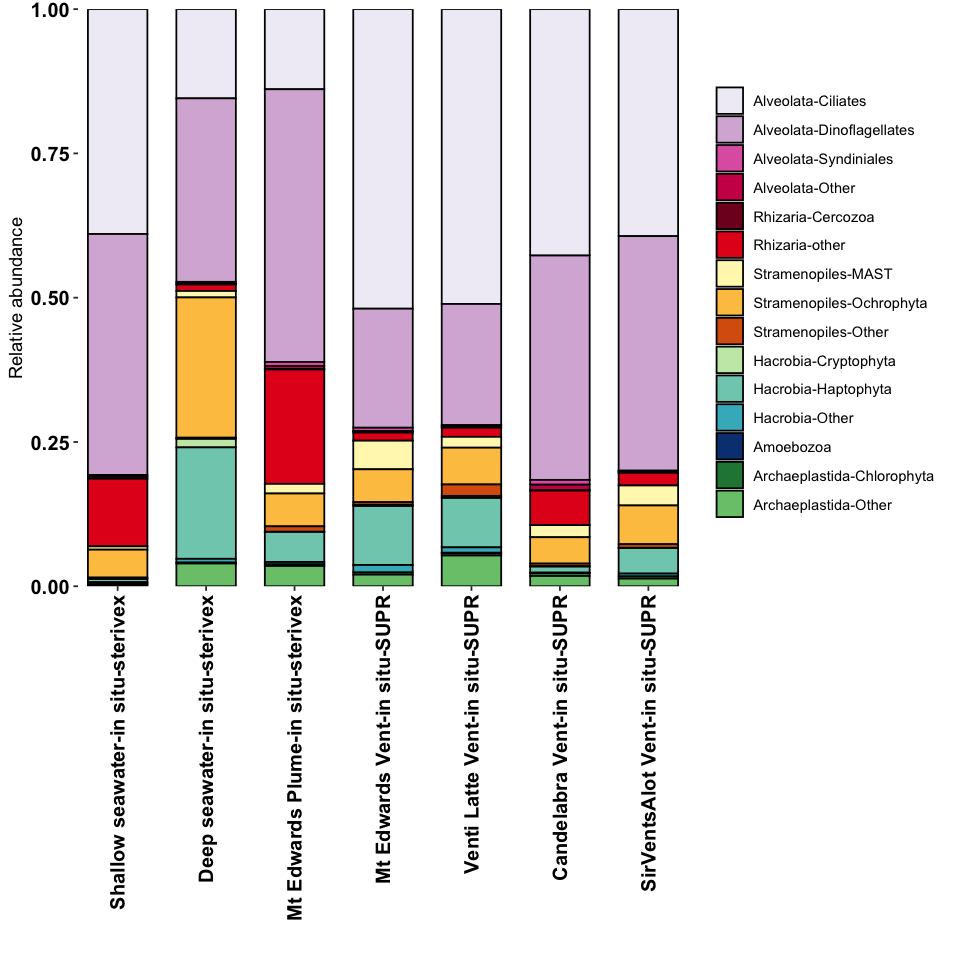

In [51]:
# Figure generatation
options(repr.plot.width = 8, repr.plot.height = 8)

insitu <- c("sterivex", "SUPR")
rm <- c("Unassigned", "Opisthokonta-Other", "Opisthokonta-Fungi", "Opisthokonta-Metazoa")

# svg("GR-insitu-tax.svg", w = 8, h = 8)
barplot_lev2(filter(gr_counts_avg_TAXA, (SAMPLEID %in% insitu & !(Taxa %in% rm))))
# dev.off()

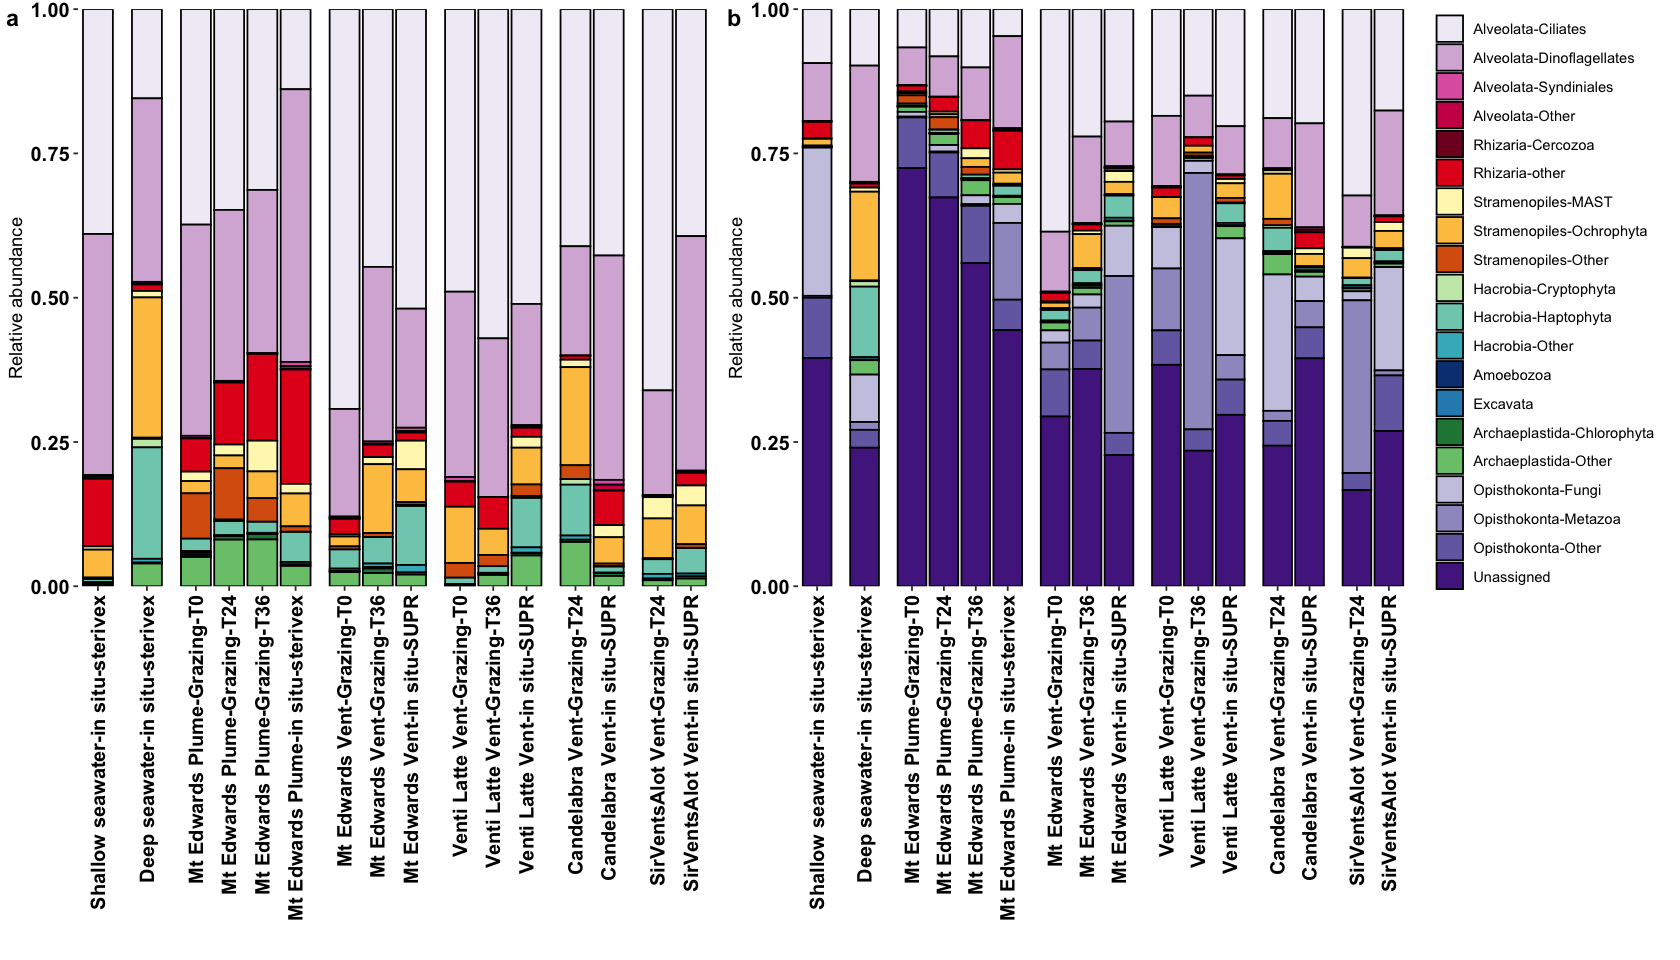

In [58]:
# Figure generation
options(repr.plot.width = 14, repr.plot.height = 8)

insitu <- c("sterivex", "SUPR")
rm <- c("Unassigned", "Opisthokonta-Other", "Opisthokonta-Fungi", "Opisthokonta-Metazoa")

# svg("GR-all-tax-supplementary.svg", w = 14, h = 8)
plot_grid(
    barplot_lev2(filter(gr_counts_avg_TAXA, !(Taxa %in% rm))) + theme(legend.position = "none"),
        barplot_lev2(filter(gr_counts_avg_TAXA)),
        ncol = 2, rel_widths = c(0.75,1), labels = c("a", "b"))
# dev.off()

## Ordination analysis - PCoA

In [315]:
load("data-input/GordaRidge-ASVtable-avg-22-07-2020.RData")
library(reshape2); 
library(vegan); 
library(dplyr)
library(ade4); 
library(compositions); 
library(tidyverse)
library(purrr)
library(cluster)
library(RColorBrewer)
library(ape)

# Remove controls
gr_counts_allsamples <- subset(counts_decont, !(SAMPLEID == "CTRL"))
gr_nums <- gr_counts_allsamples[, c("Feature.ID", "SAMPLE", "COUNT")]
tax <- gr_counts_allsamples[, c("Feature.ID", "Taxon")]
unique(gr_nums$SAMPLE)
gr_nums_filter <- subset(gr_nums, !(SAMPLE == "GordaRidge_BSW020_sterivex_2019_REPa"))
gr_nums_wide <- dcast(gr_nums_filter, Feature.ID~SAMPLE, fill=0)
row.names(gr_nums_wide)<-gr_nums_wide$Feature.ID; gr_nums_wide$Feature.ID<-NULL

[1] "GordaRidge_Vent090_T24_2019"           
 [2] "GordaRidge_BSW020_sterivex_2019_REPa"  
 [3] "GordaRidge_BSW056_sterivex_2019_REPb"  
 [4] "GordaRidge_BSW081_sterivex_2019"       
 [5] "GordaRidge_Plume001_sterivex_2019_REPa"
 [6] "GordaRidge_Plume001_sterivex_2019_REPb"
 [7] "GordaRidge_Plume001_T0_2019_REP12"     
 [8] "GordaRidge_Plume001_T0_2019_REP34"     
 [9] "GordaRidge_Plume001_T24_2019_REP12"    
[10] "GordaRidge_Plume001_T36_2019_REP12"    
[11] "GordaRidge_Plume036_sterivex_2019_REPb"
[12] "GordaRidge_Plume096_sterivex_2019"     
[13] "GordaRidge_Vent009_SUPRS1_2019"        
[14] "GordaRidge_Vent010_SUPRS2_2019"        
[15] "GordaRidge_Vent011_SUPRS3_2019"        
[16] "GordaRidge_Vent013_T0_2019_REP13"      
[17] "GordaRidge_Vent013_T36_2019_REP12"     
[18] "GordaRidge_Vent013_T36_2019_REP34"     
[19] "GordaRidge_Vent039_SUPRS1_2019"        
[20] "GordaRidge_Vent040_SUPRS2_2019"        
[21] "GordaRidge_Vent041_SUPRS3_2019"        
[22] "GordaRidge_Vent043_T0_2019_REP13"      
[23] "GordaRidge_Vent043_T36_2019_REP13"     
[24] "GordaRidge_Vent086_SUPRS1_2019"        
[25] "GordaRidge_Vent087_SUPRS2_2019"        
[26] "GordaRidge_Vent088_SUPRS3_2019"        
[27] "GordaRidge_Vent105_SUPRS9_2019"        
[28] "GordaRidge_Vent106_SUPRS10_2019"       
[29] "GordaRidge_Vent107_SUPRS11_2019"       
[30] "GordaRidge_Vent110_T24_2019"

Using COUNT as value column: use value.var to override.



[1] 0.07925836 0.07736303 0.06910714 0.05734696 0.05188187 0.04898675

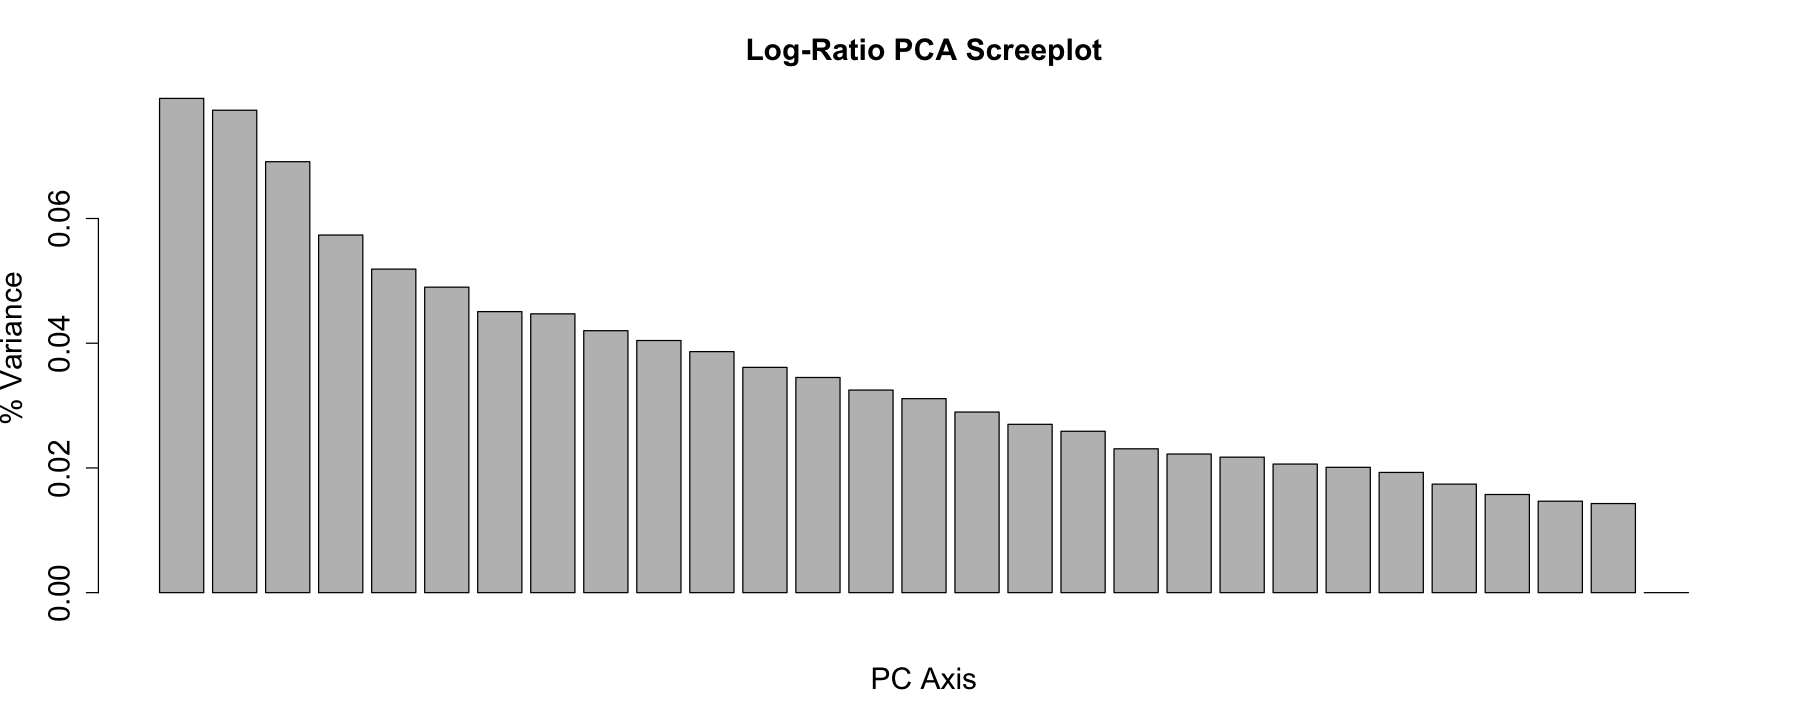

In [365]:
# Transform data
# Log-ratio
log_rats<-data.frame(compositions::clr(t(gr_nums_wide)))

# look at eigenvalues
pca_lr <- prcomp(log_rats)
variance_lr <- (pca_lr$sdev^2)/sum(pca_lr$sdev^2)
head(variance_lr)
barplot(variance_lr,
        main='Log-Ratio PCA Screeplot',
        xlab='PC Axis',
        ylab='% Variance',
        cex.names=1.5,cex.axis=1.5,cex.lab=1.5,cex.main=1.5)
# Based on this screeplot - 2 axis are OK, as they show 0.079 and 0.077, respectively, of the variance.

In [317]:
# Extract PCA and plot
pca_lr_frame<-data.frame(pca_lr$x,SAMPLE=rownames(pca_lr$x))
# head(pca_lr_frame)
x <- colsplit(pca_lr_frame$SAMPLE, "_", c("DATASET", "LOCATION", "SAMPLEID", "YEAR", "REP")); pca_lr_frame <- data.frame(x, pca_lr_frame)
head(pca_lr_frame)
ventnames <- read.delim("data-input/ventnames-gordaridge.txt")
names(ventnames);head(ventnames)
# View(ventnames)
colnames(ventnames)[1]<-"SAMPLE"
#
pca_lr_frame_wNames <- left_join(pca_lr_frame, ventnames, by="SAMPLE")
head(pca_lr_frame_wNames)
#
unique(pca_lr_frame_wNames$LocationName)
sample_order <- c('Mt Edwards Plume','Mt Edwards Vent','Candelabra Vent','SirVentsAlot Vent','Venti Latte Vent','Deep seawater', 'Shallow seawater')
sample_color <-c("lightblue","#377eb8", "#e41a1c", "#4daf4a", "#984ea3", "orange", "yellow")
pca_lr_frame_wNames$SAMPLE_ORDER <- factor(pca_lr_frame_wNames$LocationName, levels = rev(sample_order))
names(sample_color)<-sample_order
head(pca_lr_frame_wNames)
#

DATASET    LOCATION SAMPLEID YEAR REP  
GordaRidge_BSW056_sterivex_2019_REPb   GordaRidge BSW056   sterivex 2019 REPb 
GordaRidge_BSW081_sterivex_2019        GordaRidge BSW081   sterivex 2019      
GordaRidge_Plume001_sterivex_2019_REPa GordaRidge Plume001 sterivex 2019 REPa 
GordaRidge_Plume001_sterivex_2019_REPb GordaRidge Plume001 sterivex 2019 REPb 
GordaRidge_Plume001_T0_2019_REP12      GordaRidge Plume001 T0       2019 REP12
GordaRidge_Plume001_T0_2019_REP34      GordaRidge Plume001 T0       2019 REP34
                                       PC1        PC2        PC3       
GordaRidge_BSW056_sterivex_2019_REPb    11.709389  -4.704151   2.737196
GordaRidge_BSW081_sterivex_2019         15.878746 -18.812480 -35.528861
GordaRidge_Plume001_sterivex_2019_REPa -11.359841  10.619441  -5.567615
GordaRidge_Plume001_sterivex_2019_REPb  -9.989269   8.590890  -5.787346
GordaRidge_Plume001_T0_2019_REP12       -9.727408   3.212840  -7.166445
GordaRidge_Plume001_T0_2019_REP34      -10.501124   4.961117  -8.027975
                                       PC4       PC5        ⋯ PC21      
GordaRidge_BSW056_sterivex_2019_REPb   -8.950505  0.7717585 ⋯ -0.8848246
GordaRidge_BSW081_sterivex_2019        14.460101 16.5079805 ⋯ -0.2628994
GordaRidge_Plume001_sterivex_2019_REPa -3.120014 -3.3694670 ⋯ -0.5832622
GordaRidge_Plume001_sterivex_2019_REPb -3.182868 -3.6106845 ⋯ -0.7789751
GordaRidge_Plume001_T0_2019_REP12      -5.286687 -2.1055426 ⋯  2.2891633
GordaRidge_Plume001_T0_2019_REP34      -5.691631 -3.7971881 ⋯  2.2923028
                                       PC22          PC23        PC24       
GordaRidge_BSW056_sterivex_2019_REPb    -0.362220416   0.1259532  0.92987160
GordaRidge_BSW081_sterivex_2019         -0.002304058   0.2914215 -0.05225868
GordaRidge_Plume001_sterivex_2019_REPa  -7.039405724  16.7965382  2.43917307
GordaRidge_Plume001_sterivex_2019_REPb   8.525827574 -18.2427468 -1.14877416
GordaRidge_Plume001_T0_2019_REP12      -11.157809340  -6.4437809 19.10665387
GordaRidge_Plume001_T0_2019_REP34       20.061086812   8.2909583  1.41185873
                                       PC25       PC26      PC27       
GordaRidge_BSW056_sterivex_2019_REPb    0.0551194 -1.108406 -0.62564722
GordaRidge_BSW081_sterivex_2019        -0.1909242 -1.079920  0.09384105
GordaRidge_Plume001_sterivex_2019_REPa -0.9107024  1.711047 -0.53084618
GordaRidge_Plume001_sterivex_2019_REPb  0.1494977 -1.149185  0.26791409
GordaRidge_Plume001_T0_2019_REP12      -4.1461793 -1.588999 -3.13147931
GordaRidge_Plume001_T0_2019_REP34       1.5929407 -1.101488 -1.76430123
                                       PC28       PC29         
GordaRidge_BSW056_sterivex_2019_REPb    0.7323156 -6.130946e-15
GordaRidge_BSW081_sterivex_2019        -0.2252023  1.383173e-13
GordaRidge_Plume001_sterivex_2019_REPa -0.5753389  3.730349e-14
GordaRidge_Plume001_sterivex_2019_REPb -0.2838290  1.212875e-14
GordaRidge_Plume001_T0_2019_REP12      -1.8965622 -2.953367e-15
GordaRidge_Plume001_T0_2019_REP34      -1.1791502 -1.345452e-14
                                       SAMPLE                                
GordaRidge_BSW056_sterivex_2019_REPb   GordaRidge_BSW056_sterivex_2019_REPb  
GordaRidge_BSW081_sterivex_2019        GordaRidge_BSW081_sterivex_2019       
GordaRidge_Plume001_sterivex_2019_REPa GordaRidge_Plume001_sterivex_2019_REPa
GordaRidge_Plume001_sterivex_2019_REPb GordaRidge_Plume001_sterivex_2019_REPb
GordaRidge_Plume001_T0_2019_REP12      GordaRidge_Plume001_T0_2019_REP12     
GordaRidge_Plume001_T0_2019_REP34      GordaRidge_Plume001_T0_2019_REP34

[1] "SAMPLENAME"        "LOCATION"          "LOCATION_SPECIFIC"
[4] "SAMPLEID"          "Sampletype"        "LocationName"     
[7] "Sample_or_Control" "Sample_or_BSW"

SAMPLENAME                         LOCATION       LOCATION_SPECIFIC SAMPLEID
1 Axial_ExtractControl_CTRL_2019     ExtractControl ExtractControl    CTRL    
2 GordaRidge_Plume001_T0_2019_REP12  GordaRidge     Plume001          T0      
3 GordaRidge_Plume001_T24_2019_REP12 GordaRidge     Plume001          T24     
4 GordaRidge_Plume001_T36_2019_REP12 GordaRidge     Plume001          T36     
5 GordaRidge_Vent013_T0_2019_REP13   GordaRidge     Vent013           T0      
6 GordaRidge_Vent013_T36_2019_REP12  GordaRidge     Vent013           T36     
  Sampletype LocationName     Sample_or_Control Sample_or_BSW
1 Control    Lab blank        Control Sample    Control      
2 Grazing    Mt Edwards Plume True Sample       True Sample  
3 Grazing    Mt Edwards Plume True Sample       True Sample  
4 Grazing    Mt Edwards Plume True Sample       True Sample  
5 Grazing    Mt Edwards Vent  True Sample       True Sample  
6 Grazing    Mt Edwards Vent  True Sample       True Sample

DATASET    LOCATION.x SAMPLEID.x YEAR REP   PC1        PC2        PC3       
1 GordaRidge BSW056     sterivex   2019 REPb   11.709389  -4.704151   2.737196
2 GordaRidge BSW081     sterivex   2019        15.878746 -18.812480 -35.528861
3 GordaRidge Plume001   sterivex   2019 REPa  -11.359841  10.619441  -5.567615
4 GordaRidge Plume001   sterivex   2019 REPb   -9.989269   8.590890  -5.787346
5 GordaRidge Plume001   T0         2019 REP12  -9.727408   3.212840  -7.166445
6 GordaRidge Plume001   T0         2019 REP34 -10.501124   4.961117  -8.027975
  PC4       PC5        ⋯ PC28       PC29         
1 -8.950505  0.7717585 ⋯  0.7323156 -6.130946e-15
2 14.460101 16.5079805 ⋯ -0.2252023  1.383173e-13
3 -3.120014 -3.3694670 ⋯ -0.5753389  3.730349e-14
4 -3.182868 -3.6106845 ⋯ -0.2838290  1.212875e-14
5 -5.286687 -2.1055426 ⋯ -1.8965622 -2.953367e-15
6 -5.691631 -3.7971881 ⋯ -1.1791502 -1.345452e-14
  SAMPLE                                 LOCATION.y LOCATION_SPECIFIC
1 GordaRidge_BSW056_sterivex_2019_REPb   GordaRidge BSW056           
2 GordaRidge_BSW081_sterivex_2019        GordaRidge BSW081           
3 GordaRidge_Plume001_sterivex_2019_REPa GordaRidge Plume001         
4 GordaRidge_Plume001_sterivex_2019_REPb GordaRidge Plume001         
5 GordaRidge_Plume001_T0_2019_REP12      GordaRidge Plume001         
6 GordaRidge_Plume001_T0_2019_REP34      GordaRidge Plume001         
  SAMPLEID.y Sampletype LocationName     Sample_or_Control Sample_or_BSW
1 sterivex   in situ    Deep seawater    True Sample       BSW          
2 sterivex   in situ    Shallow seawater True Sample       BSW          
3 sterivex   in situ    Mt Edwards Plume True Sample       True Sample  
4 sterivex   in situ    Mt Edwards Plume True Sample       True Sample  
5 T0         Grazing    Mt Edwards Plume True Sample       True Sample  
6 T0         Grazing    Mt Edwards Plume True Sample       True Sample

[1] Deep seawater     Shallow seawater  Mt Edwards Plume  Mt Edwards Vent  
[5] Venti Latte Vent  Candelabra Vent   SirVentsAlot Vent
9 Levels: Candelabra Vent Deep seawater Lab blank ... Venti Latte Vent

DATASET    LOCATION.x SAMPLEID.x YEAR REP   PC1        PC2        PC3       
1 GordaRidge BSW056     sterivex   2019 REPb   11.709389  -4.704151   2.737196
2 GordaRidge BSW081     sterivex   2019        15.878746 -18.812480 -35.528861
3 GordaRidge Plume001   sterivex   2019 REPa  -11.359841  10.619441  -5.567615
4 GordaRidge Plume001   sterivex   2019 REPb   -9.989269   8.590890  -5.787346
5 GordaRidge Plume001   T0         2019 REP12  -9.727408   3.212840  -7.166445
6 GordaRidge Plume001   T0         2019 REP34 -10.501124   4.961117  -8.027975
  PC4       PC5        ⋯ PC29          SAMPLE                                
1 -8.950505  0.7717585 ⋯ -6.130946e-15 GordaRidge_BSW056_sterivex_2019_REPb  
2 14.460101 16.5079805 ⋯  1.383173e-13 GordaRidge_BSW081_sterivex_2019       
3 -3.120014 -3.3694670 ⋯  3.730349e-14 GordaRidge_Plume001_sterivex_2019_REPa
4 -3.182868 -3.6106845 ⋯  1.212875e-14 GordaRidge_Plume001_sterivex_2019_REPb
5 -5.286687 -2.1055426 ⋯ -2.953367e-15 GordaRidge_Plume001_T0_2019_REP12     
6 -5.691631 -3.7971881 ⋯ -1.345452e-14 GordaRidge_Plume001_T0_2019_REP34     
  LOCATION.y LOCATION_SPECIFIC SAMPLEID.y Sampletype LocationName    
1 GordaRidge BSW056            sterivex   in situ    Deep seawater   
2 GordaRidge BSW081            sterivex   in situ    Shallow seawater
3 GordaRidge Plume001          sterivex   in situ    Mt Edwards Plume
4 GordaRidge Plume001          sterivex   in situ    Mt Edwards Plume
5 GordaRidge Plume001          T0         Grazing    Mt Edwards Plume
6 GordaRidge Plume001          T0         Grazing    Mt Edwards Plume
  Sample_or_Control Sample_or_BSW SAMPLE_ORDER    
1 True Sample       BSW           Deep seawater   
2 True Sample       BSW           Shallow seawater
3 True Sample       True Sample   Mt Edwards Plume
4 True Sample       True Sample   Mt Edwards Plume
5 True Sample       True Sample   Mt Edwards Plume
6 True Sample       True Sample   Mt Edwards Plume

In [354]:
library(ggrepel)
options(repr.plot.width = 8, repr.plot.height = 8)

# svg("PCA-wlabels-gr-22-07-2020.svg", w=8, h=8)
pca_18s <- ggplot(pca_lr_frame_wNames, aes(x=PC1,y=PC2,fill=LocationName,shape=Sampletype, label=LOCATION_SPECIFIC))+ #Replace label=SAMPLEID.y
  geom_point(aes(x=PC1,y=PC2,fill=LocationName), size=5)+
  scale_fill_manual(values = sample_color)+
  ylab(paste0('PC2 ',round(variance_lr[2]*100,2),'%'))+
  xlab(paste0('PC1 ',round(variance_lr[1]*100,2),'%'))+
  scale_shape_manual(values = c(23,21))+
  ggtitle('CLR PCA Ordination')+
#   coord_fixed(ratio=variance_lr[2]/variance_lr[1])+
  theme_bw()+
  geom_text_repel()+
  theme(axis.text = element_text(color="black", size=12))+
  geom_hline(yintercept = 0) + geom_vline(xintercept = 0)
# dev.off()

## Repeat PCA with 16S rRNA gene results

In [309]:
# Import and process 16S ASV table
ventnames_16 <- read.delim("data-input/ventnames-gordaridge-16S.txt")
countbac <- read.delim("data-input/CountTable-wtax-16s-plus3-2020-06-23.txt")
countbac_df <- countbac %>%
  separate(Taxon, sep = ";D_[[:digit:]]__", into = c("Domain", "Phylum", "Class", "Order", "Family", "Genus", "Species"), remove = TRUE, extra = "merge") %>% # Warnings are OK with NAs
  mutate_if(is.character, str_replace_all, pattern = "D_0__", replacement = "") %>%
  column_to_rownames(var = "Feature.ID") %>%
  data.frame
# Warnings are OK because not all levels fill out taxa spaces
head(countbac_df[1:3,])
# Total ASVs and sequences:
count_summary <- countbac_df %>%
  select(starts_with("NA")) %>% 
  data.frame
head(count_summary[1:2,])
sum(count_summary) # total sequences
dim(count_summary)[1] # total ASVs

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 4292 rows [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 19, 20, 23, 25, 26, ...].”


NA08051STEP NA108001aSTEP NA108001bSTEP
139ad7417ef0dfb630699faea2eb5e06 619         1179          2971         
4ebf60eae6a25de1f7fb819ff212141c 359          847           795         
a900b6678ce86851fb16bfafb87f3326 261          463           368         
                                 NA108003STEP NA108003STEP20200226 NA108009STEP
139ad7417ef0dfb630699faea2eb5e06 5252         6931                  0          
4ebf60eae6a25de1f7fb819ff212141c 4076         4644                  0          
a900b6678ce86851fb16bfafb87f3326 2275         2545                 21          
                                 NA108010STEP NA108012STEP NA108020aSTEP
139ad7417ef0dfb630699faea2eb5e06 155          677          3921         
4ebf60eae6a25de1f7fb819ff212141c  43          158          4445         
a900b6678ce86851fb16bfafb87f3326   8           96          2471         
                                 NA108020bSTEP ⋯ NA108108STEP NA108109STEP
139ad7417ef0dfb630699faea2eb5e06 3937          ⋯ 3596         229         
4ebf60eae6a25de1f7fb819ff212141c 2764          ⋯ 2640          88         
a900b6678ce86851fb16bfafb87f3326 1844          ⋯ 1089          24         
                                 Domain   Phylum         Class              
139ad7417ef0dfb630699faea2eb5e06 Archaea  Thaumarchaeota Nitrososphaeria    
4ebf60eae6a25de1f7fb819ff212141c Bacteria Proteobacteria Deltaproteobacteria
a900b6678ce86851fb16bfafb87f3326 Bacteria Proteobacteria Gammaproteobacteria
                                 Order                        Family           
139ad7417ef0dfb630699faea2eb5e06 Nitrosopumilales             Nitrosopumilaceae
4ebf60eae6a25de1f7fb819ff212141c SAR324 clade(Marine group B) NA               
a900b6678ce86851fb16bfafb87f3326 Thiomicrospirales            Thioglobaceae    
                                 Genus                     
139ad7417ef0dfb630699faea2eb5e06 uncultured marine archaeon
4ebf60eae6a25de1f7fb819ff212141c NA                        
a900b6678ce86851fb16bfafb87f3326 SUP05 cluster             
                                 Species                    Confidence
139ad7417ef0dfb630699faea2eb5e06 uncultured marine archaeon 0.8614500 
4ebf60eae6a25de1f7fb819ff212141c NA                         0.9999994 
a900b6678ce86851fb16bfafb87f3326 NA                         0.9374621

NA08051STEP NA108001aSTEP NA108001bSTEP
139ad7417ef0dfb630699faea2eb5e06 619         1179          2971         
4ebf60eae6a25de1f7fb819ff212141c 359          847           795         
                                 NA108003STEP NA108003STEP20200226 NA108009STEP
139ad7417ef0dfb630699faea2eb5e06 5252         6931                 0           
4ebf60eae6a25de1f7fb819ff212141c 4076         4644                 0           
                                 NA108010STEP NA108012STEP NA108020aSTEP
139ad7417ef0dfb630699faea2eb5e06 155          677          3921         
4ebf60eae6a25de1f7fb819ff212141c  43          158          4445         
                                 NA108020bSTEP ⋯ NA108081STEP NA108087STEP
139ad7417ef0dfb630699faea2eb5e06 3937          ⋯ 672          161         
4ebf60eae6a25de1f7fb819ff212141c 2764          ⋯ 359          283         
                                 NA108087STEP20200226 NA108089STEP NA108096STEP
139ad7417ef0dfb630699faea2eb5e06 254                  1932         1989        
4ebf60eae6a25de1f7fb819ff212141c 360                  1073         2100        
                                 NA108100STEP NA108102STEP NA108106STEP
139ad7417ef0dfb630699faea2eb5e06 297          103          3933        
4ebf60eae6a25de1f7fb819ff212141c 151          186          1828        
                                 NA108108STEP NA108109STEP
139ad7417ef0dfb630699faea2eb5e06 3596         229         
4ebf60eae6a25de1f7fb819ff212141c 2640          88

[1] 1354212

[1] 6532

In [311]:
## Create new column in ASV table that reports if an ASV is present in any of the background seawater samples
# head(countbac_df[1:2,]); names(countbac_df)
### Select BSW only samples and make character list:
bsw_samples <- ventnames_16 %>% 
  filter(LocationName == "Deep seawater" | LocationName == "Shallow seawater") %>% 
  select(SAMPLEID_16S) %>%
  data.frame
bsw_samples <- as.character(unique(bsw_samples$SAMPLEID_16S))
bsw_samples
# Create new df with bsw ASVs labeled
sub_bsw_df <- countbac_df %>%
  rownames_to_column(var = "Feature.ID") %>% 
  select(Feature.ID, all_of(bsw_samples)) %>%
  mutate(sum = rowSums(select_if(., is.numeric))) %>% 
  filter(sum > 0) %>% 
  add_column(bsw_presence = "present in bsw") %>% 
  select(Feature.ID, bsw_presence) %>% 
  data.frame
# head(sub_bsw_df)
# unique(sub_bsw_df$bsw_presence)

# Add to original ASV table
countbac_df_cat <- countbac_df %>% 
  rownames_to_column(var = "Feature.ID") %>% 
  left_join(sub_bsw_df) %>%
  mutate(bsw_presence = replace_na(bsw_presence, "vent only")) %>% 
  select(-Confidence) %>% 
  mutate(ASV_SUM_ALL = rowSums(select_if(., is.numeric))) %>% 
  mutate(ASV_REL_ABUN = 100*(ASV_SUM_ALL/sum(ASV_SUM_ALL))) %>%
  # filter(ASV_REL_ABUN > ##) %>%  #Filter by rel abun
  data.frame
# head(countbac_df_cat)

[1] "NA108003STEP"         "NA108003STEP20200226" "NA108020aSTEP"       
[4] "NA108020bSTEP"        "NA108056aSTEP"        "NA108056bSTEP"       
[7] "NA108081STEP"         "NA108102STEP"

Joining, by = "Feature.ID"



In [312]:
## Ordination analysis
# Remove samples that were repeated
rm <- c("NA108003STEP", "NA108039STEP", "NA108087STEP")

# Filtering count table data:
df_start <- countbac_df_cat %>% 
  filter(Domain %in% "Archaea" | Domain %in% "Bacteria") %>% #Select only archaea and bacteria, removing unassigned
  select(-all_of(rm)) %>% # Remove samples we are replacing
  # Could include other filtering options if necessary
  select(Feature.ID, starts_with("NA108")) %>% 
  data.frame

# Prep data so it is ready for data transformations and more
df_format <- df_start %>% 
  column_to_rownames(var = "Feature.ID") %>% 
  as.matrix
# class(df_format)

# Log-Ratio
library(compositions)
df_log_clr <- data.frame(clr(t(df_format)))

# Ordination - PCA
# ?prcomp()
pca_clr <- prcomp(df_log_clr)

[1] 0.19784655 0.09829454 0.06235569 0.05964675 0.05286800 0.04712484

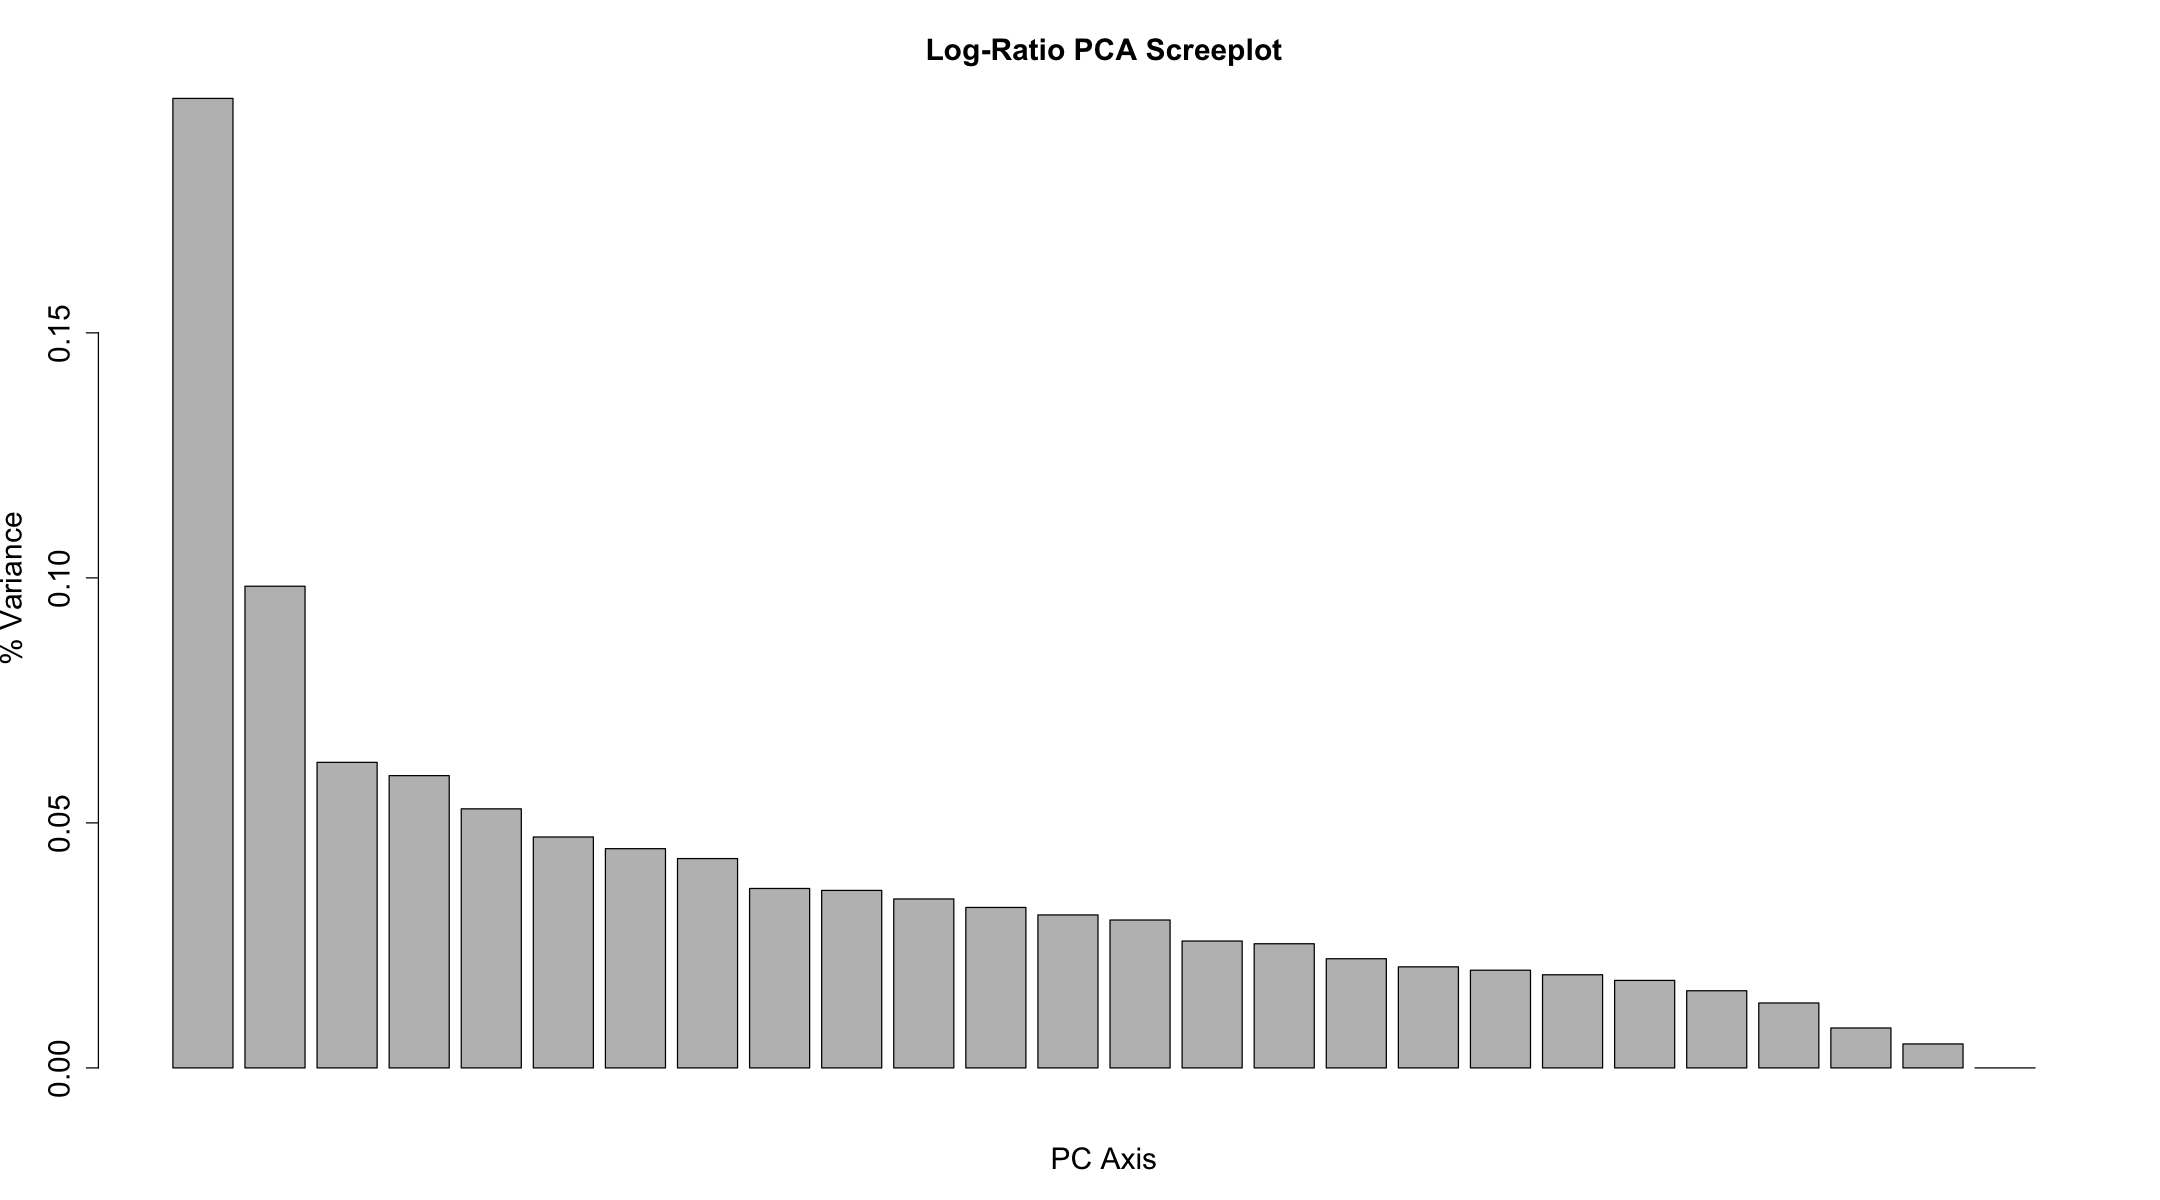

In [313]:
# Check variance
check_variance <- (pca_clr$sdev^2)/sum(pca_clr$sdev^2)
head(check_variance)
# Screeplot, how many axes are appropriate?
barplot(check_variance,
        main='Log-Ratio PCA Screeplot',
        xlab='PC Axis',
        ylab='% Variance',
        cex.names=1.5,cex.axis=1.5,cex.lab=1.5,cex.main=1.5)

In [330]:
head(ventnames_16)

SAMPLEID_16S         SAMPLE_AMY               Sampletype SAMPLEID
1 NA080051STEP         SUPR BAG Purple Rain     in situ    SUPR    
2 NA108001aSTEP        Niskin Plume Mt. Edwards in situ    sterivex
3 NA108001bSTEP        Niskin Plume Mt. Edwards in situ    sterivex
4 NA108003STEP         Niskin BSW               in situ    sterivex
5 NA108003STEP20200226 Niskin BSW               in situ    sterivex
6 NA108009STEP         SUPR Filter Mt. Edwards  in situ    SUPR    
  LocationName     STATUS FLUIDORIGIN
1 Purple Rain Vent keep   S9         
2 Mt Edwards Plume keep   Niskin7    
3 Mt Edwards Plume keep   Niskin7    
4 Deep seawater    old    Niskin10   
5 Deep seawater    keep   Niskin10   
6 Mt Edwards Vent  keep   S1

In [348]:
ventnames_16_mod <- ventnames_16 %>% 
    mutate(location = case_when(
        grepl("Plume", SAMPLE_AMY) ~ "Plume",
        grepl("BSW", SAMPLE_AMY) ~ "BSW", 
        grepl("Vent", LocationName) ~ "Vent"),
          NA_NUM = SAMPLEID_16S) %>% 
    mutate(NA_NUM = str_replace(NA_NUM, "NA108", "")) %>%
    mutate(NA_NUM = str_replace(NA_NUM, "NA080", "")) %>% 
    mutate(NA_NUM = str_replace(NA_NUM, "aSTEP", "")) %>% 
    mutate(NA_NUM = str_replace(NA_NUM, "bSTEP", "")) %>% 
    mutate(NA_NUM = str_replace(NA_NUM, "STEP20200226", "")) %>% 
    mutate(NA_NUM = str_replace(NA_NUM, "STEP", "")) %>% 
    unite(NEW_SAMPLEID, location, NA_NUM, sep ="") %>% 
    data.frame
# ventnames_16_mod

In [355]:
# Make dataframe of PCoA variables and import vent names
sample_order <- c('Mt Edwards Plume','Mt Edwards Vent','Candelabra Vent','SirVentsAlot Vent','Venti Latte Vent','Deep seawater', 'Shallow seawater')
df_pca_clr <- data.frame(pca_clr$x, SAMPLEID_16S = rownames(pca_clr$x))

df_pca_clr_wnames <- df_pca_clr %>% 
  left_join(ventnames_16_mod) %>% 
  filter(LocationName %in% sample_order) %>% 
  data.frame

# head(df_pca_clr_wnames[1:2,])

# unique(df_pca_clr_wnames$LocationName)
sample_order <- c('Mt Edwards Plume','Mt Edwards Vent','Candelabra Vent','SirVentsAlot Vent','Venti Latte Vent','Deep seawater', 'Shallow seawater')
sample_color <-c("lightblue","#377eb8", "#e41a1c", "#4daf4a", "#984ea3", "orange", "yellow")
df_pca_clr_wnames$SAMPLE_ORDER <- factor(df_pca_clr_wnames$LocationName, levels = rev(sample_order))
names(sample_color)<-sample_order

library(ggrepel)
# head(df_pca_clr_wnames[1:2,])

options(repr.plot.width = 8, repr.plot.height = 6)

# svg("PCoA-16S-wolabels.svg", h = 8, w = 8)
# ggplot(df_pca_clr_wnames, aes(x = PC1, y = PC2, fill = SAMPLE_ORDER)) +
pca_16s <- ggplot(df_pca_clr_wnames, aes(x = PC1, y = PC2, fill = SAMPLE_ORDER, label = NEW_SAMPLEID)) +
  geom_point(aes(x = PC1,y = PC2, fill = LocationName), size = 4, shape = 21) +
  scale_fill_manual(values = sample_color) +
  ylab(paste0('PC2 ',round(check_variance[2]*100,2),'%')) +
  xlab(paste0('PC1 ',round(check_variance[1]*100,2),'%')) +
  ggtitle('16S - CLR PCA Ordination') +
  # scale_x_continuous(limits = c(-15, 36)) +
  # scale_y_continuous(limits = c(-23, 15)) +
#   coord_fixed(ratio=variance_lr[2]/variance_lr[1])+
  geom_text_repel() +
  theme_bw() +
  theme(axis.text = element_text(color = "black", size = 12)) +
  geom_hline(yintercept = 0) + geom_vline(xintercept = 0)
# w=630, h=430

Joining, by = "SAMPLEID_16S"



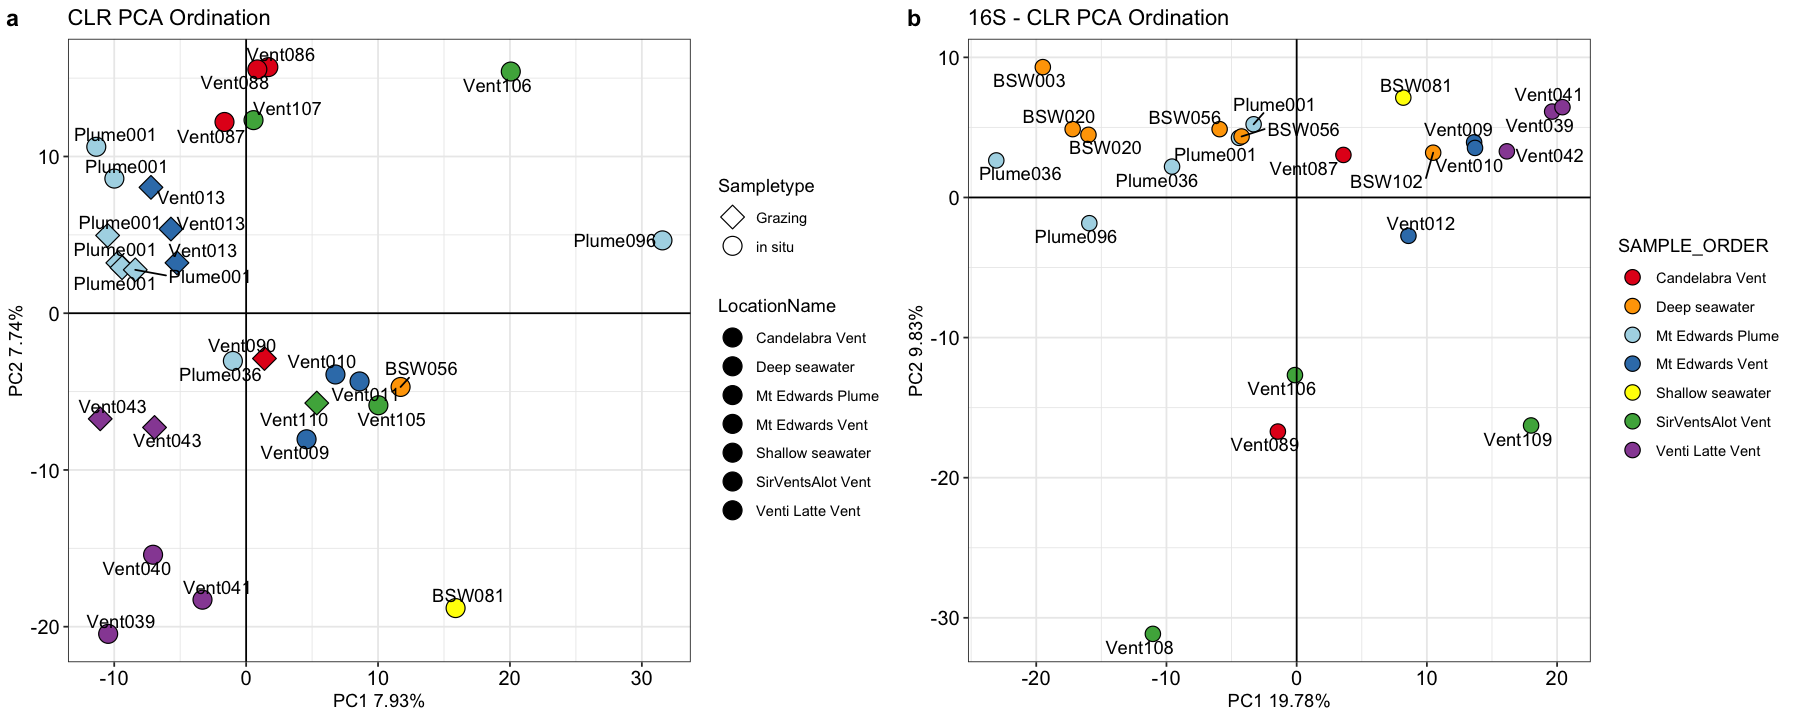

In [363]:
options(repr.plot.width = 15, repr.plot.height = 6)

# svg("panel-ordinations.svg", w = 15, h = 6)
plot_grid(pca_18s, pca_16s, nrow = 1, labels = c("a", "b"))
# dev.off()

# Classify 18S-derived ASVs by distribution in vent, plume, and background samples

In [72]:
load("data-input/GordaRidge-ASVtable-avg-22-07-2020.RData",verbose = T)
#
# Get binary info - lists from BSW, Plume, Vent, and Grazing
head(gr_counts_avg_wtax[1:2,])
unique(gr_counts_avg_wtax[, c("Sampletype", "LocationName")]) #categories to consider
bin_category <- gr_counts_avg_wtax[, c("Feature.ID", "Sampletype", "LocationName", "COUNT_AVG")]
bin_category$sample_tmp <- paste(bin_category$Sampletype, bin_category$LocationName, sep = "_")
bin_category$sample_tmp <- gsub(" ","_", bin_category$sample_tmp)
head(bin_category)
bin_category$Sampletype<-NULL; bin_category$LocationName <- NULL
head(bin_category)
#
library(reshape2)
bin_wide <- dcast(bin_category, Feature.ID ~ sample_tmp) #aggregate to length is OK - counts occurences
# View(bin_wide)
# row.names(bin_wide) <- bin_wide$Feature.ID; bin_wide$Feature.ID <- NULL
#
head(bin_wide)
# Iteratively select specific ASVs based on these conditions. Generate a new data frame - then these will be compiled
rm(asv_key)
#
shared_all <- bin_wide %>% 
  filter((in_situ_Shallow_seawater > 0 & 
            in_situ_Deep_seawater > 0 &
            in_situ_Mt_Edwards_Plume > 0 &
            Grazing_Mt_Edwards_Plume > 0 &
            in_situ_Mt_Edwards_Vent > 0 &
            Grazing_Mt_Edwards_Vent > 0 &
            in_situ_Venti_Latte_Vent > 0 &
            Grazing_Venti_Latte_Vent > 0 &
            in_situ_Candelabra_Vent > 0 &
            Grazing_Candelabra_Vent > 0 &
            in_situ_SirVentsAlot_Vent > 0 &
            Grazing_SirVentsAlot_Vent > 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY = "ASV present in all samples") %>%
  data.frame
dim(shared_all)
asv_key <- shared_all
#
bsw_only <- bin_wide %>% 
  filter((in_situ_Shallow_seawater > 0 & 
            in_situ_Deep_seawater > 0 &
            in_situ_Mt_Edwards_Plume == 0 &
            Grazing_Mt_Edwards_Plume == 0 &
            in_situ_Mt_Edwards_Vent == 0 &
            Grazing_Mt_Edwards_Vent == 0 &
            in_situ_Venti_Latte_Vent == 0 &
            Grazing_Venti_Latte_Vent == 0 &
            in_situ_Candelabra_Vent == 0 &
            Grazing_Candelabra_Vent == 0 &
            in_situ_SirVentsAlot_Vent == 0 &
            Grazing_SirVentsAlot_Vent == 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY = "BSW only") %>%
  data.frame
head(bsw_only); dim(bsw_only)
#
asv_key <- rbind(asv_key, bsw_only)
dim(asv_key)
#
shared_edwards <- bin_wide %>% 
  filter((in_situ_Shallow_seawater == 0 & 
            in_situ_Deep_seawater == 0 &
            in_situ_Mt_Edwards_Plume == 0 &
            Grazing_Mt_Edwards_Plume == 0 &
            in_situ_Mt_Edwards_Vent > 0 &
            Grazing_Mt_Edwards_Vent > 0 &
            in_situ_Venti_Latte_Vent == 0 &
            Grazing_Venti_Latte_Vent == 0 &
            in_situ_Candelabra_Vent == 0 &
            Grazing_Candelabra_Vent == 0 &
            in_situ_SirVentsAlot_Vent == 0 &
            Grazing_SirVentsAlot_Vent == 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY = "Shared between in situ vent and grazing exp") %>%
  data.frame
head(shared_edwards); dim(shared_edwards)
#
shared_edwards_wplume <- bin_wide %>% 
  filter((in_situ_Shallow_seawater == 0 & 
            in_situ_Deep_seawater == 0 &
            in_situ_Mt_Edwards_Plume > 0 &
            Grazing_Mt_Edwards_Plume > 0 &
            in_situ_Mt_Edwards_Vent == 0 &
            Grazing_Mt_Edwards_Vent == 0 &
            in_situ_Venti_Latte_Vent == 0 &
            Grazing_Venti_Latte_Vent == 0 &
            in_situ_Candelabra_Vent == 0 &
            Grazing_Candelabra_Vent == 0 &
            in_situ_SirVentsAlot_Vent == 0 &
            Grazing_SirVentsAlot_Vent == 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY = "Shared between in situ vent and grazing exp") %>%
  data.frame
head(shared_edwards_wplume); dim(shared_edwards_wplume)
#
shared_ventilatte <- bin_wide %>% 
  filter((in_situ_Shallow_seawater == 0 & 
            in_situ_Deep_seawater == 0 &
            in_situ_Mt_Edwards_Plume == 0 &
            Grazing_Mt_Edwards_Plume == 0 &
            in_situ_Mt_Edwards_Vent == 0 &
            Grazing_Mt_Edwards_Vent == 0 &
            in_situ_Venti_Latte_Vent > 0 &
            Grazing_Venti_Latte_Vent > 0 &
            in_situ_Candelabra_Vent == 0 &
            Grazing_Candelabra_Vent == 0 &
            in_situ_SirVentsAlot_Vent == 0 &
            Grazing_SirVentsAlot_Vent == 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY = "Shared between in situ vent and grazing exp") %>%
  data.frame
dim(shared_ventilatte)
#
shared_candelabra <- bin_wide %>% 
  filter((in_situ_Shallow_seawater == 0 & 
            in_situ_Deep_seawater == 0 &
            in_situ_Mt_Edwards_Plume == 0 &
            Grazing_Mt_Edwards_Plume == 0 &
            in_situ_Mt_Edwards_Vent == 0 &
            Grazing_Mt_Edwards_Vent == 0 &
            in_situ_Venti_Latte_Vent == 0 &
            Grazing_Venti_Latte_Vent == 0 &
            in_situ_Candelabra_Vent > 0 &
            Grazing_Candelabra_Vent > 0 &
            in_situ_SirVentsAlot_Vent == 0 &
            Grazing_SirVentsAlot_Vent == 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY = "Shared between in situ vent and grazing exp") %>%
  data.frame
dim(shared_candelabra)
#
shared_Sirventsalot <- bin_wide %>% 
  filter((in_situ_Shallow_seawater == 0 & 
            in_situ_Deep_seawater == 0 &
            in_situ_Mt_Edwards_Plume == 0 &
            Grazing_Mt_Edwards_Plume == 0 &
            in_situ_Mt_Edwards_Vent == 0 &
            Grazing_Mt_Edwards_Vent == 0 &
            in_situ_Venti_Latte_Vent == 0 &
            Grazing_Venti_Latte_Vent == 0 &
            in_situ_Candelabra_Vent == 0 &
            Grazing_Candelabra_Vent == 0 &
            in_situ_SirVentsAlot_Vent > 0 &
            Grazing_SirVentsAlot_Vent > 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY = "Shared between in situ vent and grazing exp") %>%
  data.frame
dim(shared_Sirventsalot)
#
# Identify ASVs which are unique to a sample
head(bin_wide[1:2,]);names(bin_wide)
tmp_bin <- bin_wide; tmp_bin$SUM <- rowSums(tmp_bin[, 2:13])
tmp_bin2 <- subset(tmp_bin, SUM == 1)
tmp_bin2$CATEGORY <- "Unique to sample"
head(tmp_bin2)
binned_unique <- tmp_bin2[, c("Feature.ID", "CATEGORY")]
length(unique(binned_unique$Feature.ID)); dim(binned_unique)
#
asv_key_2 <- rbind(asv_key, shared_edwards, shared_edwards_wplume, shared_ventilatte, shared_candelabra, shared_Sirventsalot, binned_unique)
dim(asv_key_2); length(unique(asv_key_2$Feature.ID))
#
appears_vent_plume <- bin_wide %>% 
  filter((in_situ_Shallow_seawater == 0 & 
            in_situ_Deep_seawater == 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY_appear = "Appears in situ vent or plume (not BSW)") %>%
  data.frame
dim(appears_vent_plume)
#
appears_vent <- bin_wide %>% 
  filter((in_situ_Shallow_seawater == 0 & 
            in_situ_Deep_seawater == 0 &
            in_situ_Mt_Edwards_Plume == 0 &
            Grazing_Mt_Edwards_Plume == 0)) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY_appear = "Appears in situ vent (not BSW or plume)") %>%
  data.frame
dim(appears_vent)
#
appears_deep <- bin_wide %>% 
  filter(((in_situ_Shallow_seawater == 0 & 
             in_situ_Deep_seawater > 0) &
            in_situ_Mt_Edwards_Plume > 0 |
            # Grazing_Mt_Edwards_Plume == 0 &
            in_situ_Mt_Edwards_Vent > 0 |
            # Grazing_Mt_Edwards_Vent == 0 &
            in_situ_Venti_Latte_Vent > 0 |
            # Grazing_Venti_Latte_Vent == 0 &
            in_situ_Candelabra_Vent > 0 |
            # Grazing_Candelabra_Vent == 0 &
            in_situ_SirVentsAlot_Vent > 0 #&
          # Grazing_SirVentsAlot_Vent == 0
  )) %>%
  select(Feature.ID) %>%
  distinct() %>%
  add_column(CATEGORY_appear = "Appears in deep BSW and among vent/plume sites") %>%
  data.frame
dim(appears_deep)

# Regardless of grazing experiment presence:
# Add in this order, will overwrite the previous entry.
dim(appears_deep) # ASV appears BSW and vent and plume
dim(appears_vent_plume) # no BSW, among plume and vent
dim(appears_vent) # no BSW or plume, among vent
#
dim(asv_key_2); unique(asv_key_2$CATEGORY)
#
head(bin_wide)
length(unique(bin_wide$Feature.ID)); dim(bin_wide)
#
# New data frame
asv_key_all <- data.frame(bin_wide[,c("Feature.ID")])
colnames(asv_key_all)[1] <- "Feature.ID"
head(asv_key_all)
deep <- as.character(unique(appears_deep$Feature.ID))
asv_key_all$SORTED[asv_key_all$Feature.ID %in% deep] = "ASV appears in BSW and throughout vent/plume"
vent_plume <- as.character(unique(appears_vent_plume$Feature.ID))
asv_key_all$SORTED[asv_key_all$Feature.ID %in% vent_plume] = "ASV appears among vent/plume (no BSW)"
vent <- as.character(unique(appears_vent$Feature.ID))
asv_key_all$SORTED[asv_key_all$Feature.ID %in% vent] = "ASV appears among vent (no BSW or plume)"
table(asv_key_all$SORTED)
#
asv_key_joined <- left_join(asv_key_all, asv_key_2)
head(asv_key_joined)
asv_key_joined_filled <- data.frame(asv_key_joined, (coalesce(asv_key_joined$CATEGORY, asv_key_joined$SORTED)))
colnames(asv_key_joined_filled)[4] <- "category_final"
table(asv_key_joined_filled$category_final)
# Replace NAs in category_final
asv_key_final <- asv_key_joined_filled[, c("Feature.ID", "category_final")]
str(asv_key_final)
asv_key_final$category_final <- as.character(asv_key_final$category_fina)
asv_key_final$category_final[is.na(asv_key_final$category_fina)] = "Other"
head(asv_key_final)

##  Combine with actual data frame
head(gr_counts_avg_wtax)
gr_sorted <- left_join(gr_counts_avg_wtax, asv_key_final)
head(gr_sorted)
table(gr_sorted$category_final)
#
# Stats
gr_sorted_summary <- gr_sorted %>%
  group_by(SAMPLEID, Sampletype, LocationName, category_final) %>%
  summarise(totalasv = n(), totalseq = sum(COUNT_AVG)) %>%
  data.frame
head(gr_sorted_summary[1:2,])
#
gr_stats <- gr_sorted_summary %>%
  group_by(category_final) %>%
  summarise(totalasvs = sum(totalasv), 
            sumseqs = sum(totalseq)) %>%
  data.frame
gr_stats <- gr_stats %>% mutate(percentseq = sumseqs/sum(sumseqs)*100)

Loading objects:
  gr_counts_filter
  gr_counts_wtax
  gr_counts_avg_wtax


Feature.ID                       SAMPLEID Sampletype LOCATION_SPECIFIC
1 0009645516609bda2246e1955ff9ec1d sterivex in situ    BSW081           
2 0030ad8ce44f257c42daf3673bf92197 sterivex in situ    BSW081           
  LocationName     Taxon     level1    level2     level3 level4 level5 level6
1 Shallow seawater Eukaryota Eukaryota Unassigned                            
2 Shallow seawater Eukaryota Eukaryota Unassigned                            
  level7 Taxa       COUNT_AVG
1        Unassigned 80       
2        Unassigned 36

Sampletype LocationName     
1  in situ    Shallow seawater 
3  in situ    Venti Latte Vent 
4  in situ    Candelabra Vent  
5  Grazing    SirVentsAlot Vent
6  in situ    Deep seawater    
8  in situ    Mt Edwards Plume 
12 in situ    SirVentsAlot Vent
13 Grazing    Mt Edwards Plume 
17 in situ    Mt Edwards Vent  
36 Grazing    Mt Edwards Vent  
40 Grazing    Candelabra Vent  
49 Grazing    Venti Latte Vent

Feature.ID                       Sampletype LocationName      COUNT_AVG
1 0009645516609bda2246e1955ff9ec1d in situ    Shallow seawater  80       
2 0030ad8ce44f257c42daf3673bf92197 in situ    Shallow seawater  36       
3 0030ad8ce44f257c42daf3673bf92197 in situ    Venti Latte Vent  12       
4 0030ad8ce44f257c42daf3673bf92197 in situ    Candelabra Vent   34       
5 0030ad8ce44f257c42daf3673bf92197 Grazing    SirVentsAlot Vent 15       
6 0038478be7fb4f097ce93a5e9341af2a in situ    Deep seawater     21       
  sample_tmp               
1 in_situ_Shallow_seawater 
2 in_situ_Shallow_seawater 
3 in_situ_Venti_Latte_Vent 
4 in_situ_Candelabra_Vent  
5 Grazing_SirVentsAlot_Vent
6 in_situ_Deep_seawater

Feature.ID                       COUNT_AVG sample_tmp               
1 0009645516609bda2246e1955ff9ec1d 80        in_situ_Shallow_seawater 
2 0030ad8ce44f257c42daf3673bf92197 36        in_situ_Shallow_seawater 
3 0030ad8ce44f257c42daf3673bf92197 12        in_situ_Venti_Latte_Vent 
4 0030ad8ce44f257c42daf3673bf92197 34        in_situ_Candelabra_Vent  
5 0030ad8ce44f257c42daf3673bf92197 15        Grazing_SirVentsAlot_Vent
6 0038478be7fb4f097ce93a5e9341af2a 21        in_situ_Deep_seawater

Using sample_tmp as value column: use value.var to override.

Aggregation function missing: defaulting to length



Feature.ID                       Grazing_Candelabra_Vent
1 0009645516609bda2246e1955ff9ec1d 0                      
2 0030ad8ce44f257c42daf3673bf92197 0                      
3 0038478be7fb4f097ce93a5e9341af2a 0                      
4 003b5938e31a8c1b1809e0358da894e0 0                      
5 003ff3e98dff52952a7036585a32c2f2 0                      
6 004ebe8047915b78deefc412bef467b7 0                      
  Grazing_Mt_Edwards_Plume Grazing_Mt_Edwards_Vent Grazing_SirVentsAlot_Vent
1 0                        0                       0                        
2 0                        0                       1                        
3 3                        0                       0                        
4 0                        0                       0                        
5 1                        0                       0                        
6 0                        0                       0                        
  Grazing_Venti_Latte_Vent in_situ_Candelabra_Vent in_situ_Deep_seawater
1 0                        0                       0                    
2 0                        1                       0                    
3 0                        0                       1                    
4 0                        0                       0                    
5 0                        0                       0                    
6 0                        1                       0                    
  in_situ_Mt_Edwards_Plume in_situ_Mt_Edwards_Vent in_situ_Shallow_seawater
1 0                        0                       1                       
2 0                        0                       1                       
3 3                        0                       1                       
4 0                        0                       1                       
5 0                        1                       0                       
6 0                        0                       0                       
  in_situ_SirVentsAlot_Vent in_situ_Venti_Latte_Vent
1 0                         0                       
2 0                         1                       
3 1                         1                       
4 0                         0                       
5 0                         0                       
6 0                         0

Warning message in rm(asv_key):
“object 'asv_key' not found”


[1] 11  2

Feature.ID                       CATEGORY
1 1a927473fa6e149e5014fe9dd7bc96ad BSW only
2 3d9b5f11bd90e3d2ceba3734bd28c45e BSW only
3 5928b82237358c9aeea2f71eca990649 BSW only
4 5afbf523d7ff2ee39b5fa9d8b048dbab BSW only
5 e64aa6551dc479e93c6252599700f347 BSW only
6 e689e56a2c4c1012ce39796a3d916ef9 BSW only

[1] 7 2

[1] 18  2

Feature.ID                       CATEGORY                                   
1 017ac81c155cd604ee9c05a86d886c79 Shared between in situ vent and grazing exp
2 02b63410473f02428af981eaf3ce7f42 Shared between in situ vent and grazing exp
3 362a926baf8a439f33402f78fc7027d2 Shared between in situ vent and grazing exp
4 4a3d1244f2f4ecccc31b35fc1e71b06b Shared between in situ vent and grazing exp
5 4b39cf1dc160112de3b825fc68a572ab Shared between in situ vent and grazing exp
6 5bf46d9481549878dc6f7ed7b9296df4 Shared between in situ vent and grazing exp

[1] 23  2

Feature.ID                       CATEGORY                                   
1 00b6b6ebc8d3f85c0465683827d97c3e Shared between in situ vent and grazing exp
2 06f0a6117862adb2c3f244f7717f8df3 Shared between in situ vent and grazing exp
3 13061f0b4af345d7f5f954819449903b Shared between in situ vent and grazing exp
4 15e457d6eae23bbf03cd11445b6321d2 Shared between in situ vent and grazing exp
5 16f4468d3bd8aaee86fc400ec7d3a04e Shared between in situ vent and grazing exp
6 1e3a7cd269348ae0c380428b64c64f75 Shared between in situ vent and grazing exp

[1] 51  2

[1] 86  2

[1] 11  2

[1] 8 2

Feature.ID                       Grazing_Candelabra_Vent
1 0009645516609bda2246e1955ff9ec1d 0                      
2 0030ad8ce44f257c42daf3673bf92197 0                      
  Grazing_Mt_Edwards_Plume Grazing_Mt_Edwards_Vent Grazing_SirVentsAlot_Vent
1 0                        0                       0                        
2 0                        0                       1                        
  Grazing_Venti_Latte_Vent in_situ_Candelabra_Vent in_situ_Deep_seawater
1 0                        0                       0                    
2 0                        1                       0                    
  in_situ_Mt_Edwards_Plume in_situ_Mt_Edwards_Vent in_situ_Shallow_seawater
1 0                        0                       1                       
2 0                        0                       1                       
  in_situ_SirVentsAlot_Vent in_situ_Venti_Latte_Vent
1 0                         0                       
2 0                         1

[1] "Feature.ID"                "Grazing_Candelabra_Vent"  
 [3] "Grazing_Mt_Edwards_Plume"  "Grazing_Mt_Edwards_Vent"  
 [5] "Grazing_SirVentsAlot_Vent" "Grazing_Venti_Latte_Vent" 
 [7] "in_situ_Candelabra_Vent"   "in_situ_Deep_seawater"    
 [9] "in_situ_Mt_Edwards_Plume"  "in_situ_Mt_Edwards_Vent"  
[11] "in_situ_Shallow_seawater"  "in_situ_SirVentsAlot_Vent"
[13] "in_situ_Venti_Latte_Vent"

Feature.ID                       Grazing_Candelabra_Vent
1 0009645516609bda2246e1955ff9ec1d 0                      
4 003b5938e31a8c1b1809e0358da894e0 0                      
6 004ebe8047915b78deefc412bef467b7 0                      
7 00597ede505369ed2091643ab495d0d5 0                      
8 0059c4a6a0ab3366c3d76ebde6b3a5e6 0                      
9 00602acccbd1fe13077829669f662afb 0                      
  Grazing_Mt_Edwards_Plume Grazing_Mt_Edwards_Vent Grazing_SirVentsAlot_Vent
1 0                        0                       0                        
4 0                        0                       0                        
6 0                        0                       0                        
7 0                        0                       0                        
8 1                        0                       0                        
9 0                        0                       0                        
  Grazing_Venti_Latte_Vent in_situ_Candelabra_Vent in_situ_Deep_seawater
1 0                        0                       0                    
4 0                        0                       0                    
6 0                        1                       0                    
7 0                        1                       0                    
8 0                        0                       0                    
9 0                        0                       0                    
  in_situ_Mt_Edwards_Plume in_situ_Mt_Edwards_Vent in_situ_Shallow_seawater
1 0                        0                       1                       
4 0                        0                       1                       
6 0                        0                       0                       
7 0                        0                       0                       
8 0                        0                       0                       
9 0                        0                       0                       
  in_situ_SirVentsAlot_Vent in_situ_Venti_Latte_Vent SUM CATEGORY        
1 0                         0                        1   Unique to sample
4 0                         0                        1   Unique to sample
6 0                         0                        1   Unique to sample
7 0                         0                        1   Unique to sample
8 0                         0                        1   Unique to sample
9 1                         0                        1   Unique to sample

[1] 6807

[1] 6807    2

[1] 7004    2

[1] 7004

[1] 7360    2

[1] 4832    2

[1] 4969    2

[1] 4969    2

[1] 7360    2

[1] 4832    2

[1] 7004    2

[1] "ASV present in all samples"                 
[2] "BSW only"                                   
[3] "Shared between in situ vent and grazing exp"
[4] "Unique to sample"

Feature.ID                       Grazing_Candelabra_Vent
1 0009645516609bda2246e1955ff9ec1d 0                      
2 0030ad8ce44f257c42daf3673bf92197 0                      
3 0038478be7fb4f097ce93a5e9341af2a 0                      
4 003b5938e31a8c1b1809e0358da894e0 0                      
5 003ff3e98dff52952a7036585a32c2f2 0                      
6 004ebe8047915b78deefc412bef467b7 0                      
  Grazing_Mt_Edwards_Plume Grazing_Mt_Edwards_Vent Grazing_SirVentsAlot_Vent
1 0                        0                       0                        
2 0                        0                       1                        
3 3                        0                       0                        
4 0                        0                       0                        
5 1                        0                       0                        
6 0                        0                       0                        
  Grazing_Venti_Latte_Vent in_situ_Candelabra_Vent in_situ_Deep_seawater
1 0                        0                       0                    
2 0                        1                       0                    
3 0                        0                       1                    
4 0                        0                       0                    
5 0                        0                       0                    
6 0                        1                       0                    
  in_situ_Mt_Edwards_Plume in_situ_Mt_Edwards_Vent in_situ_Shallow_seawater
1 0                        0                       1                       
2 0                        0                       1                       
3 3                        0                       1                       
4 0                        0                       1                       
5 0                        1                       0                       
6 0                        0                       0                       
  in_situ_SirVentsAlot_Vent in_situ_Venti_Latte_Vent
1 0                         0                       
2 0                         1                       
3 1                         1                       
4 0                         0                       
5 0                         0                       
6 0                         0

[1] 9028

[1] 9028   13

Feature.ID                      
1 0009645516609bda2246e1955ff9ec1d
2 0030ad8ce44f257c42daf3673bf92197
3 0038478be7fb4f097ce93a5e9341af2a
4 003b5938e31a8c1b1809e0358da894e0
5 003ff3e98dff52952a7036585a32c2f2
6 004ebe8047915b78deefc412bef467b7


    ASV appears among vent (no BSW or plume) 
                                        4832 
       ASV appears among vent/plume (no BSW) 
                                        2528 
ASV appears in BSW and throughout vent/plume 
                                         457 

Joining, by = "Feature.ID"



Feature.ID                       SORTED                                      
1 0009645516609bda2246e1955ff9ec1d NA                                          
2 0030ad8ce44f257c42daf3673bf92197 ASV appears in BSW and throughout vent/plume
3 0038478be7fb4f097ce93a5e9341af2a ASV appears in BSW and throughout vent/plume
4 003b5938e31a8c1b1809e0358da894e0 NA                                          
5 003ff3e98dff52952a7036585a32c2f2 ASV appears among vent/plume (no BSW)       
6 004ebe8047915b78deefc412bef467b7 ASV appears among vent (no BSW or plume)    
  CATEGORY        
1 Unique to sample
2 NA              
3 NA              
4 Unique to sample
5 NA              
6 Unique to sample


    ASV appears among vent (no BSW or plume) 
                                         606 
       ASV appears among vent/plume (no BSW) 
                                         894 
ASV appears in BSW and throughout vent/plume 
                                         446 
                  ASV present in all samples 
                                          11 
                                    BSW only 
                                           7 
 Shared between in situ vent and grazing exp 
                                         179 
                            Unique to sample 
                                        6807 

'data.frame':	9028 obs. of  2 variables:
 $ Feature.ID    : Factor w/ 14483 levels "0009645516609bda2246e1955ff9ec1d",..: 1 5 7 8 9 12 15 16 19 22 ...
 $ category_final: Factor w/ 7 levels "ASV appears among vent (no BSW or plume)",..: 7 3 3 7 2 7 7 7 7 7 ...


Feature.ID                       category_final                              
1 0009645516609bda2246e1955ff9ec1d Unique to sample                            
2 0030ad8ce44f257c42daf3673bf92197 ASV appears in BSW and throughout vent/plume
3 0038478be7fb4f097ce93a5e9341af2a ASV appears in BSW and throughout vent/plume
4 003b5938e31a8c1b1809e0358da894e0 Unique to sample                            
5 003ff3e98dff52952a7036585a32c2f2 ASV appears among vent/plume (no BSW)       
6 004ebe8047915b78deefc412bef467b7 Unique to sample

Feature.ID                       SAMPLEID Sampletype LOCATION_SPECIFIC
1 0009645516609bda2246e1955ff9ec1d sterivex in situ    BSW081           
2 0030ad8ce44f257c42daf3673bf92197 sterivex in situ    BSW081           
3 0030ad8ce44f257c42daf3673bf92197 SUPR     in situ    Vent040          
4 0030ad8ce44f257c42daf3673bf92197 SUPR     in situ    Vent088          
5 0030ad8ce44f257c42daf3673bf92197 T24      Grazing    Vent110          
6 0038478be7fb4f097ce93a5e9341af2a sterivex in situ    BSW056           
  LocationName      Taxon                                                      
1 Shallow seawater  Eukaryota                                                  
2 Shallow seawater  Eukaryota                                                  
3 Venti Latte Vent  Eukaryota                                                  
4 Candelabra Vent   Eukaryota                                                  
5 SirVentsAlot Vent Eukaryota                                                  
6 Deep seawater     Eukaryota;Opisthokonta;Metazoa;Cnidaria;Cnidaria_X;Hydrozoa
  level1    level2       level3  level4   level5     level6   level7
1 Eukaryota Unassigned                                              
2 Eukaryota Unassigned                                              
3 Eukaryota Unassigned                                              
4 Eukaryota Unassigned                                              
5 Eukaryota Unassigned                                              
6 Eukaryota Opisthokonta Metazoa Cnidaria Cnidaria_X Hydrozoa       
  Taxa                 COUNT_AVG
1 Unassigned           80       
2 Unassigned           36       
3 Unassigned           12       
4 Unassigned           34       
5 Unassigned           15       
6 Opisthokonta-Metazoa 21

Joining, by = "Feature.ID"



Feature.ID                       SAMPLEID Sampletype LOCATION_SPECIFIC
1 0009645516609bda2246e1955ff9ec1d sterivex in situ    BSW081           
2 0030ad8ce44f257c42daf3673bf92197 sterivex in situ    BSW081           
3 0030ad8ce44f257c42daf3673bf92197 SUPR     in situ    Vent040          
4 0030ad8ce44f257c42daf3673bf92197 SUPR     in situ    Vent088          
5 0030ad8ce44f257c42daf3673bf92197 T24      Grazing    Vent110          
6 0038478be7fb4f097ce93a5e9341af2a sterivex in situ    BSW056           
  LocationName      Taxon                                                      
1 Shallow seawater  Eukaryota                                                  
2 Shallow seawater  Eukaryota                                                  
3 Venti Latte Vent  Eukaryota                                                  
4 Candelabra Vent   Eukaryota                                                  
5 SirVentsAlot Vent Eukaryota                                                  
6 Deep seawater     Eukaryota;Opisthokonta;Metazoa;Cnidaria;Cnidaria_X;Hydrozoa
  level1    level2       level3  level4   level5     level6   level7
1 Eukaryota Unassigned                                              
2 Eukaryota Unassigned                                              
3 Eukaryota Unassigned                                              
4 Eukaryota Unassigned                                              
5 Eukaryota Unassigned                                              
6 Eukaryota Opisthokonta Metazoa Cnidaria Cnidaria_X Hydrozoa       
  Taxa                 COUNT_AVG category_final                              
1 Unassigned           80        Unique to sample                            
2 Unassigned           36        ASV appears in BSW and throughout vent/plume
3 Unassigned           12        ASV appears in BSW and throughout vent/plume
4 Unassigned           34        ASV appears in BSW and throughout vent/plume
5 Unassigned           15        ASV appears in BSW and throughout vent/plume
6 Opisthokonta-Metazoa 21        ASV appears in BSW and throughout vent/plume


    ASV appears among vent (no BSW or plume) 
                                        1926 
       ASV appears among vent/plume (no BSW) 
                                        5184 
ASV appears in BSW and throughout vent/plume 
                                        4358 
                  ASV present in all samples 
                                         268 
                                    BSW only 
                                          14 
                                       Other 
                                         205 
 Shared between in situ vent and grazing exp 
                                         546 
                            Unique to sample 
                                        6807 

`summarise()` regrouping output by 'SAMPLEID', 'Sampletype', 'LocationName' (override with `.groups` argument)



SAMPLEID Sampletype LocationName 
1 sterivex in situ    Deep seawater
2 sterivex in situ    Deep seawater
  category_final                               totalasv totalseq
1 ASV appears in BSW and throughout vent/plume 360      19115   
2 ASV present in all samples                    11       1278

`summarise()` ungrouping output (override with `.groups` argument)



In [81]:
# Generate table of 18S distribution among samples
gr_stats_wtax <- gr_sorted %>% 
    group_by(Taxa, category_final) %>% 
    summarise(totalasv = n(), totalseq = sum(COUNT_AVG)) %>%
    ungroup() %>% 
    group_by(Taxa, category_final) %>% 
    summarise(totalasvs = sum(totalasv), 
            sumseqs = sum(totalseq)) %>%
    mutate(percentseq = sumseqs/sum(sumseqs)*100) %>% 
    pivot_wider(names_from = Taxa, names_glue = "{Taxa}_{.value}", values_from = c(totalasvs, sumseqs, percentseq)) %>% 
    data.frame
# head(gr_stats_wtax)

write_delim(gr_stats_wtax, path = "Distribution-ASVs-bytax.txt", delim = "\t")
write_delim(gr_stats, path = "Distribution-ASVs.txt", delim = "\t")

`summarise()` regrouping output by 'Taxa' (override with `.groups` argument)

`summarise()` regrouping output by 'Taxa' (override with `.groups` argument)



In [82]:
LocationNameOrder<-c("Shallow seawater", "Deep seawater", "Mt Edwards Plume", "Mt Edwards Vent", "Venti Latte Vent", "Candelabra Vent", "SirVentsAlot Vent")
gr_sorted_summary$LOCATION_ORDER <- factor(gr_sorted_summary$LocationName, levels = LocationNameOrder)
library(RColorBrewer)

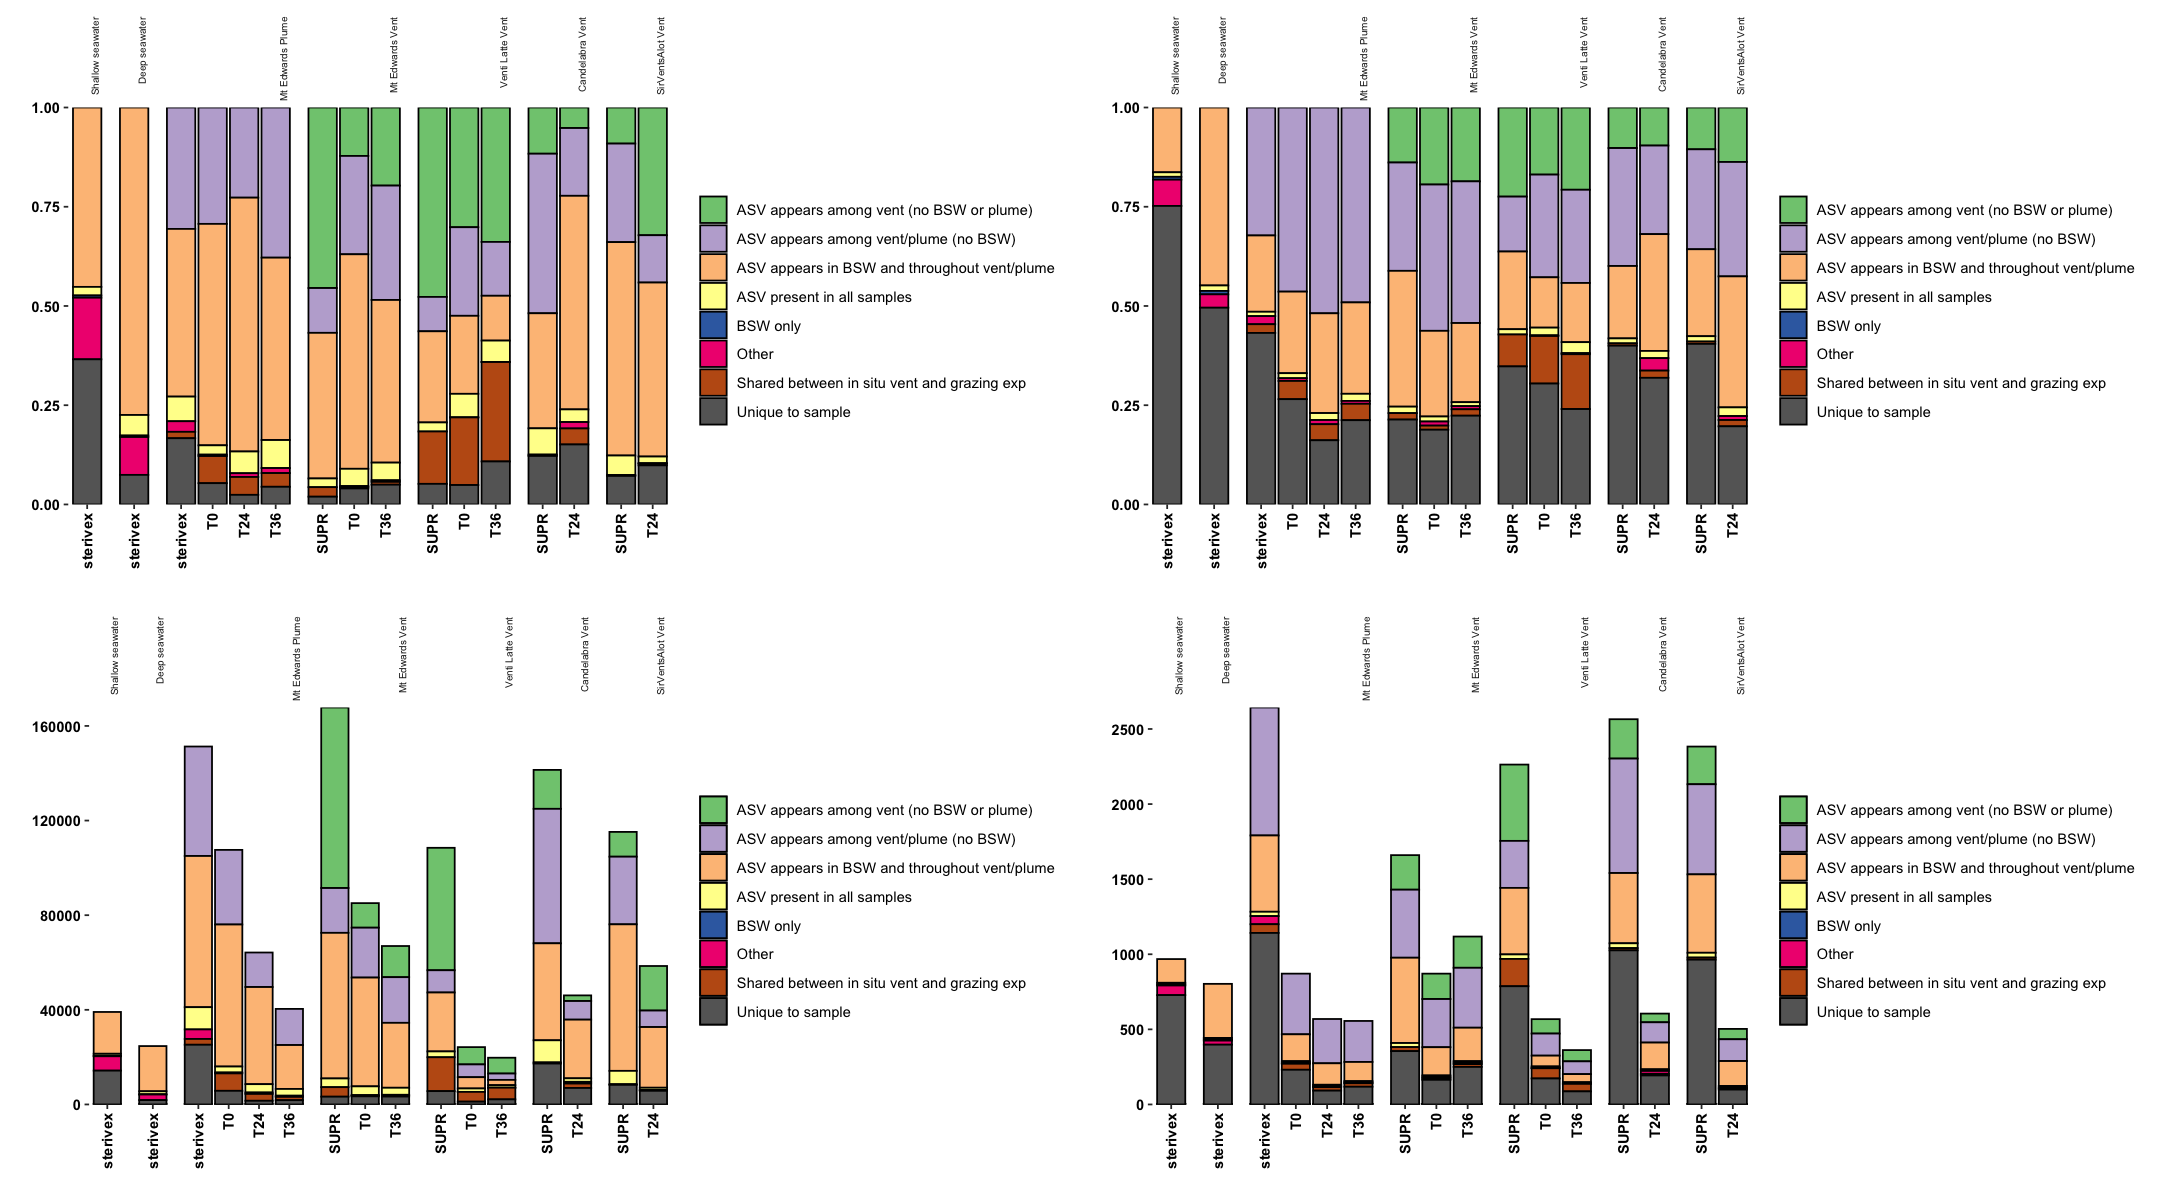

In [366]:
totalseq <- ggplot(gr_sorted_summary, aes(x=SAMPLEID, y=totalseq, fill=category_final)) +
  geom_bar(stat = "identity", color = "black", position = "fill") + 
  scale_fill_brewer(palette = "Accent") +
  scale_y_continuous(expand = c(0, 0)) +
  facet_grid(. ~ LOCATION_ORDER, space = "free", scales = "free")+
  theme(legend.position = "right",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        panel.background = element_blank(),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold"),
        axis.text.y = element_text(color="black", face="bold"),
        strip.text = element_text(size = 6, angle = 90, vjust = 0, hjust = 1),
        strip.background = element_blank(),
        legend.title = element_blank()) +
  labs(x="", y="")
# totalseq
#
# plot_grid(totalseq + geom_bar(stat = "identity", color = "black", position = "stack"), totalseq, ncol = 1, nrow = 2, align = "hv")
#
totalasv <- ggplot(gr_sorted_summary, aes(x=SAMPLEID, y= totalasv, fill=category_final)) +
  geom_bar(stat = "identity", color = "black", position = "fill") + 
  scale_fill_brewer(palette = "Accent") +
  scale_y_continuous(expand = c(0, 0)) +
  facet_grid(. ~ LOCATION_ORDER, space = "free", scales = "free") +
  theme(legend.position = "right",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        panel.background = element_blank(),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold"),
        axis.text.y = element_text(color="black", face="bold"),
        strip.text = element_text(size = 6, angle = 90, vjust = 0, hjust = 1),
        strip.background = element_blank(),
        legend.title = element_blank()) +
  labs(x="", y="")
# totalasv
#
# svg("SUPP-asv-distribution-totalseqasv.svg", h=11, w=19)
# plot_grid(totalseq, totalasv)
options(repr.plot.width = 18, repr.plot.height = 10)

# Supplementary table
plot_grid(totalseq, totalasv,
          totalseq + geom_bar(stat = "identity", color = "black", position = "stack"), 
          totalasv + geom_bar(stat = "identity", color = "black", position = "stack"))

`summarise()` regrouping output by 'SAMPLE', 'Sampletype', 'LocationName', 'SAMPLEID' (override with `.groups` argument)



[1] Grazing in situ
Levels:  control Control Grazing in situ

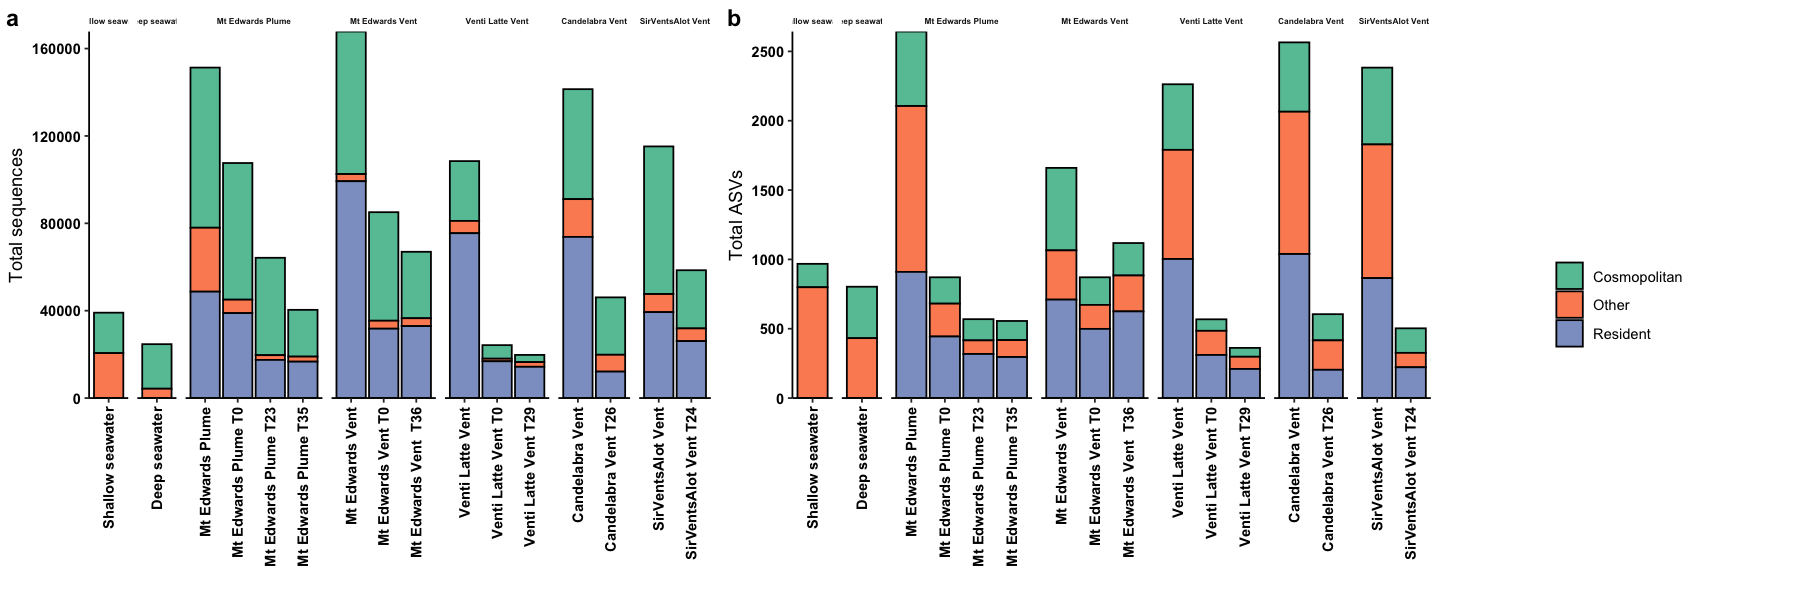

In [369]:
#
# Simplify!
#
resident <- c("ASV appears among vent/plume (no BSW)", "ASV appears among vent (no BSW or plume)", "Shared between in situ vent and grazing exp")
cosmo <- c("ASV appears in BSW and throughout vent/plume", "ASV present in all samples")
gr_sorted$RES_COSMO = "Other"
gr_sorted$RES_COSMO[gr_sorted$category_final %in% resident] = "Resident"
gr_sorted$RES_COSMO[gr_sorted$category_final %in% cosmo] = "Cosmopolitan"
#
# head(gr_sorted[1:2,])
# ?unite()
gr_sorted_bydist <- gr_sorted %>%
  unite("SAMPLE", c("LocationName", "Sampletype", "SAMPLEID"), sep = " ", remove = FALSE) %>%
  group_by(SAMPLE, Sampletype, LocationName, SAMPLEID, RES_COSMO) %>%
  summarise(totalasv = n(), totalseq = sum(COUNT_AVG)) %>%
  data.frame
# head(gr_sorted_bydist)
#
sample_order_all<-c("Shallow seawater in situ sterivex","Deep seawater in situ sterivex","Mt Edwards Plume in situ sterivex","Mt Edwards Plume Grazing T0","Mt Edwards Plume Grazing T24","Mt Edwards Plume Grazing T36","Mt Edwards Vent in situ SUPR","Mt Edwards Vent Grazing T0","Mt Edwards Vent Grazing T36","Venti Latte Vent in situ SUPR","Venti Latte Vent Grazing T0","Venti Latte Vent Grazing T36","Candelabra Vent in situ SUPR","Candelabra Vent Grazing T24","SirVentsAlot Vent in situ SUPR","SirVentsAlot Vent Grazing T24")
sample_name_all<-c("Shallow seawater","Deep seawater","Mt Edwards Plume","Mt Edwards Plume T0","Mt Edwards Plume T23","Mt Edwards Plume T35","Mt Edwards Vent","Mt Edwards Vent T0","Mt Edwards Vent  T36","Venti Latte Vent","Venti Latte Vent T0","Venti Latte Vent T29","Candelabra Vent","Candelabra Vent T26","SirVentsAlot Vent","SirVentsAlot Vent T24")
gr_sorted_bydist$SAMPLE_ORDER <- factor(gr_sorted_bydist$SAMPLE, levels = sample_order_all, labels = sample_name_all)
#
LocationNameOrder<-c("Shallow seawater", "Deep seawater", "Mt Edwards Plume", "Mt Edwards Vent", "Venti Latte Vent", "Candelabra Vent", "SirVentsAlot Vent")
gr_sorted_bydist$LOCATION_ORDER <- factor(gr_sorted_bydist$LocationName, levels = LocationNameOrder)
unique(gr_sorted_bydist$Sampletype)
#
#
base <- ggplot(gr_sorted_bydist, aes(x = SAMPLE_ORDER, y= totalseq)) +
  geom_bar(stat = "identity", position = "stack", color = "#6a51a3", fill = "#6a51a3") +
  facet_grid(. ~ LOCATION_ORDER, space = "free", scales = "free") +
  scale_y_continuous(expand = c(0,0)) +
  theme(legend.position = "right",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(),
        # panel.border = element_blank(),
        panel.background = element_blank(),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold"),
        axis.text.y = element_text(color="black", face="bold"),
        strip.text = element_text(size = 5, face = "bold"),
        strip.background = element_blank(),
        legend.title = element_blank()) +
  labs(x="", y="")
#
# ?scale_fill_brewer
# head(gr_sorted_bydist)
filled_seq <- ggplot(gr_sorted_bydist, aes(x = SAMPLE_ORDER, y= totalseq)) +
  geom_bar(stat = "identity", position = "stack", color = "black", aes(fill = RES_COSMO)) +
  scale_fill_brewer(palette = "Set2") +
  facet_grid(. ~ LOCATION_ORDER, space = "free", scales = "free") +
  scale_y_continuous(expand = c(0,0)) +
  theme(legend.position = "right",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(),
        # panel.border = element_blank(),
        panel.background = element_blank(),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold"),
        axis.text.y = element_text(color="black", face="bold"),
        strip.text = element_text(size = 5, face = "bold"),
        strip.background = element_blank(),
        legend.title = element_blank()) +
  labs(x="", y="Total sequences")
#
filled_asv <- ggplot(gr_sorted_bydist, aes(x = SAMPLE_ORDER, y= totalasv)) +
  geom_bar(stat = "identity", position = "stack", color = "black", aes(fill = RES_COSMO)) +
  scale_fill_brewer(palette = "Set2") +
  facet_grid(. ~ LOCATION_ORDER, space = "free", scales = "free") +
  scale_y_continuous(expand = c(0,0)) +
  theme(legend.position = "right",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.line = element_line(),
        # panel.border = element_blank(),
        panel.background = element_blank(),
        axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold"),
        axis.text.y = element_text(color="black", face="bold"),
        strip.text = element_text(size = 5, face = "bold"),
        strip.background = element_blank(),
        legend.title = element_blank()) +
  labs(x="", y="Total ASVs")
#
legend<-get_legend(filled_seq)
# svg("dist-seq-asv.svg", h = 8, w = 10)
options(repr.plot.width = 15, repr.plot.height = 5)
plot_grid(filled_seq + theme(legend.position = "none"), 
          filled_asv + theme(legend.position = "none"),
          legend, ncol = 3, nrow = 1, rel_widths = c(1,1,0.5), labels = c("a", "b", ""))
# dev.off()

In [ ]:
# save(gr_sorted, asv_key_final, file = "data-input/GR-countinfo-withASVdistribution.RData")

## Generate taxa plots - additional resolution and by distribution

In [85]:
load("data-input/GordaRidge-ASVtable-avg-22-07-2020.RData",verbose=T)
load("data-input/GR-countinfo-withASVdistribution.RData", verbose=T)

Loading objects:
  gr_counts_filter
  gr_counts_wtax
  gr_counts_avg_wtax
Loading objects:
  gr_sorted
  asv_key_final


In [87]:
## Recurate taxa for next level
head(gr_counts_avg_wtax[1:3,])
unique(gr_counts_avg_wtax$Taxa)

Feature.ID                       SAMPLEID Sampletype LOCATION_SPECIFIC
1 0009645516609bda2246e1955ff9ec1d sterivex in situ    BSW081           
2 0030ad8ce44f257c42daf3673bf92197 sterivex in situ    BSW081           
3 0030ad8ce44f257c42daf3673bf92197 SUPR     in situ    Vent040          
  LocationName     Taxon     level1    level2     level3 level4 level5 level6
1 Shallow seawater Eukaryota Eukaryota Unassigned                            
2 Shallow seawater Eukaryota Eukaryota Unassigned                            
3 Venti Latte Vent Eukaryota Eukaryota Unassigned                            
  level7 Taxa       COUNT_AVG
1        Unassigned 80       
2        Unassigned 36       
3        Unassigned 12

[1] "Unassigned"                 "Opisthokonta-Metazoa"      
 [3] "Alveolata-Ciliates"         "Opisthokonta-Other"        
 [5] "Stramenopiles-Ochrophyta"   "Rhizaria-other"            
 [7] "Alveolata-Dinoflagellates"  "Opisthokonta-Fungi"        
 [9] "Stramenopiles-Other"        "Hacrobia-Haptophyta"       
[11] "Archaeplastida-Chlorophyta" "Stramenopiles-MAST"        
[13] "Archaeplastida-Other"       "Alveolata-Syndiniales"     
[15] "Excavata"                   "Alveolata-Other"           
[17] "Hacrobia-Cryptophyta"       "Hacrobia-Other"            
[19] "Rhizaria-Cercozoa"          "Amoebozoa"

In [109]:
head(gr_counts_avg_wtax)
str(gr_counts_avg_wtax)

Feature.ID                       SAMPLEID Sampletype LOCATION_SPECIFIC
1 0009645516609bda2246e1955ff9ec1d sterivex in situ    BSW081           
2 0030ad8ce44f257c42daf3673bf92197 sterivex in situ    BSW081           
3 0030ad8ce44f257c42daf3673bf92197 SUPR     in situ    Vent040          
4 0030ad8ce44f257c42daf3673bf92197 SUPR     in situ    Vent088          
5 0030ad8ce44f257c42daf3673bf92197 T24      Grazing    Vent110          
6 0038478be7fb4f097ce93a5e9341af2a sterivex in situ    BSW056           
  LocationName      Taxon                                                      
1 Shallow seawater  Eukaryota                                                  
2 Shallow seawater  Eukaryota                                                  
3 Venti Latte Vent  Eukaryota                                                  
4 Candelabra Vent   Eukaryota                                                  
5 SirVentsAlot Vent Eukaryota                                                  
6 Deep seawater     Eukaryota;Opisthokonta;Metazoa;Cnidaria;Cnidaria_X;Hydrozoa
  level1    level2       level3  level4   level5     level6   level7
1 Eukaryota Unassigned                                              
2 Eukaryota Unassigned                                              
3 Eukaryota Unassigned                                              
4 Eukaryota Unassigned                                              
5 Eukaryota Unassigned                                              
6 Eukaryota Opisthokonta Metazoa Cnidaria Cnidaria_X Hydrozoa       
  Taxa                 COUNT_AVG
1 Unassigned           80       
2 Unassigned           36       
3 Unassigned           12       
4 Unassigned           34       
5 Unassigned           15       
6 Opisthokonta-Metazoa 21

'data.frame':	19308 obs. of  15 variables:
 $ Feature.ID       : Factor w/ 14483 levels "0009645516609bda2246e1955ff9ec1d",..: 1 5 5 5 5 7 7 7 7 7 ...
 $ SAMPLEID         : chr  "sterivex" "sterivex" "SUPR" "SUPR" ...
 $ Sampletype       : Factor w/ 4 levels "control","Control",..: 4 4 4 4 3 4 4 4 4 4 ...
 $ LOCATION_SPECIFIC: Factor w/ 24 levels "BSW020","BSW056",..: 3 3 14 19 24 2 3 5 6 7 ...
 $ LocationName     : Factor w/ 9 levels "Candelabra Vent",..: 6 6 9 1 8 2 6 4 4 4 ...
 $ Taxon            : Factor w/ 580 levels "Eukaryota","Eukaryota;Alveolata",..: 1 1 1 1 1 379 379 379 379 379 ...
 $ level1           : Factor w/ 1 level "Eukaryota": 1 1 1 1 1 1 1 1 1 1 ...
 $ level2           : chr  "Unassigned" "Unassigned" "Unassigned" "Unassigned" ...
 $ level3           : Factor w/ 32 levels "","Alveolata_X",..: 1 1 1 1 1 21 21 21 21 21 ...
 $ level4           : Factor w/ 106 levels "","Acantharea",..: 1 1 1 1 1 20 20 20 20 20 ...
 $ level5           : Factor w/ 175 levels "","Acanthare

In [284]:
# Add Taxa2 level
expand_taxa2 <- function(df){
    df$Taxa <- as.character(df$Taxa)
    df$level5 <- as.character(df$level5)
    df$level4 <- as.character(df$level4)
    df$level3 <- as.character(df$level3)
    df$Taxa2 <- df$Taxa
    five <- c("Alveolata-Syndiniales", "Alveolata-Dinoflagellates")
    df$Taxa2 <- with(df, ifelse(Taxa2 %in% five, df$level5, df$Taxa2))
    four <- c("Alveolata-Ciliates", "Rhizaria-other", "Stramenopiles-MAST", "Stramenopiles-Ochrophyta", "Opisthokonta-Metazoa", "Opisthokonta-Fungi", "Opisthokonta-Other")
    df$Taxa2 <- with(df, ifelse(Taxa2 %in% four, df$level4, df$Taxa2))
    three <- c("Hacrobia-Other")
    df$Taxa2 <- with(df, ifelse(Taxa2 %in% three, df$level3, df$Taxa2))
    df2 <- mutate(df, Taxa2 = ifelse(Taxa2 %in% "", Taxa, Taxa2)) %>% 
            mutate(Taxa2 = ifelse(Taxa2 %in% "Spirotrichea", paste(level4, level5, sep = "-"), Taxa2))
    return(df2)
    }
gr_counts_avg_wtax2 <- expand_taxa2(gr_counts_avg_wtax)
head(gr_counts_avg_wtax2)
unique(gr_counts_avg_wtax2$Taxa2)

Feature.ID                       SAMPLEID Sampletype LOCATION_SPECIFIC
1 0009645516609bda2246e1955ff9ec1d sterivex in situ    BSW081           
2 0030ad8ce44f257c42daf3673bf92197 sterivex in situ    BSW081           
3 0030ad8ce44f257c42daf3673bf92197 SUPR     in situ    Vent040          
4 0030ad8ce44f257c42daf3673bf92197 SUPR     in situ    Vent088          
5 0030ad8ce44f257c42daf3673bf92197 T24      Grazing    Vent110          
6 0038478be7fb4f097ce93a5e9341af2a sterivex in situ    BSW056           
  LocationName      Taxon                                                      
1 Shallow seawater  Eukaryota                                                  
2 Shallow seawater  Eukaryota                                                  
3 Venti Latte Vent  Eukaryota                                                  
4 Candelabra Vent   Eukaryota                                                  
5 SirVentsAlot Vent Eukaryota                                                  
6 Deep seawater     Eukaryota;Opisthokonta;Metazoa;Cnidaria;Cnidaria_X;Hydrozoa
  level1    level2       level3  level4   level5     level6   level7
1 Eukaryota Unassigned                                              
2 Eukaryota Unassigned                                              
3 Eukaryota Unassigned                                              
4 Eukaryota Unassigned                                              
5 Eukaryota Unassigned                                              
6 Eukaryota Opisthokonta Metazoa Cnidaria Cnidaria_X Hydrozoa       
  Taxa                 COUNT_AVG Taxa2     
1 Unassigned           80        Unassigned
2 Unassigned           36        Unassigned
3 Unassigned           12        Unassigned
4 Unassigned           34        Unassigned
5 Unassigned           15        Unassigned
6 Opisthokonta-Metazoa 21        Cnidaria

[1] "Unassigned"                  "Cnidaria"                   
 [3] "Spirotrichea-Strombidiida"   "Opisthokonta-Other"         
 [5] "Bacillariophyta"             "RAD-B"                      
 [7] "Alveolata-Dinoflagellates"   "Opisthokonta-Fungi"         
 [9] "Stramenopiles-Other"         "Dictyochophyceae"           
[11] "Opisthokonta-Metazoa"        "Hacrobia-Haptophyta"        
[13] "Chrysophyceae"               "Archaeplastida-Chlorophyta" 
[15] "MAST-4"                      "Spirotrichea-Spirotrichea_X"
[17] "Archaeplastida-Other"        "Spirotrichea-Choreotrichida"
[19] "Dino-Group-II"               "Chytridiomycota"            
[21] "Arthropoda"                  "MOCH-3"                     
[23] "Dinophyceae_X"               "Bolidophyceae"              
[25] "Kickxellomycota"             "MAST-7"                     
[27] "Mollusca"                    "Gymnodiniales"              
[29] "Plagiopylea"                 "Dino-Group-IV"              
[31] "Spirotrichea-Euplotia"       "Opisthokonta_XX"            
[33] "Basidiomycota"               "Nemertea"                   
[35] "MAST-8"                      "Polycystinea"               
[37] "Annelida"                    "Acantharea"                 
[39] "Excavata"                    "Spirotrichea-Tintinnida"    
[41] "Oligohymenophorea"           "Litostomatea"               
[43] "Pelagophyceae"               "Gonyaulacales"              
[45] "Rotifera"                    "MAST-2"                     
[47] "Alveolata-Other"             "Spirotrichea-"              
[49] "Craniata"                    "Suessiales"                 
[51] "Hacrobia-Cryptophyta"        "Katablepharidophyta"        
[53] "Rhizaria-Cercozoa"           "Colpodea"                   
[55] "Spirotrichea-Hypotrichia"    "Phyllopharyngea"            
[57] "Alveolata-Ciliates"          "Stramenopiles-Ochrophyta"   
[59] "Choanoflagellatea"           "Heterotrichea"              
[61] "Centroheliozoa"              "Amoebozoa"                  
[63] "Synurophyceae"               "Noctilucales"               
[65] "Telonemia"                   "MAST-3"                     
[67] "Ascomycota"                  "Picozoa"                    
[69] "Urochordata"                 "Nematoda"                   
[71] "Peridiniales"                "Ctenophora"                 
[73] "Prostomatea_1"               "Echinodermata"              
[75] "Mucoromycota"                "Karyorelictea"              
[77] "MAST-9"                      "Ciliophora_X"               
[79] "MAST-25"                     "Dino-Group-I"               
[81] "Microsporidiomycota"         "Platyhelminthes"            
[83] "Spirotrichea-Strombidiida_G" "RAD-C"                      
[85] "Porifera"

In [285]:
# Add categories & set up for plotting function
gr_tax_res <- gr_counts_avg_wtax2 %>% 
    left_join(asv_key_final) %>% 
    unite(SAMPLE, LocationName, Sampletype, SAMPLEID, sep = "-", remove = FALSE) %>% 
    data.frame
#
resident <- c("ASV appears among vent/plume (no BSW)", "ASV appears among vent (no BSW or plume)", "Shared between in situ vent and grazing exp")
cosmo <- c("ASV appears in BSW and throughout vent/plume", "ASV present in all samples")
gr_tax_res$RES_COSMO = "Other"
gr_tax_res$RES_COSMO[gr_tax_res$category_final %in% resident] = "Resident"
gr_tax_res$RES_COSMO[gr_tax_res$category_final %in% cosmo] = "Cosmopolitan"
#
head(gr_tax_res[1:2,])

#
# Subset and plot function
#
# all <- c("Unique to sample","ASV appears in BSW and throughout vent/plume",
#          "ASV appears among vent/plume (no BSW)","Shared between in situ vent and grazing exp",
#          "ASV appears among vent (no BSW or plume)","Other","ASV present in all samples","BSW only")
# vent <- c("ASV appears among vent/plume (no BSW)","Shared between in situ vent and grazing exp",
#          "ASV appears among vent (no BSW or plume)")
sample_order_all<-c("Shallow seawater-in situ-sterivex","Deep seawater-in situ-sterivex","Mt Edwards Plume-in situ-sterivex","Mt Edwards Plume-Grazing-T0","Mt Edwards Plume-Grazing-T24","Mt Edwards Plume-Grazing-T36","Mt Edwards Vent-in situ-SUPR","Mt Edwards Vent-Grazing-T0","Mt Edwards Vent-Grazing-T36","Venti Latte Vent-in situ-SUPR","Venti Latte Vent-Grazing-T0","Venti Latte Vent-Grazing-T36","Candelabra Vent-in situ-SUPR","Candelabra Vent-Grazing-T24","SirVentsAlot Vent-in situ-SUPR","SirVentsAlot Vent-Grazing-T24")
sample_name_all<-c("Shallow seawater","Deep seawater","Mt Edwards Plume","Mt Edwards Plume T0","Mt Edwards Plume T23","Mt Edwards Plume T35","Mt Edwards Vent","Mt Edwards Vent T0","Mt Edwards Vent  T36","Venti Latte Vent","Venti Latte Vent T0","Venti Latte Vent T29","Candelabra Vent","Candelabra Vent T26","SirVentsAlot Vent","SirVentsAlot Vent T24")


# prepdf_tax_dist <- function(df, category){ 
prepdf_tax_dist <- function(df){ 
    df2 <- df %>% 
#     filter(category_final %in% category) %>% 
    # average across replicates
    group_by(Feature.ID, RES_COSMO, SAMPLE, SAMPLEID, Sampletype, LocationName, Taxon, Taxa, Taxa2) %>%
    summarise(COUNT_AVG2 = mean(COUNT_AVG)) %>%
    ungroup() %>% 
    # sum by like taxa
    group_by(RES_COSMO, SAMPLE, SAMPLEID, Sampletype, LocationName, Taxa, Taxa2) %>% 
    summarise(SUM = sum(COUNT_AVG2)) %>% 
    data.frame
    df2$SAMPLENAME<-factor(df2$SAMPLE, levels = sample_order_all, labels = sample_name_all)
    df2$SAMPLEID_ORDER <- factor(df2$SAMPLEID, levels = c("sterivex", "SUPR", "T0", "T24", "T36"))
    df2$LOCATION_ORDER <- factor(df2$LocationName, levels=c("Shallow seawater", "Deep seawater", "Mt Edwards Plume", "Mt Edwards Vent", "Venti Latte Vent", "Candelabra Vent", "SirVentsAlot Vent"))
    return(df2)
}

Joining, by = "Feature.ID"



Feature.ID                       SAMPLE                            SAMPLEID
1 0009645516609bda2246e1955ff9ec1d Shallow seawater-in situ-sterivex sterivex
2 0030ad8ce44f257c42daf3673bf92197 Shallow seawater-in situ-sterivex sterivex
  Sampletype LOCATION_SPECIFIC LocationName     Taxon     level1    level2    
1 in situ    BSW081            Shallow seawater Eukaryota Eukaryota Unassigned
2 in situ    BSW081            Shallow seawater Eukaryota Eukaryota Unassigned
  level3 level4 level5 level6 level7 Taxa       COUNT_AVG Taxa2     
1                                    Unassigned 80        Unassigned
2                                    Unassigned 36        Unassigned
  category_final                               RES_COSMO   
1 Unique to sample                             Other       
2 ASV appears in BSW and throughout vent/plume Cosmopolitan

In [286]:
# Prep plot for exploring taxonomic distribution
gr_tax_res_toplot <- prepdf_tax_dist(gr_tax_res)
head(gr_tax_res_toplot[1:2,])
class(gr_tax_res_toplot)

`summarise()` regrouping output by 'Feature.ID', 'RES_COSMO', 'SAMPLE', 'SAMPLEID', 'Sampletype', 'LocationName', 'Taxon', 'Taxa' (override with `.groups` argument)

`summarise()` regrouping output by 'RES_COSMO', 'SAMPLE', 'SAMPLEID', 'Sampletype', 'LocationName', 'Taxa' (override with `.groups` argument)



RES_COSMO    SAMPLE                      SAMPLEID Sampletype LocationName   
1 Cosmopolitan Candelabra Vent-Grazing-T24 T24      Grazing    Candelabra Vent
2 Cosmopolitan Candelabra Vent-Grazing-T24 T24      Grazing    Candelabra Vent
  Taxa               Taxa2                     SUM  SAMPLENAME         
1 Alveolata-Ciliates Heterotrichea              241 Candelabra Vent T26
2 Alveolata-Ciliates Spirotrichea-Strombidiida 2495 Candelabra Vent T26
  SAMPLEID_ORDER LOCATION_ORDER 
1 T24            Candelabra Vent
2 T24            Candelabra Vent

[1] "data.frame"

In [287]:
unique(gr_tax_res_toplot$SAMPLENAME)

[1] Candelabra Vent T26   Candelabra Vent       Deep seawater        
 [4] Mt Edwards Plume T0   Mt Edwards Plume T23  Mt Edwards Plume T35 
 [7] Mt Edwards Plume      Mt Edwards Vent T0    Mt Edwards Vent  T36 
[10] Mt Edwards Vent       Shallow seawater      SirVentsAlot Vent T24
[13] SirVentsAlot Vent     Venti Latte Vent T0   Venti Latte Vent T29 
[16] Venti Latte Vent     
16 Levels: Shallow seawater Deep seawater ... SirVentsAlot Vent T24

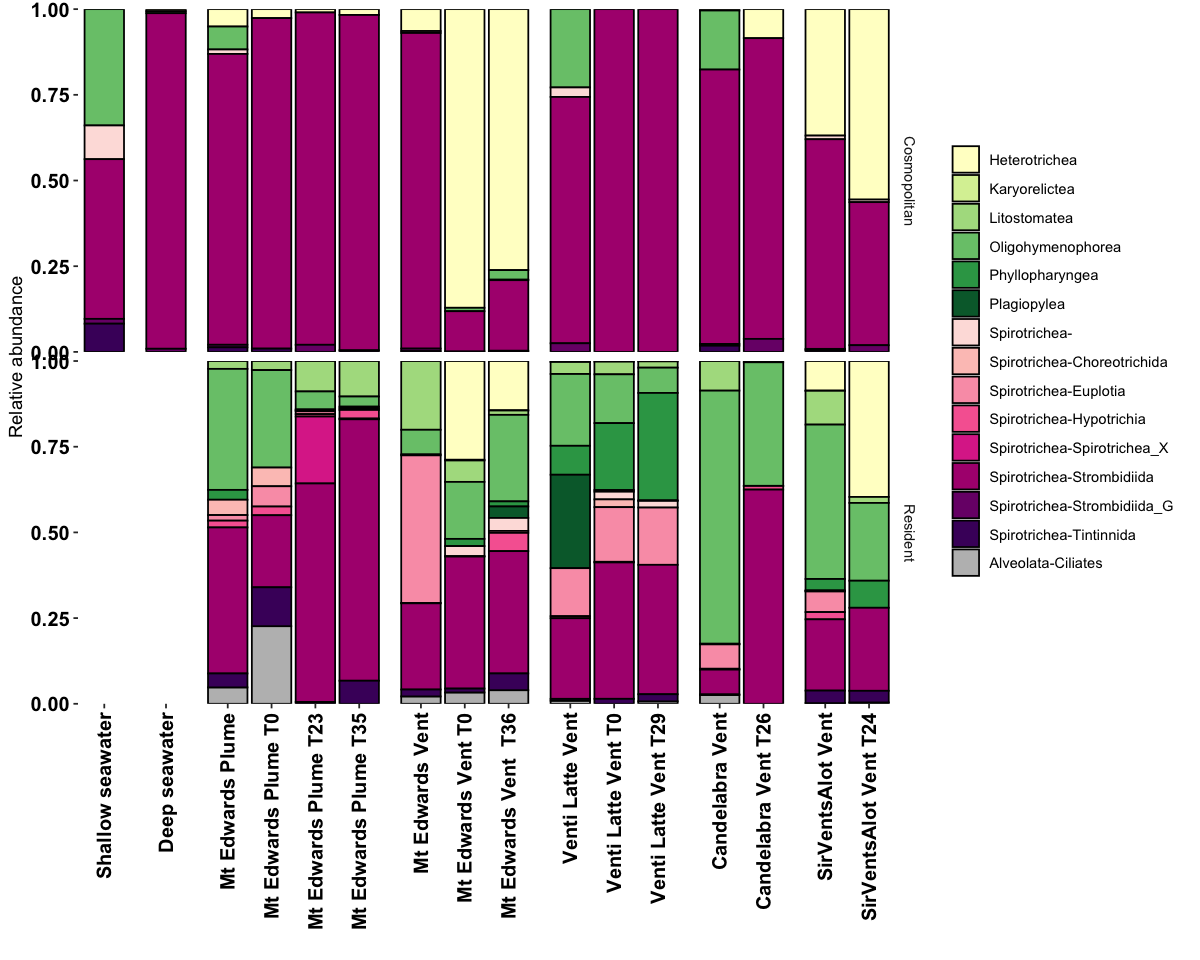

In [288]:
# Plot ciliate distribution
# tmp <- unique(filter(gr_tax_res_toplot, !(RES_COSMO == "Other") & Taxa == "Alveolata-Ciliates"))
# unique(tmp$Taxa2)
# barplot_taxa2(filter(gr_tax_res_toplot, !(RES_COSMO == "Other")), "Alveolata-Ciliates", "RdPu")
# Factor
ciliate_order <- c("Heterotrichea","Karyorelictea","Litostomatea","Oligohymenophorea","Phyllopharyngea","Plagiopylea","Spirotrichea-","Spirotrichea-Choreotrichida","Spirotrichea-Euplotia","Spirotrichea-Hypotrichia","Spirotrichea-Spirotrichea_X","Spirotrichea-Strombidiida","Spirotrichea-Strombidiida_G","Spirotrichea-Tintinnida","Alveolata-Ciliates")
gr_tax_res_toplot$CILIATE_ORDER <- factor(gr_tax_res_toplot$Taxa2, levels = ciliate_order)
CILIATE_COLOR <- c("#ffffcc","#d9f0a3","#addd8e","#78c679","#31a354","#006837","#fde0dd","#fcc5c0","#fa9fb5","#f768a1","#dd3497","#ae017e","#7a0177","#49006a","#bdbdbd")
names(CILIATE_COLOR)<-ciliate_order
# head(gr_tax_res_toplot)
ciliate_plot <- gr_tax_res_toplot %>% 
    filter(Taxa %in% "Alveolata-Ciliates") %>% 
    filter(!(RES_COSMO == "Other")) %>% 
    ggplot(aes(x = SAMPLENAME, y = SUM, fill = CILIATE_ORDER)) +
    geom_bar(stat = "identity", position = "fill", color = "black") +
    scale_fill_manual(values = CILIATE_COLOR) +
    scale_y_continuous(expand = c(0,0))+
    theme(legend.position = "right",
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          panel.background = element_blank(),
          axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold", size = 12),
          axis.text.y = element_text(color="black", face="bold", size = 12),
          strip.text.x = element_blank(),
          strip.background = element_blank(),
          legend.title = element_blank()) +
    labs(x="", y="Relative abundance")+
    facet_grid(RES_COSMO~LOCATION_ORDER, space = "free", scales = "free")
options(repr.plot.width = 10, repr.plot.height = 8)
ciliate_plot

In [289]:
# Heterotrophs - non-ciliate
tax_order<-c("Alveolata-Dinoflagellates","Alveolata-Other","Dinophyceae_X","Gonyaulacales","Gymnodiniales","Peridiniales","Suessiales","Noctilucales","Dino-Group-I","Dino-Group-II","Dino-Group-IV","MAST-2","MAST-3","MAST-4","MAST-7","MAST-8","MAST-9","MAST-25","Bacillariophyta","Bolidophyceae","Chrysophyceae","Dictyochophyceae","MOCH-3","Pelagophyceae","Synurophyceae","Stramenopiles-Ochrophyta","Stramenopiles-Other","Rhizaria-Cercozoa","Acantharea","Polycystinea","RAD-B","RAD-C","Hacrobia-Cryptophyta","Hacrobia-Haptophyta","Katablepharidophyta","Telonemia","Picozoa","Centroheliozoa")
color_order<-c("#f7f4f9","#e7e1ef","#d4b9da","#df65b0","#e7298a","#ce1256","#980043","#67001f","#fee0d2","#fc9272","#de2d26","#ffffcc","#ffeda0","#fed976","#feb24c","#fd8d3c","#fc4e2a","#e31a1c","#f7fcf5","#e5f5e0","#c7e9c0","#a1d99b","#74c476","#41ab5d","#238b45","#006d2c","#00441b","#a6bddb","#74a9cf","#3690c0","#0570b0","#045a8d","#bfd3e6","#9ebcda","#8c96c6","#8c6bb1","#88419d","#810f7c")
gr_tax_res_toplot$TAXORDER <- factor(gr_tax_res_toplot$Taxa2, levels = tax_order)
names(color_order) <- tax_order

hets_plot <- ggplot(gr_tax_res_toplot, aes(x = SAMPLENAME, y = SUM, fill = TAXORDER)) +
    geom_bar(stat = "identity", position = "fill", color = "black") +
    scale_fill_manual(values = color_order) +
    scale_y_continuous(expand = c(0,0))+
    theme(legend.position = "right",
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          panel.background = element_blank(),
          axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold", size = 12),
          axis.text.y = element_text(color="black", face="bold", size = 12),
          strip.text.x = element_blank(),
          strip.background = element_blank(),
          legend.title = element_blank()) +
    labs(x="", y="Relative abundance")+
    facet_grid(RES_COSMO~LOCATION_ORDER, space = "free", scales = "free")

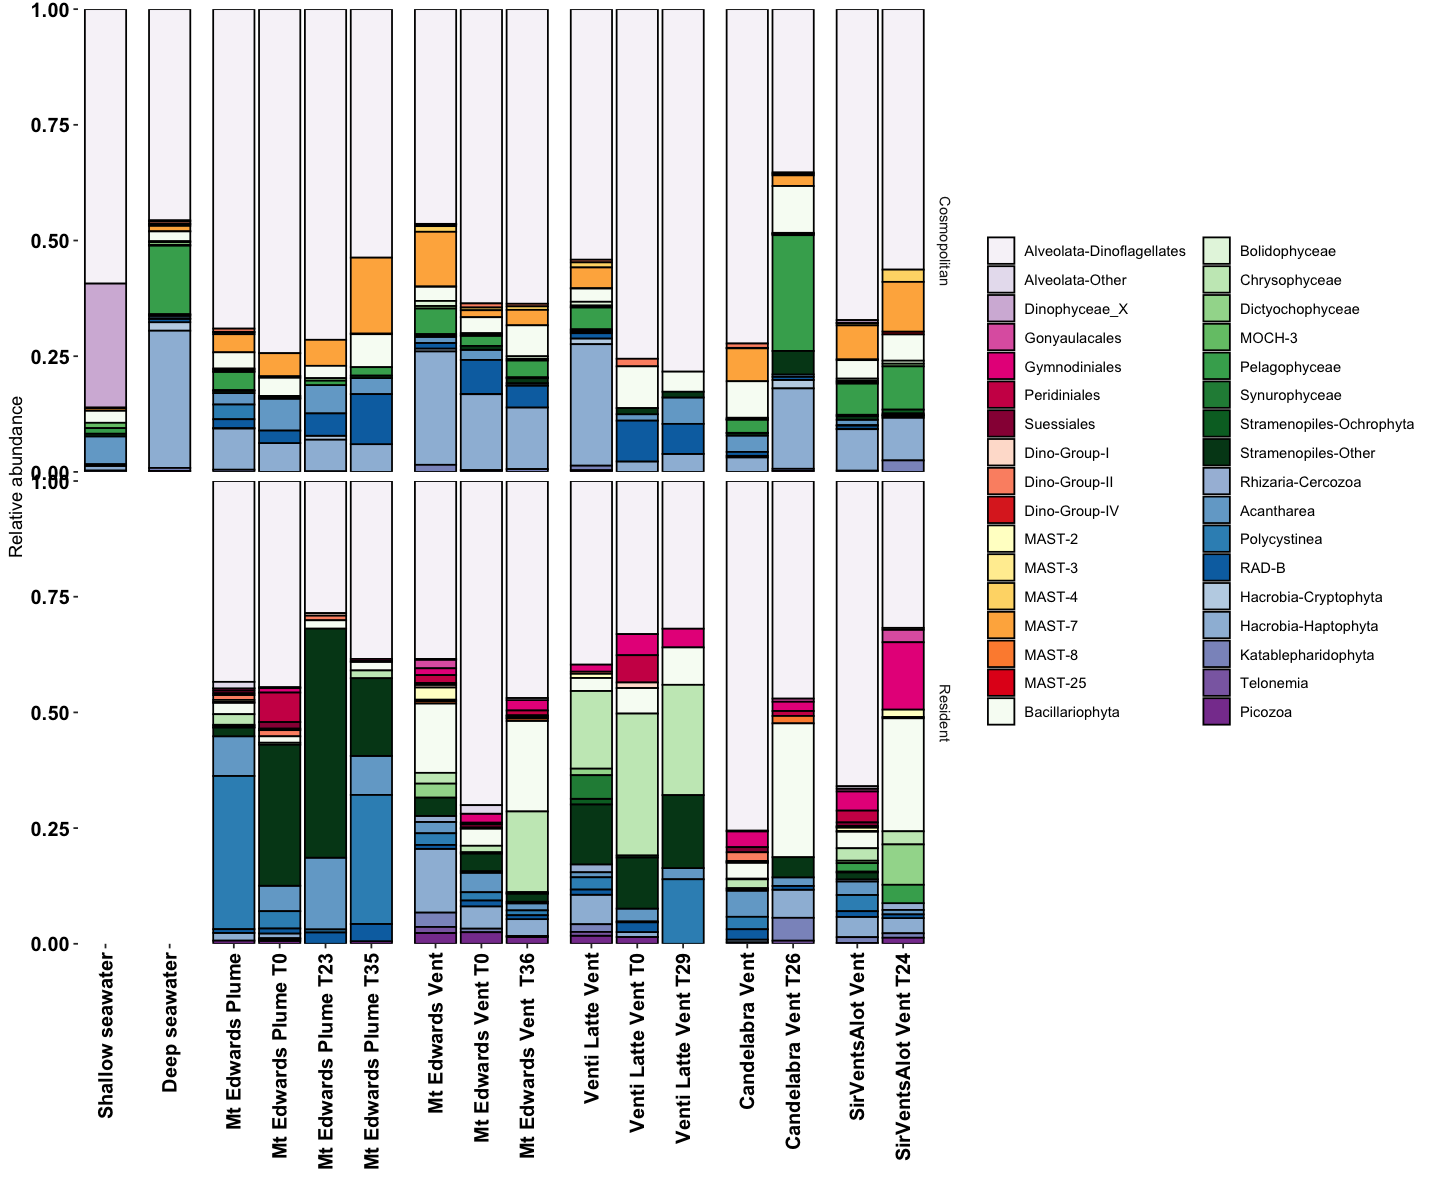

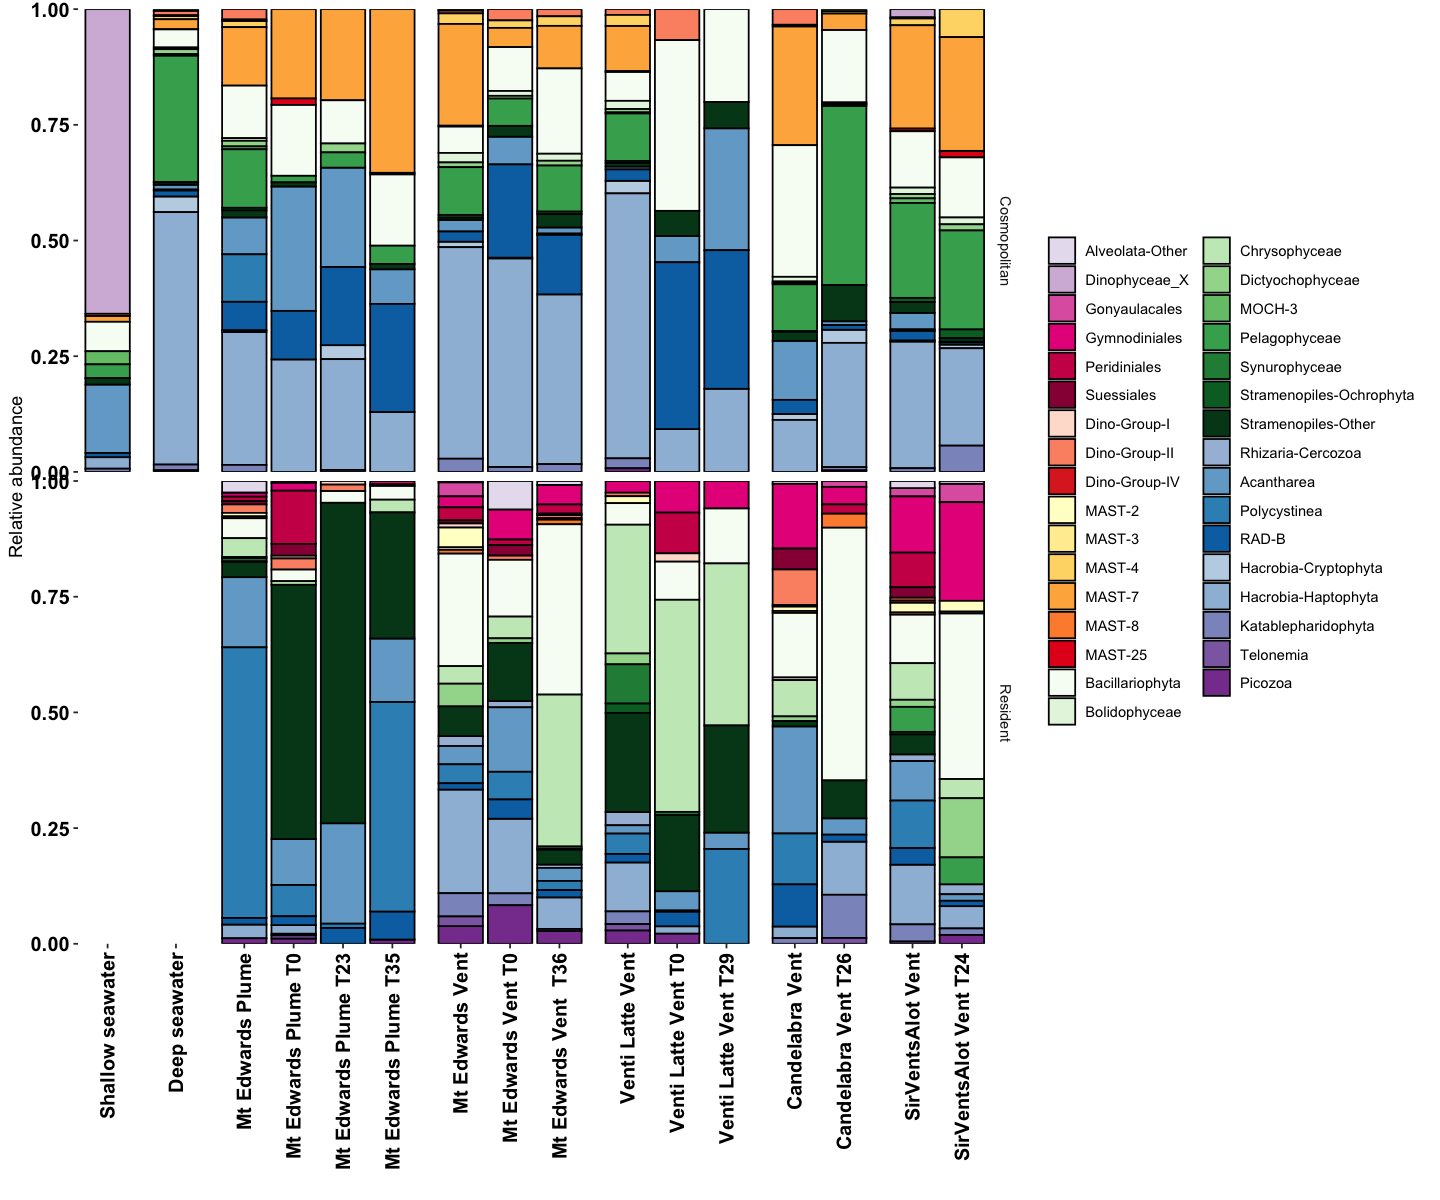

In [290]:
taxa_select <- c('Alveolata-Dinoflagellates',
                 'Hacrobia-Cryptophyta','Hacrobia-Haptophyta','Hacrobia-Other','Rhizaria-other',
                 'Stramenopiles-MAST','Stramenopiles-Ochrophyta','Stramenopiles-Other','Alveolata-Syndiniales',
                 'Alveolata-Other','Rhizaria-Cercozoa')

options(repr.plot.width = 12, repr.plot.height = 10)

hets_plot %+% subset(gr_tax_res_toplot, !(RES_COSMO == "Other") & Taxa %in% taxa_select)
hets_plot %+% subset(gr_tax_res_toplot, !(RES_COSMO == "Other") & Taxa %in% taxa_select & !(Taxa2 == "Alveolata-Dinoflagellates"))

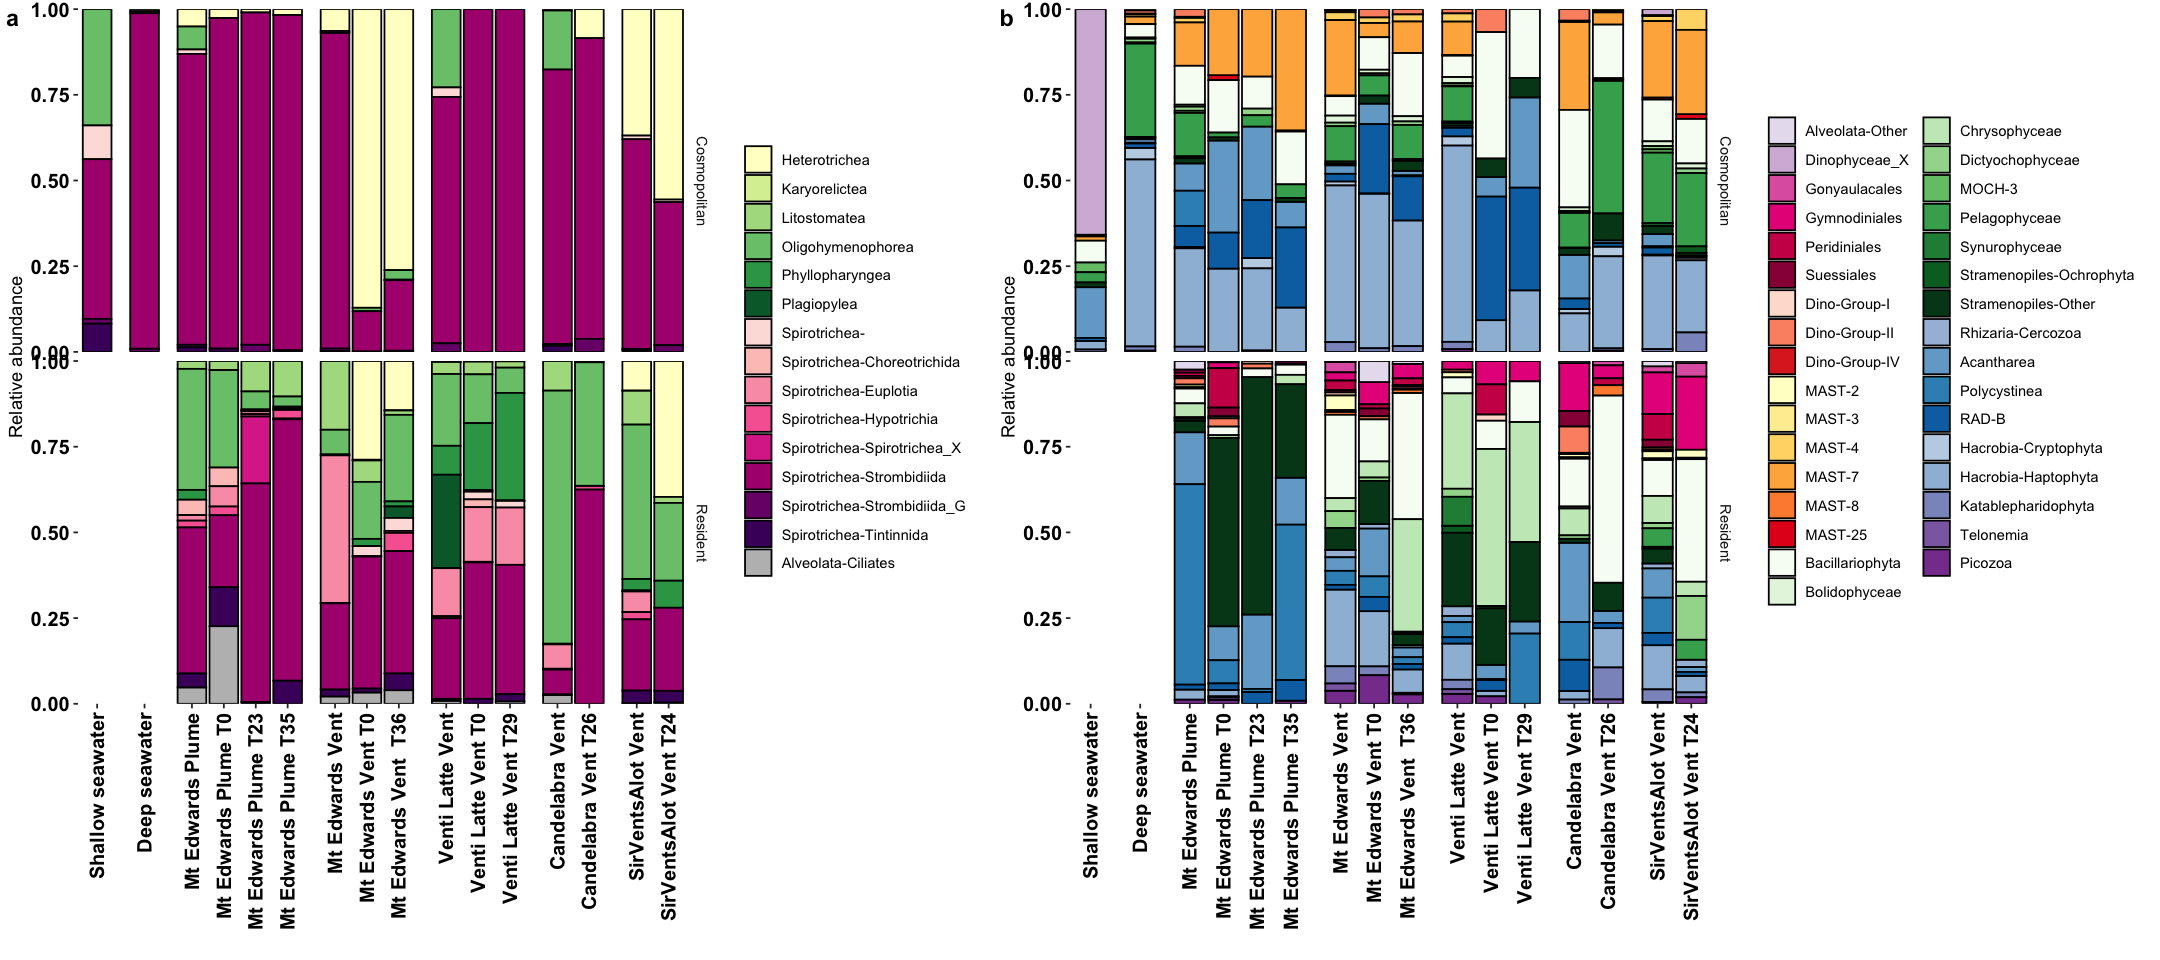

In [280]:
options(repr.plot.width = 18, repr.plot.height = 8)

# svg("tax-res-withdist-GR.svg", w = 18, h = 8)
plot_grid(ciliate_plot,
         hets_plot %+% subset(gr_tax_res_toplot, !(RES_COSMO == "Other") & Taxa %in% taxa_select & !(Taxa2 == "Alveolata-Dinoflagellates")),
         ncol = 2, labels = c("a", "b"), rel_widths = c(0.85, 1))
# dev.off()

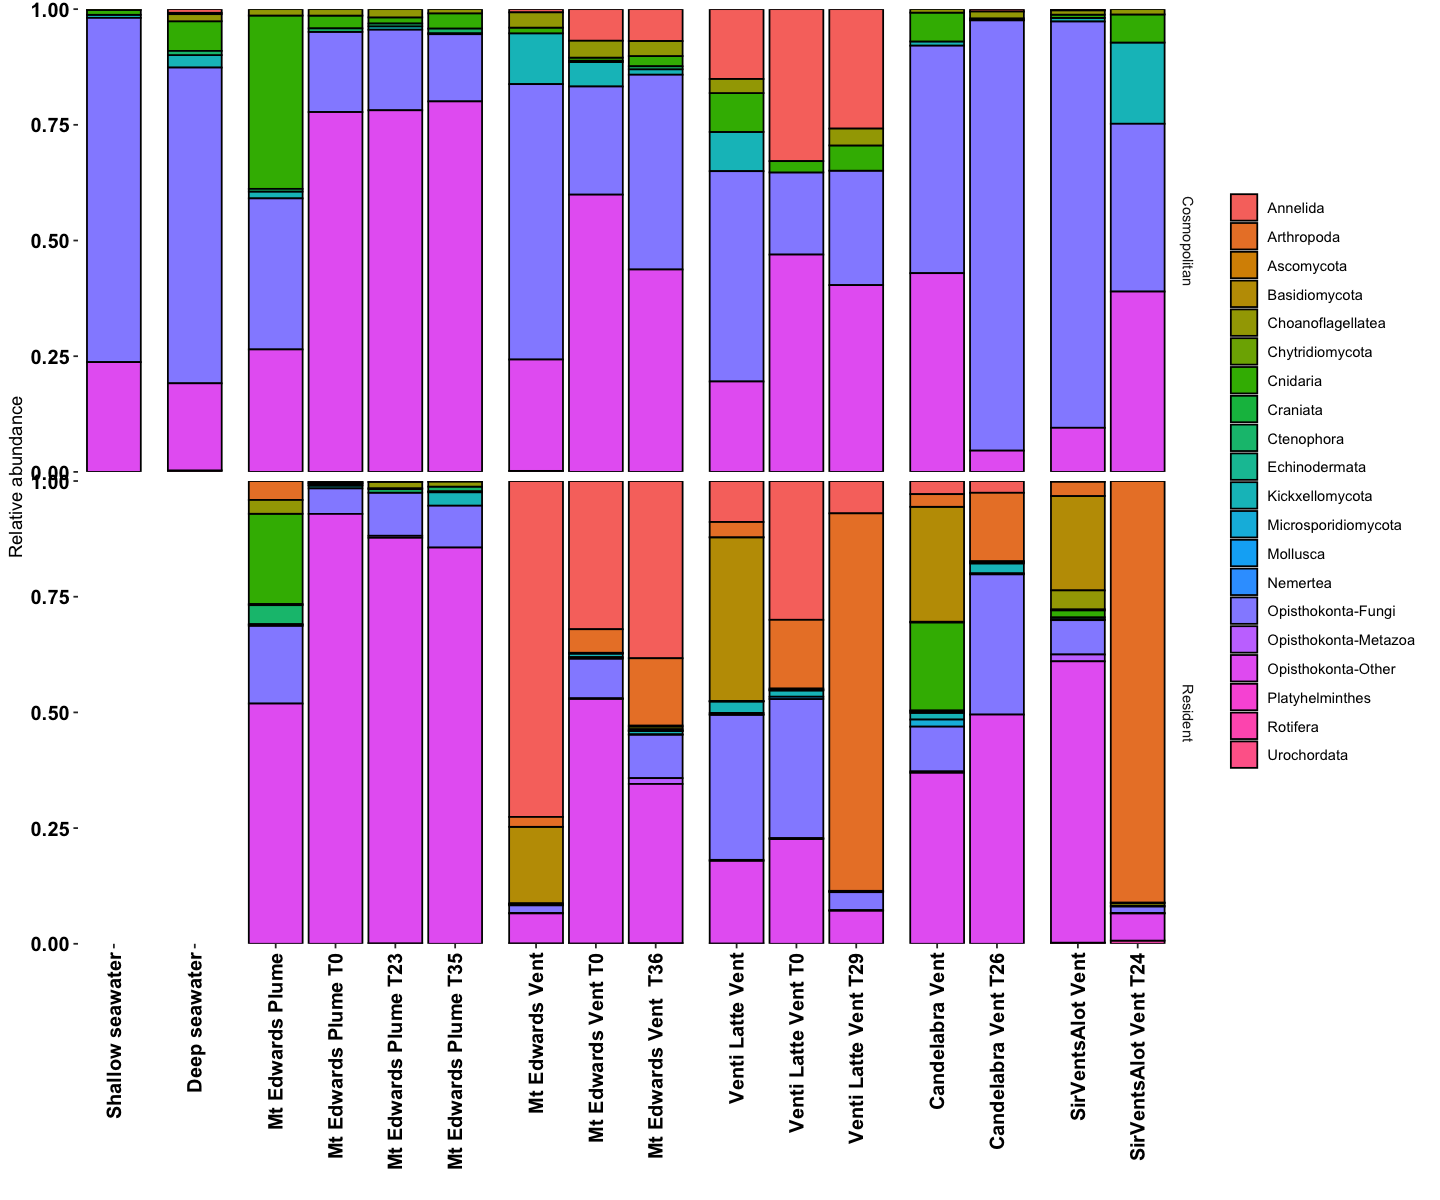

In [293]:
# Heterotrophs - non-ciliate
# tax_order<-c("Alveolata-Dinoflagellates","Alveolata-Other","Dinophyceae_X","Gonyaulacales","Gymnodiniales","Peridiniales","Suessiales","Noctilucales","Dino-Group-I","Dino-Group-II","Dino-Group-IV","MAST-2","MAST-3","MAST-4","MAST-7","MAST-8","MAST-9","MAST-25","Bacillariophyta","Bolidophyceae","Chrysophyceae","Dictyochophyceae","MOCH-3","Pelagophyceae","Synurophyceae","Stramenopiles-Ochrophyta","Stramenopiles-Other","Rhizaria-Cercozoa","Acantharea","Polycystinea","RAD-B","RAD-C","Hacrobia-Cryptophyta","Hacrobia-Haptophyta","Katablepharidophyta","Telonemia","Picozoa","Centroheliozoa")
# color_order<-c("#f7f4f9","#e7e1ef","#d4b9da","#df65b0","#e7298a","#ce1256","#980043","#67001f","#fee0d2","#fc9272","#de2d26","#ffffcc","#ffeda0","#fed976","#feb24c","#fd8d3c","#fc4e2a","#e31a1c","#f7fcf5","#e5f5e0","#c7e9c0","#a1d99b","#74c476","#41ab5d","#238b45","#006d2c","#00441b","#a6bddb","#74a9cf","#3690c0","#0570b0","#045a8d","#bfd3e6","#9ebcda","#8c96c6","#8c6bb1","#88419d","#810f7c")
# gr_tax_res_toplot$TAXORDER <- factor(gr_tax_res_toplot$Taxa2, levels = tax_order)
# names(color_order) <- tax_order
meta <- c("Opisthokonta-Metazoa", "Opisthokonta-Fungi", "Opisthokonta-Other")
supp_plot <- ggplot(gr_tax_res_toplot, aes(x = SAMPLENAME, y = SUM, fill = Taxa2)) +
    geom_bar(stat = "identity", position = "fill", color = "black") +
#     scale_fill_manual(values = color_order) +
    scale_y_continuous(expand = c(0,0))+
    theme(legend.position = "right",
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          panel.background = element_blank(),
          axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold", size = 12),
          axis.text.y = element_text(color="black", face="bold", size = 12),
          strip.text.x = element_blank(),
          strip.background = element_blank(),
          legend.title = element_blank()) +
    labs(x="", y="Relative abundance")+
    facet_grid(RES_COSMO~LOCATION_ORDER, space = "free", scales = "free")
supp_plot %+% subset(gr_tax_res_toplot, !(RES_COSMO == "Other") & Taxa %in% meta)

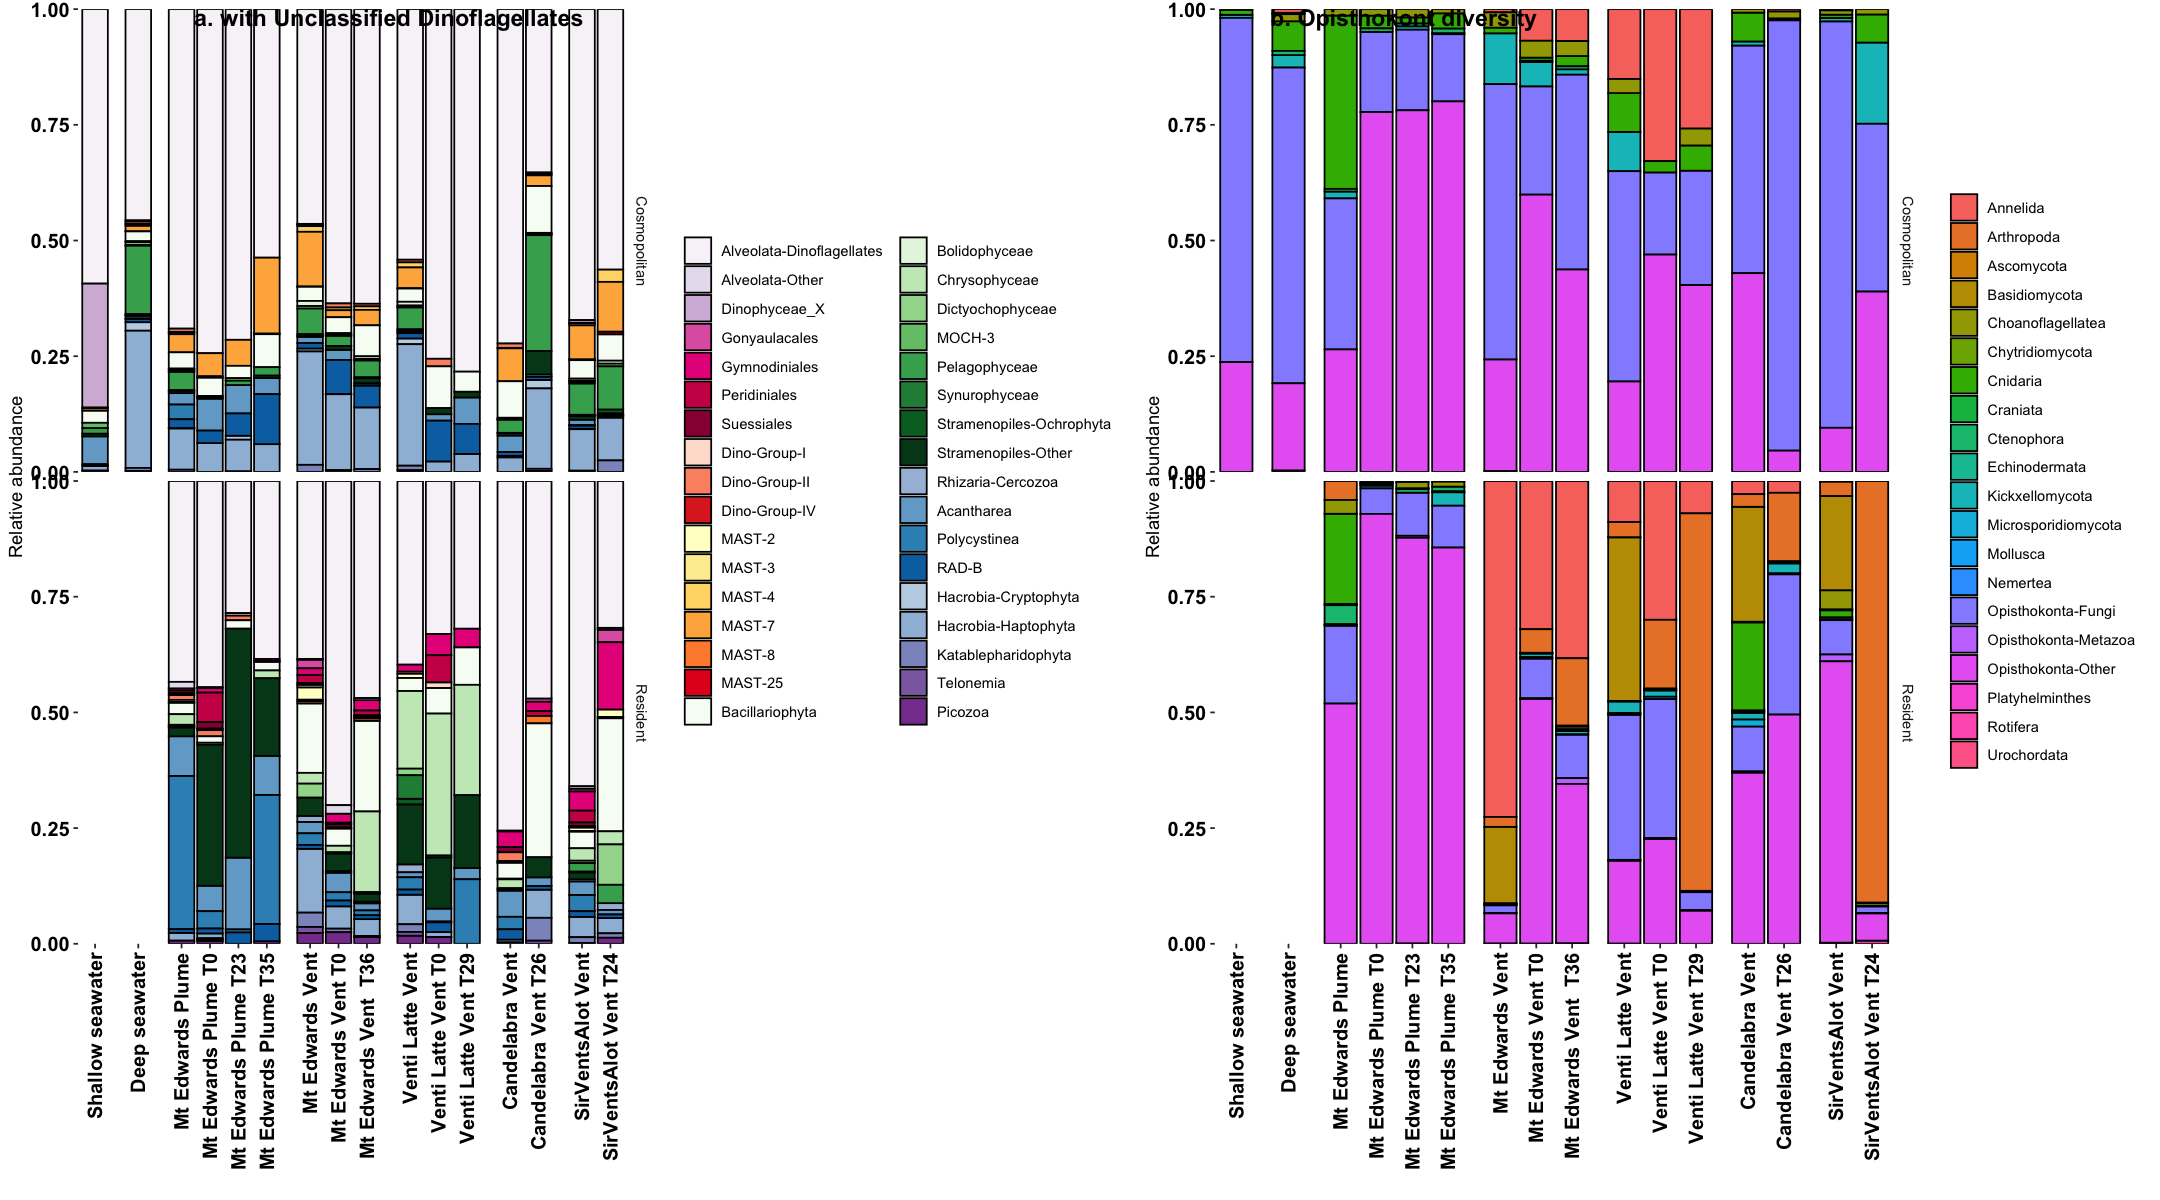

In [304]:
# Supplementary figure
options(repr.plot.width = 18, repr.plot.height = 10)

# svg("supplementary-tax-res.svg", w = 18, h = 10)
plot_grid(
    hets_plot %+% subset(gr_tax_res_toplot, !(RES_COSMO == "Other") & Taxa %in% taxa_select),
    supp_plot %+% subset(gr_tax_res_toplot, !(RES_COSMO == "Other") & Taxa %in% meta),
    labels = c("a. with Unclassified Dinoflagellates", "b. Opisthokont diversity"), rel_widths = c(1, 0.9),
    align = "h", ncol = 2)
# dev.off()
# ?plot_grid()

## Clustering of all samples - include replicates

In [378]:
# Dendrogram - supplementary - demonstrate how all samples cluster (include replicates)
load("data-input/GordaRidge-ASVtable-avg-22-07-2020.RData", verbose = T)
gr_counts_dendro <- gr_counts_avg_wtax %>%
  unite("SAMPLE", Sampletype, LocationName, LOCATION_SPECIFIC, SAMPLEID, sep = "_", remove = FALSE) %>%
  select(Feature.ID, SAMPLE, COUNT_AVG) %>%
  pivot_wider(names_from = SAMPLE, values_from = COUNT_AVG, values_fill = list(COUNT_AVG = 0)) %>%
  column_to_rownames(var = "Feature.ID") %>%
  data.frame
head(gr_counts_dendro[1:2,])

Loading objects:
  gr_counts_filter
  gr_counts_wtax
  gr_counts_avg_wtax


in.situ_Shallow.seawater_BSW081_sterivex
0009645516609bda2246e1955ff9ec1d 80                                      
0030ad8ce44f257c42daf3673bf92197 36                                      
                                 in.situ_Venti.Latte.Vent_Vent040_SUPR
0009645516609bda2246e1955ff9ec1d  0                                   
0030ad8ce44f257c42daf3673bf92197 12                                   
                                 in.situ_Candelabra.Vent_Vent088_SUPR
0009645516609bda2246e1955ff9ec1d  0                                  
0030ad8ce44f257c42daf3673bf92197 34                                  
                                 Grazing_SirVentsAlot.Vent_Vent110_T24
0009645516609bda2246e1955ff9ec1d  0                                   
0030ad8ce44f257c42daf3673bf92197 15                                   
                                 in.situ_Deep.seawater_BSW056_sterivex
0009645516609bda2246e1955ff9ec1d 0                                    
0030ad8ce44f257c42daf3673bf92197 0                                    
                                 in.situ_Mt.Edwards.Plume_Plume001_sterivex
0009645516609bda2246e1955ff9ec1d 0                                         
0030ad8ce44f257c42daf3673bf92197 0                                         
                                 in.situ_Mt.Edwards.Plume_Plume036_sterivex
0009645516609bda2246e1955ff9ec1d 0                                         
0030ad8ce44f257c42daf3673bf92197 0                                         
                                 in.situ_Mt.Edwards.Plume_Plume096_sterivex
0009645516609bda2246e1955ff9ec1d 0                                         
0030ad8ce44f257c42daf3673bf92197 0                                         
                                 in.situ_Venti.Latte.Vent_Vent039_SUPR
0009645516609bda2246e1955ff9ec1d 0                                    
0030ad8ce44f257c42daf3673bf92197 0                                    
                                 in.situ_SirVentsAlot.Vent_Vent105_SUPR ⋯
0009645516609bda2246e1955ff9ec1d 0                                      ⋯
0030ad8ce44f257c42daf3673bf92197 0                                      ⋯
                                 in.situ_Venti.Latte.Vent_Vent041_SUPR
0009645516609bda2246e1955ff9ec1d 0                                    
0030ad8ce44f257c42daf3673bf92197 0                                    
                                 Grazing_Mt.Edwards.Vent_Vent013_T0
0009645516609bda2246e1955ff9ec1d 0                                 
0030ad8ce44f257c42daf3673bf92197 0                                 
                                 Grazing_Mt.Edwards.Vent_Vent013_T36
0009645516609bda2246e1955ff9ec1d 0                                  
0030ad8ce44f257c42daf3673bf92197 0                                  
                                 in.situ_SirVentsAlot.Vent_Vent107_SUPR
0009645516609bda2246e1955ff9ec1d 0                                     
0030ad8ce44f257c42daf3673bf92197 0                                     
                                 Grazing_Candelabra.Vent_Vent090_T24
0009645516609bda2246e1955ff9ec1d 0                                  
0030ad8ce44f257c42daf3673bf92197 0                                  
                                 in.situ_Mt.Edwards.Vent_Vent009_SUPR
0009645516609bda2246e1955ff9ec1d 0                                   
0030ad8ce44f257c42daf3673bf92197 0                                   
                                 Grazing_Venti.Latte.Vent_Vent043_T0
0009645516609bda2246e1955ff9ec1d 0                                  
0030ad8ce44f257c42daf3673bf92197 0                                  
                                 in.situ_Mt.Edwards.Vent_Vent010_SUPR
0009645516609bda2246e1955ff9ec1d 0                                   
0030ad8ce44f257c42daf3673bf92197 0                                   
                                 Grazing_Venti.Latte.Vent_Vent043_T36
0009645516609bda2246e1955ff9ec1d 0                                   
0030ad8ce44f257c42daf3673bf92

In [379]:
library(vegan); library(ggdendro)
# Dendrogram with all samples:
gr_clust <- hclust(vegdist(t(gr_counts_dendro), method = "jaccard"), method = "complete")
all <- ggdendrogram(gr_clust, rotate = TRUE, size = 3, face = "bold")

`summarise()` regrouping output by 'SAMPLE' (override with `.groups` argument)



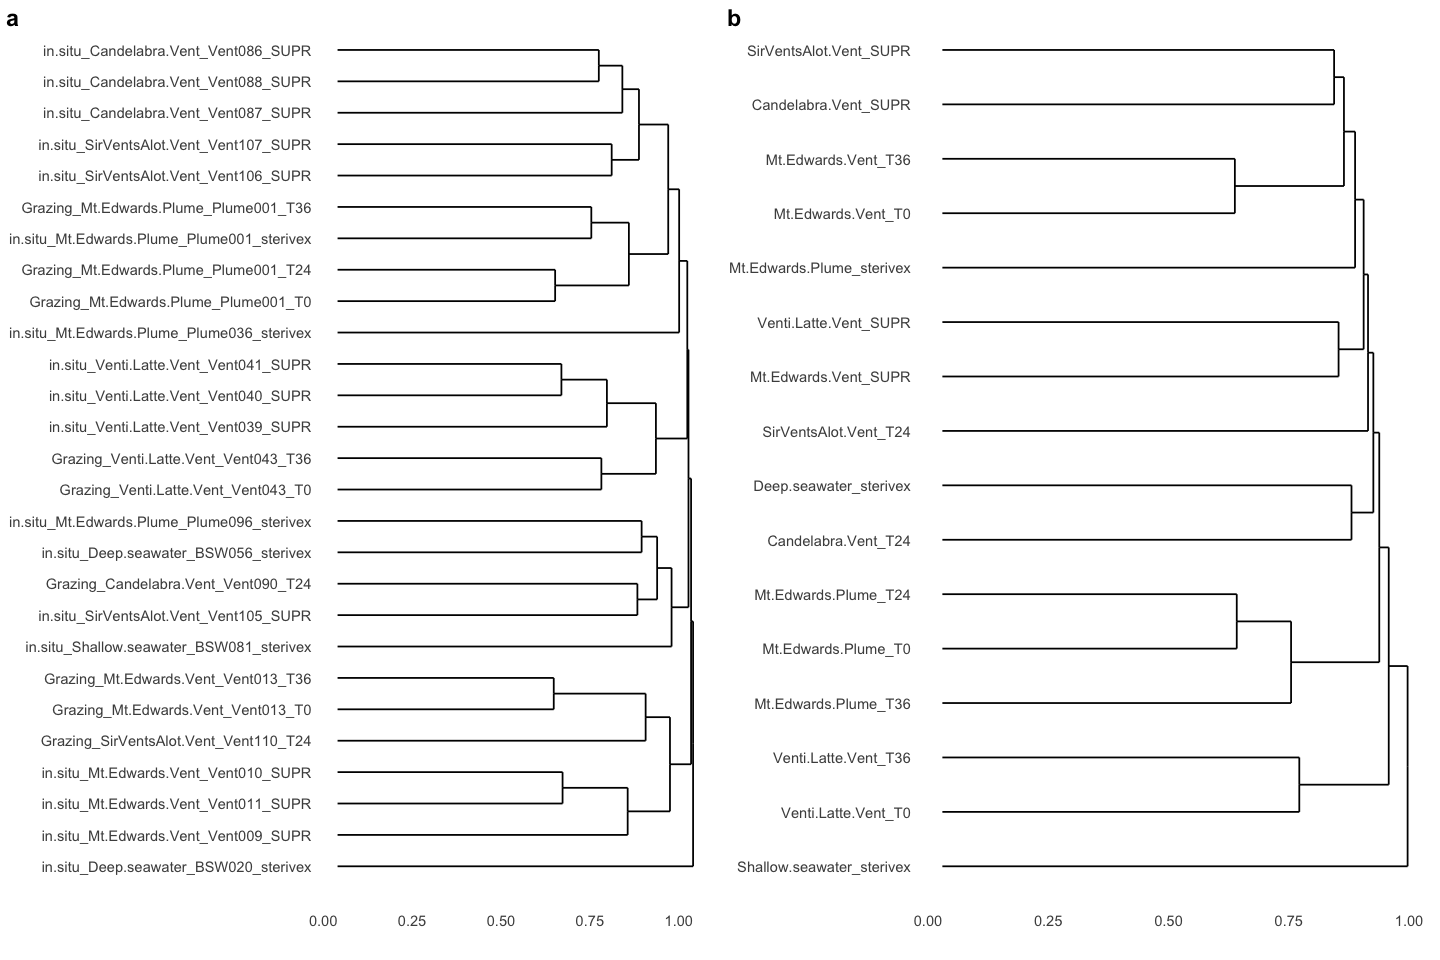

In [382]:
# Average across replicates
gr_all_avg <- gr_counts_avg_wtax %>%
  unite("SAMPLE", LocationName, SAMPLEID, sep = "_", remove = FALSE) %>%
  group_by(SAMPLE, Feature.ID) %>%
  summarise(AVG_insitu = mean(COUNT_AVG)) %>%
  select(Feature.ID, SAMPLE, AVG_insitu) %>%
  pivot_wider(names_from = SAMPLE, values_from = AVG_insitu, values_fill = list(AVG_insitu = 0)) %>%
  column_to_rownames(var = "Feature.ID") %>%
  data.frame
gr_clust_all_avg <- hclust(vegdist(t(gr_all_avg), method = "jaccard"), method = "average")
avg <- ggdendrogram(gr_clust_all_avg, rotate = TRUE, size = 10)
# avg
#
# Plot together as supplementary figure
options(repr.plot.width = 12, repr.plot.height = 8)

plot_grid(all, avg, labels = c("a","b"))

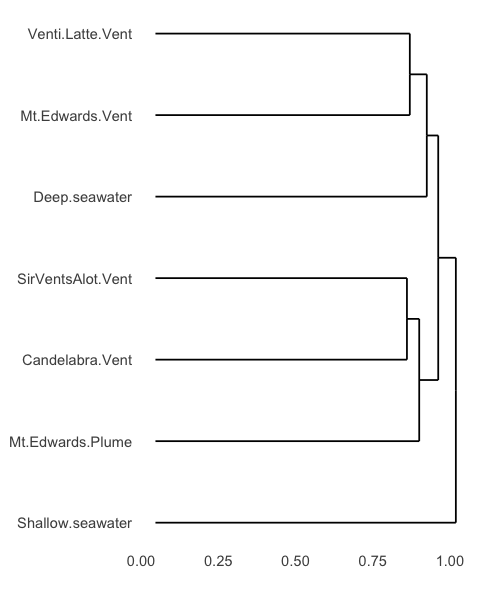

In [386]:
# Dendrogram of only in situ samples
options(repr.plot.width = 4, repr.plot.height = 5)
gr_clust_insitu_avg <- hclust(vegdist(t(gr_insitu_avg), method = "jaccard"), method = "complete")
ggdendrogram(gr_clust_insitu_avg, rotate = TRUE, size = 10)

In [387]:
## END ##

In [ ]:
ggplot(aes(x = SAMPLE, y = SUM, fill = Taxa2)) +
        geom_bar(stat="identity", position="fill", color="black") +
#         scale_fill_brewer(palette = color) +
        scale_y_continuous(expand = c(0,0))+
        theme(legend.position = "right",
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          panel.background = element_blank(),
          axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold", size = 12),
          axis.text.y = element_text(color="black", face="bold", size = 12),
          strip.text = element_blank(),
          legend.title = element_blank()) +
        labs(x="", y="Relative abundance")+
        facet_grid(.~LocationName + Taxa, space = "free", scales = "free")

In [21]:
# Amend level2 broad taxonomy (based on looking at which groups made up at least 1% of the sequences in a sample):
gr_counts_avg_wtax$LEVEL2 <- gr_counts_avg_wtax$level2
other <- c("Amoebozoa", "Apusozoa", "Excavata")
gr_counts_avg_wtax$LEVEL2[gr_counts_avg_wtax$level2 %in% other]="Other"
#
head(gr_counts_avg_wtax[1:2,])
gr_counts_avg_wtax$LEVEL2[gr_counts_avg_wtax$Taxa == "Alveolata-Ciliates"]="Ciliates"
gr_counts_avg_wtax$LEVEL2[gr_counts_avg_wtax$Taxa == "Alveolata-Dinoflagellates"]="Dinoflagellates"
gr_counts_avg_wtax$LEVEL2[gr_counts_avg_wtax$Taxa == "Opisthokonta-Metazoa"]="Metazoa"
gr_counts_avg_wtax$LEVEL2[gr_counts_avg_wtax$Taxa == "Opisthokonta-Fungi"]="Fungi"
unique(gr_counts_avg_wtax$LEVEL2)
#
# head(gr_counts_avg_wtax)
gr_lev2_avg <- gr_counts_avg_wtax %>%
  group_by(SAMPLEID, Sampletype, LocationName, LEVEL2) %>%
  summarise(SUM = sum(COUNT_AVG)) %>%
  as.data.frame
# head(gr_lev2_avg)

# Make table to summarize top hits:
gr_lev2_avg_relabun <- gr_counts_avg_wtax %>%
  group_by(SAMPLEID, Sampletype, LocationName, LOCATION_SPECIFIC, level2) %>%
  summarise(SUM = sum(COUNT_AVG)) %>%
  group_by(SAMPLEID, Sampletype, LocationName, LOCATION_SPECIFIC) %>%
  mutate(RelAbun = 100*(SUM/sum(SUM))) %>%
  as.data.frame
#
gr_lev2_summary <- dcast(gr_lev2_avg_relabun[c(1:5,7)], SAMPLEID + Sampletype + LocationName + LOCATION_SPECIFIC ~level2, fill=0)

Feature.ID                       SAMPLEID Sampletype LOCATION_SPECIFIC
1 0009645516609bda2246e1955ff9ec1d sterivex in situ    BSW081           
2 0030ad8ce44f257c42daf3673bf92197 sterivex in situ    BSW081           
  LocationName     Taxon     level1    level2     level3 level4 level5 level6
1 Shallow seawater Eukaryota Eukaryota Unassigned                            
2 Shallow seawater Eukaryota Eukaryota Unassigned                            
  level7 Taxa       COUNT_AVG LEVEL2    
1        Unassigned 80        Unassigned
2        Unassigned 36        Unassigned

[1] "Unassigned"      "Metazoa"         "Ciliates"        "Opisthokonta"   
 [5] "Stramenopiles"   "Rhizaria"        "Dinoflagellates" "Fungi"          
 [9] "Hacrobia"        "Archaeplastida"  "Other"           "Alveolata"

`summarise()` regrouping output by 'SAMPLEID', 'Sampletype', 'LocationName' (override with `.groups` argument)
`summarise()` regrouping output by 'SAMPLEID', 'Sampletype', 'LocationName', 'LOCATION_SPECIFIC' (override with `.groups` argument)
Using RelAbun as value column: use value.var to override.


In [22]:
# Factor for plotting:
# unique(gr_lev2_avg$LEVEL2)
level2ORDER <- c("Dinoflagellates", "Ciliates","Alveolata","Rhizaria", "Hacrobia", "Archaeplastida","Stramenopiles","Metazoa","Fungi","Opisthokonta","Other","Unassigned")
# length(level2ORDER)
level2NAME <- c("Dinoflagellates", "Ciliates","Alveolata-Other","Rhizaria", "Hacrobia", "Archaeplastida","Stramenopiles","Metazoa","Fungi","Opisthokonta-Other","Other","Unassigned")
gr_lev2_avg$LEVEL2ORDER <- factor(gr_lev2_avg$LEVEL2, levels=level2ORDER, labels = level2NAME)

level2color <-c("#e7e1ef", "#df65b0","#980043","#fed976", "#fd8d3c", "#78c679","#238443","#225ea8","#67a9cf","#8c6bb1","#810f7c","#737373")
names(level2color)<-level2NAME
#
# Factor experiment
# unique(gr_lev2_avg$SAMPLEID)
exporder <- c("sterivex", "SUPR", "T0", "T24", "T36")
gr_lev2_avg$SAMPLEID_ORDER <- factor(gr_lev2_avg$SAMPLEID, levels = exporder)
unique(gr_lev2_avg$LocationName)
gr_lev2_avg$LOCATION_ORDER <- factor(gr_lev2_avg$LocationName, levels=c("Shallow seawater", "Deep seawater", "Mt Edwards Plume", "Mt Edwards Vent", "Venti Latte Vent", "Candelabra Vent", "SirVentsAlot Vent"))
# str(gr_lev2_avg)
# head(gr_lev2_avg)
#
gr_lev2_avg$SAMPLE <- paste(gr_lev2_avg$LocationName, gr_lev2_avg$Sampletype, gr_lev2_avg$SAMPLEID_ORDER, sep=" ")
x<-unique(gr_lev2_avg$SAMPLE)
# View(x)
#
sample_order_all<-c("Shallow seawater in situ sterivex","Deep seawater in situ sterivex","Mt Edwards Plume in situ sterivex","Mt Edwards Plume Grazing T0","Mt Edwards Plume Grazing T24","Mt Edwards Plume Grazing T36","Mt Edwards Vent in situ SUPR","Mt Edwards Vent Grazing T0","Mt Edwards Vent Grazing T36","Venti Latte Vent in situ SUPR","Venti Latte Vent Grazing T0","Venti Latte Vent Grazing T36","Candelabra Vent in situ SUPR","Candelabra Vent Grazing T24","SirVentsAlot Vent in situ SUPR","SirVentsAlot Vent Grazing T24")
sample_name_all<-c("Shallow seawater","Deep seawater","Mt Edwards Plume","Mt Edwards Plume T0","Mt Edwards Plume T23","Mt Edwards Plume T35","Mt Edwards Vent","Mt Edwards Vent T0","Mt Edwards Vent  T36","Venti Latte Vent","Venti Latte Vent T0","Venti Latte Vent T29","Candelabra Vent","Candelabra Vent T26","SirVentsAlot Vent","SirVentsAlot Vent T24")
gr_lev2_avg$sample_order<-factor(gr_lev2_avg$SAMPLE, levels = sample_order_all, labels = sample_name_all)
# head(gr_lev2_avg)
# unique(gr_lev2_avg$LEVEL2ORDER)
#
barplot_lev2 <- function(df){
  ggplot(df, aes(x=(sample_order), y=SUM, fill=LEVEL2ORDER)) +
    geom_bar(stat="identity", position="fill", color="black") +
    scale_fill_manual(values=level2color) +
    scale_y_continuous(expand = c(0,0))+
    theme(legend.position = "right",
          # axis.line = element_blank(),
          panel.grid.major = element_blank(),
          panel.grid.minor = element_blank(),
          panel.border = element_blank(),
          panel.background = element_blank(),
          axis.text.x = element_text(angle=90, hjust=1, vjust=0.5, color = "black", face="bold"),
          axis.text.y = element_text(color="black", face="bold"),
          strip.text = element_blank(),
          legend.title = element_blank()) +
    labs(x="", y="")+
    facet_grid(.~LOCATION_ORDER, space = "free", scales = "free")
}

[1] Deep seawater     Mt Edwards Plume  Shallow seawater  Candelabra Vent  
[5] Mt Edwards Vent   SirVentsAlot Vent Venti Latte Vent 
12 Levels:  Background Candelabra Vent Deep seawater ... Venti Latte Vent

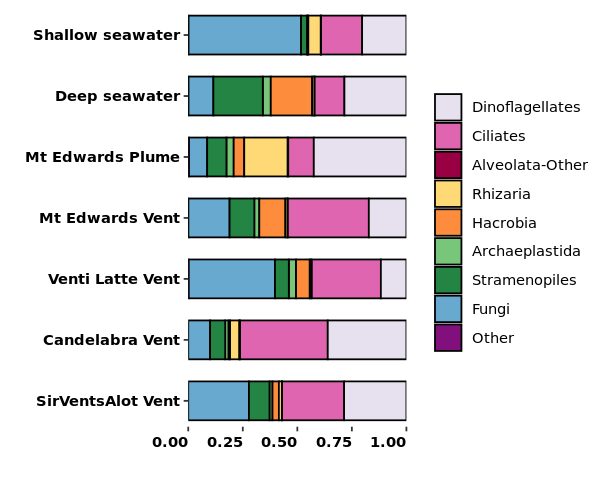

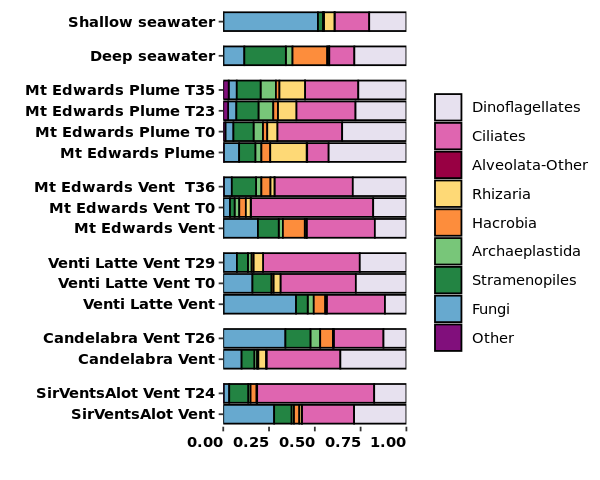

In [31]:
options(repr.plot.width = 5, repr.plot.height = 4) #set plot size output 

insitu <- c("sterivex", "SUPR")
# svg("barplot-insitu-04222020.svg", h = 5, w= 8)
barplot_lev2(subset(gr_lev2_avg, (SAMPLEID %in% insitu & !(LEVEL2 == "Unassigned" | LEVEL2 == "Opisthokonta" | LEVEL2 == "Metazoa")))) + 
  coord_flip() + 
  facet_grid(LOCATION_ORDER ~ ., space = "free", scales = "free") +
  theme(axis.text.x = element_text(color="black", face="bold", angle = 0))
# dev.off()

# svg("barplot-insitu-grazing-04222020.svg", h = 10, w= 8)
barplot_lev2(subset(gr_lev2_avg, (!(LEVEL2 == "Unassigned" | LEVEL2 == "Opisthokonta" | LEVEL2 == "Metazoa")))) + 
  coord_flip() + 
  facet_grid(LOCATION_ORDER ~ ., space = "free", scales = "free") +
  theme(axis.text.x = element_text(color="black", face="bold", angle = 0))
# dev.off()

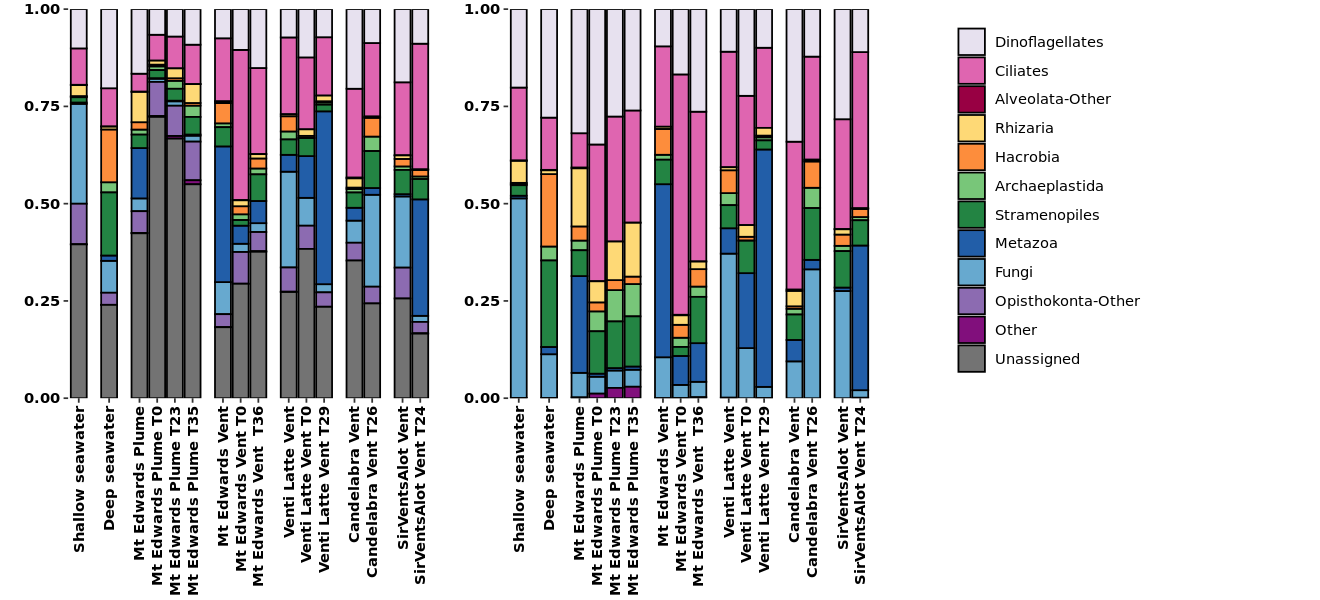

In [27]:
options(repr.plot.width =11, repr.plot.height = 5) #set plot size output 

# With and without unassigned
legend<-get_legend(barplot_lev2(gr_lev2_avg))
# svg("Level2-taxonomy-w-wo-unassigned.svg", h=8, w=23)
plot_grid(
  barplot_lev2(gr_lev2_avg)+theme(legend.position = "none"),
  barplot_lev2(subset(gr_lev2_avg, !(LEVEL2 == "Unassigned" | LEVEL2 == "Opisthokonta")))+theme(legend.position = "none"), legend,
  nrow=1,ncol=3, align="hv", axis="lt", rel_heights = c(1,1))
# dev.off()

## Barplot to additional taxonomic resolution

`summarise()` regrouping output by 'SAMPLEID', 'Sampletype', 'LocationName' (override with `.groups` argument)


SAMPLEID Sampletype LocationName  Taxa                      SUM 
1 sterivex in situ    Deep seawater Alveolata-Ciliates        2416
2 sterivex in situ    Deep seawater Alveolata-Dinoflagellates 5019
  TAXA_ORDER                SAMPLE                         sample_order 
1 Alveolata-Ciliates        Deep seawater in situ sterivex Deep seawater
2 Alveolata-Dinoflagellates Deep seawater in situ sterivex Deep seawater
  LOCATION_ORDER
1 Deep seawater 
2 Deep seawater

[1] "Alveolata-Ciliates"           "Alveolata-Dinoflagellates"   
 [3] "Alveolata-Other"              "Archaeplastida-Chlorophyta"  
 [5] "Archaeplastida-Other"         "Archaeplastida-Streptophyta" 
 [7] "Hacrobia-Cryptophyta"         "Hacrobia-Haptophyta"         
 [9] "Hacrobia-Katablepharidophyta" "Hacrobia-Other"              
[11] "Opisthokonta-Fungi"           "Opisthokonta-Metazoa"        
[13] "Opisthokonta-Other"           "Rhizaria"                    
[15] "Stramenopiles-Ochrophyta"     "Stramenopiles-Other"         
[17] "Stramenopiles-Pseudofungi"    "Stramenopiles-Sagenista"     
[19] "Unassigned"                   "Other"                       
[21] "Excavata"

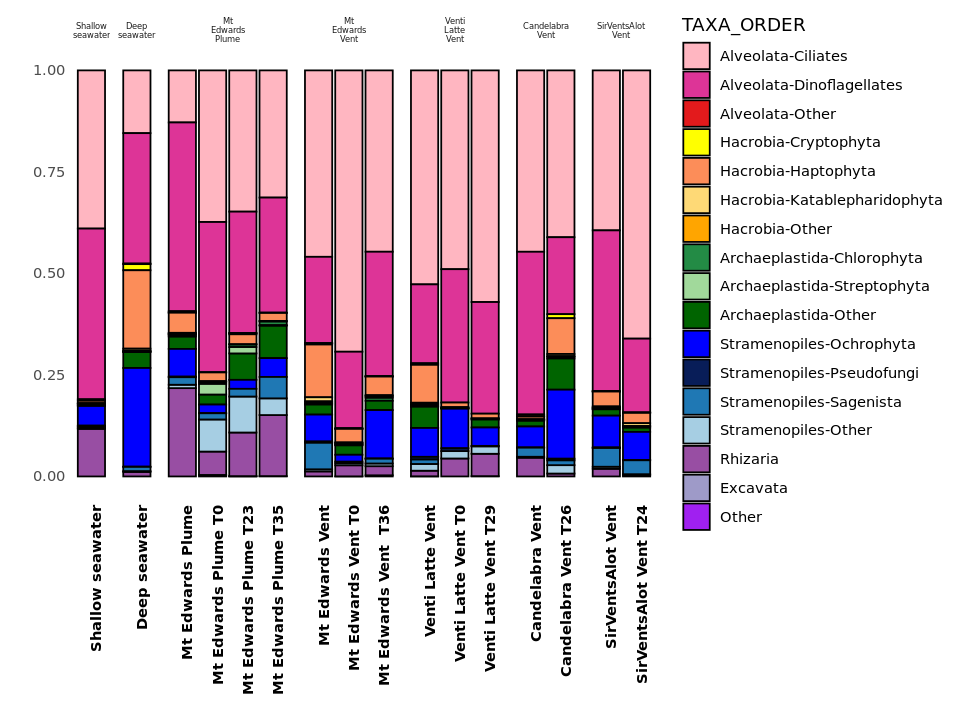

In [33]:
options(repr.plot.width = 8, repr.plot.height = 6) #set plot size output 

gr_lev2_taxres <- gr_counts_avg_wtax %>%
  group_by(SAMPLEID, Sampletype, LocationName, Taxa) %>%
  summarise(SUM = sum(COUNT_AVG)) %>%
  as.data.frame

# Factor taxa and colors:
tax_order<-c("Alveolata-Ciliates","Alveolata-Dinoflagellates","Alveolata-Other","Hacrobia-Cryptophyta","Hacrobia-Haptophyta","Hacrobia-Katablepharidophyta","Hacrobia-Other","Archaeplastida-Chlorophyta","Archaeplastida-Streptophyta","Archaeplastida-Other","Stramenopiles-Ochrophyta","Stramenopiles-Pseudofungi","Stramenopiles-Sagenista","Stramenopiles-Other","Rhizaria","Excavata","Opisthokonta-Fungi","Opisthokonta-Metazoa","Opisthokonta-Other","Other","Unassigned")
tax_color<-c("lightpink","#dd3497","#e31a1c","yellow","#fc8d59","#fed976","orange","#238b45","#a1d99b","darkgreen","blue","#081d58","#1f78b4","#a6cee3","#984ea3","#9e9ac8","purple","#000000","#525252","#969696","#ffffff")
gr_lev2_taxres$TAXA_ORDER <- factor(gr_lev2_taxres$Taxa, levels = tax_order)
names(tax_order)<-tax_color

# Factor SAMPLID_ORDER
gr_lev2_taxres$SAMPLE <- paste(gr_lev2_taxres$LocationName, gr_lev2_taxres$Sampletype, gr_lev2_taxres$SAMPLEID, sep=" ")
sample_order_all<-c("Shallow seawater in situ sterivex","Deep seawater in situ sterivex","Mt Edwards Plume in situ sterivex","Mt Edwards Plume Grazing T0","Mt Edwards Plume Grazing T24","Mt Edwards Plume Grazing T36","Mt Edwards Vent in situ SUPR","Mt Edwards Vent Grazing T0","Mt Edwards Vent Grazing T36","Venti Latte Vent in situ SUPR","Venti Latte Vent Grazing T0","Venti Latte Vent Grazing T36","Candelabra Vent in situ SUPR","Candelabra Vent Grazing T24","SirVentsAlot Vent in situ SUPR","SirVentsAlot Vent Grazing T24")
sample_name_all<-c("Shallow seawater","Deep seawater","Mt Edwards Plume","Mt Edwards Plume T0","Mt Edwards Plume T23","Mt Edwards Plume T35","Mt Edwards Vent","Mt Edwards Vent T0","Mt Edwards Vent  T36","Venti Latte Vent","Venti Latte Vent T0","Venti Latte Vent T29","Candelabra Vent","Candelabra Vent T26","SirVentsAlot Vent","SirVentsAlot Vent T24")
gr_lev2_taxres$sample_order<-factor(gr_lev2_taxres$SAMPLE, levels = sample_order_all, labels = sample_name_all)
# exporder <- c("sterivex", "SUPR", "T0", "T24", "T36")
# gr_lev2_taxres$SAMPLEID_ORDER <- factor(gr_lev2_taxres$SAMPLEID, levels = exporder)
# unique(gr_lev2_taxres$LocationName)
gr_lev2_taxres$LOCATION_ORDER <- factor(gr_lev2_taxres$LocationName, levels=c("Shallow seawater", "Deep seawater", "Mt Edwards Plume", "Mt Edwards Vent", "Venti Latte Vent", "Candelabra Vent", "SirVentsAlot Vent"))
#
head(gr_lev2_taxres[1:2,])
#
barplot_tax <- ggplot(gr_lev2_taxres, aes(x=(sample_order), y = SUM, fill = TAXA_ORDER)) +
  geom_bar(stat="identity", position="fill", color="black") +
  scale_fill_manual(values = tax_color) +
  theme_minimal() +
  theme(legend.position = "right", axis.line = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        panel.border = element_blank(),
        panel.background = element_blank(),
        axis.text.x = element_text(angle=90, color = "black", face = "bold", hjust = 1, vjust = 1),
        strip.text = element_text(size = 5)) +
  labs(x="", y="") +
facet_grid(.~LOCATION_ORDER, space = "free", scales = "free", labeller = label_wrap_gen(width = 10, multi_line = TRUE))
#
unique(gr_lev2_taxres$Taxa) 
rm<-c("Unassigned", "Opisthokonta-Metazoa", "Opisthokonta-Fungi", "Opisthokonta-Other")
# svg("barplot-tax-all.svg", w = 10, h = 7.5)
barplot_tax %+% subset(gr_lev2_taxres, !(Taxa %in% rm))
# dev.off()